# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils
import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline
# Add-on : Set plotting options
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)
# Add-on : Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")
# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'

# Add-on check GPU configuration
nb_gpu = torch.cuda.device_count()
for i in range(nb_gpu):
    print("cuda #", i, torch.cuda.get_device_name(i))
    
# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
cuda # 0 TITAN Xp COLLECTORS EDITION
cuda # 1 GeForce GT 710
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [3]:
# Add-on : nb of threads (cores) for parallel processing (Udacity 4 with CPU, 8 with GPU envs)
threads = 8

# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



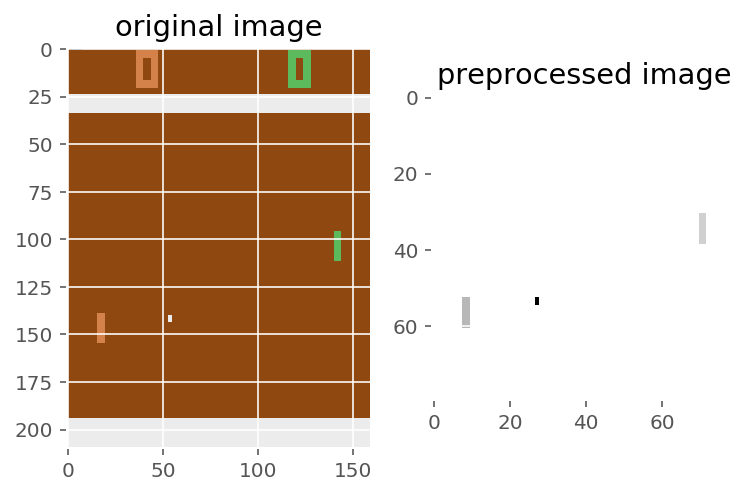

In [4]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # Conv outputsize = (inputsize + 2*padding - (kernel_size -1) -1 + stride)/stride 
        # 80x80x2 => 38x38x16 
        self.conv1 = nn.Conv2d(2, 16, kernel_size=6, stride=2, padding=0)
        # 38x38x16 => 9x9*32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=6, stride=4, padding=0)
        self.size=9*9*32
        
        # 2 fully connected layers
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.sig = nn.Sigmoid()
        
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # flatten the tensor
        x = x.view(-1,self.size)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sig(self.fc3(x))
        return x
    
# use your own policy!
#policy=pong_utils.Policy().to(device)
policy=Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


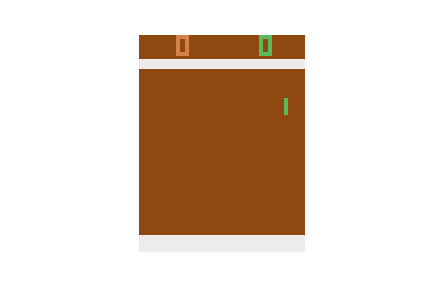
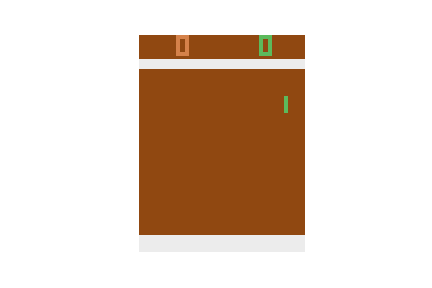
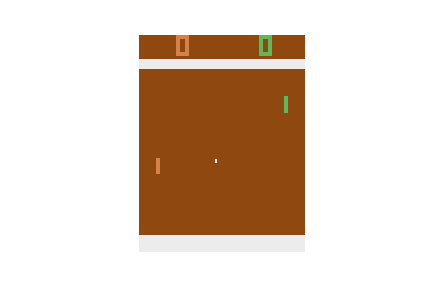
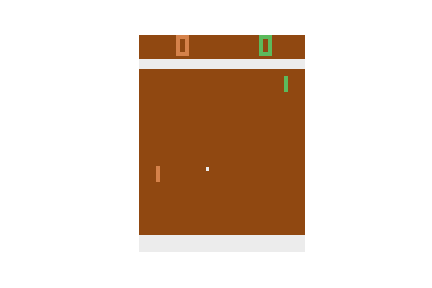
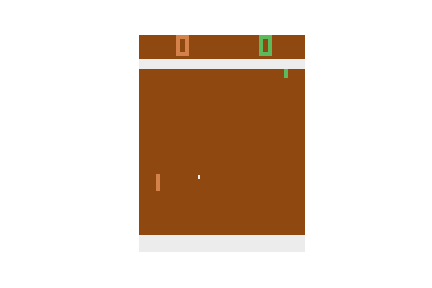
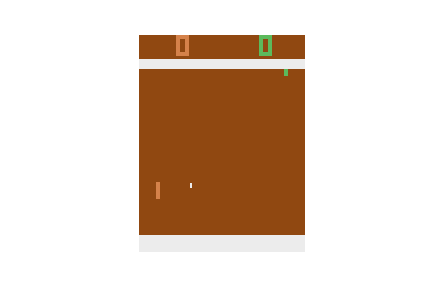
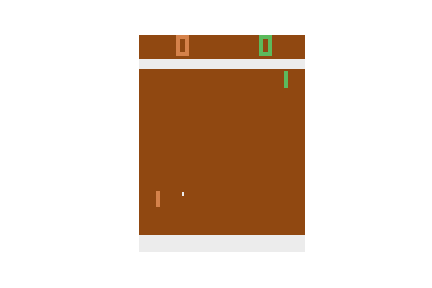
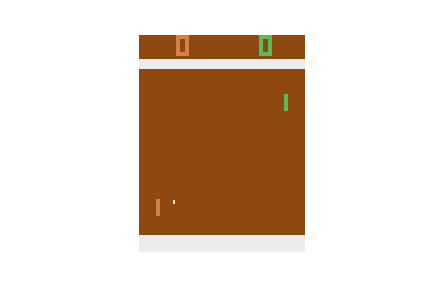
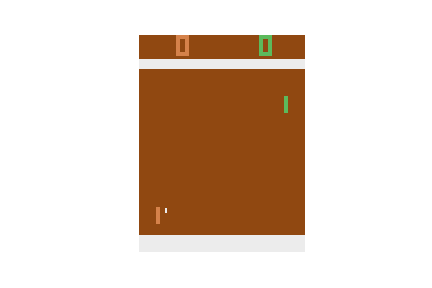
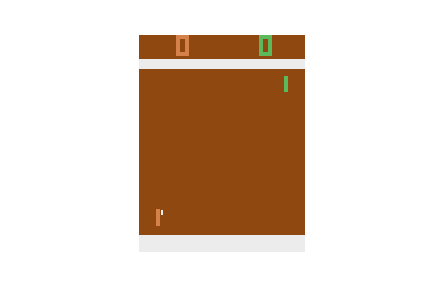
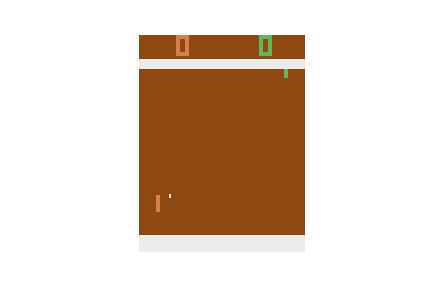
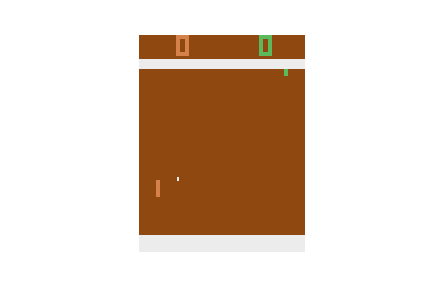
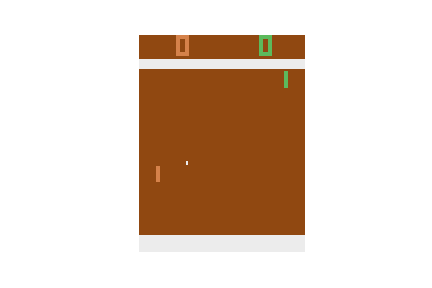
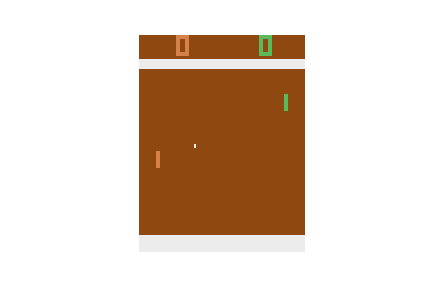
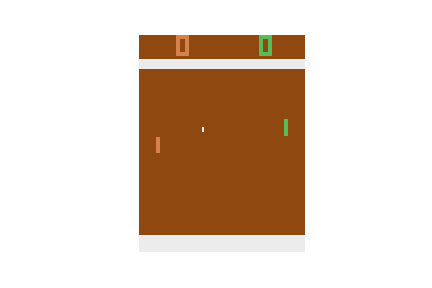
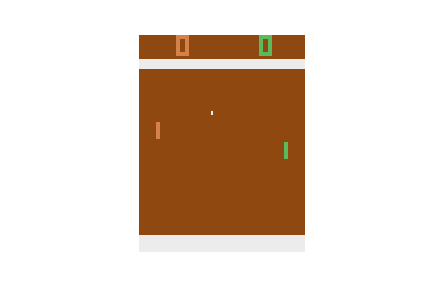
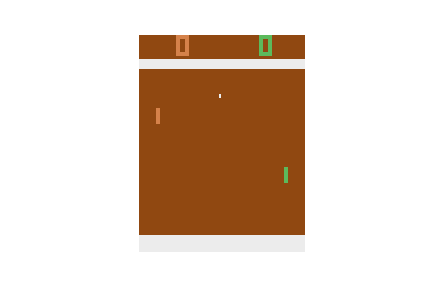
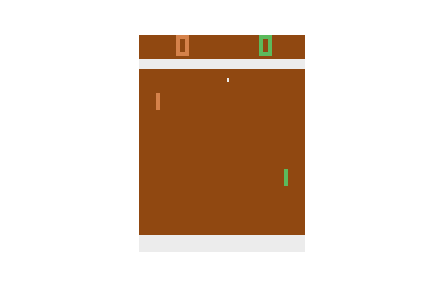
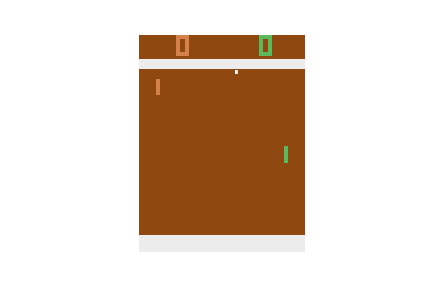
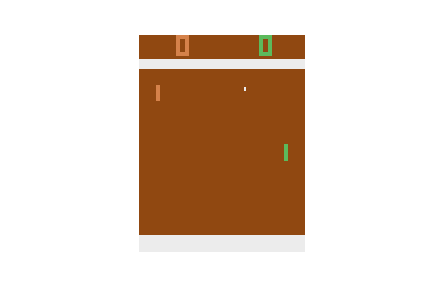
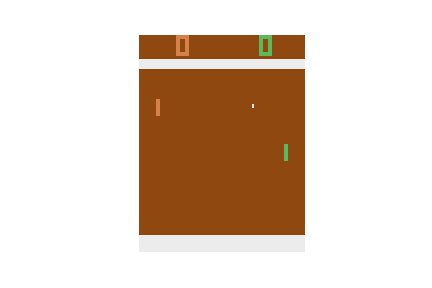
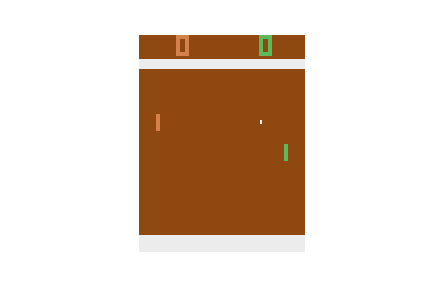
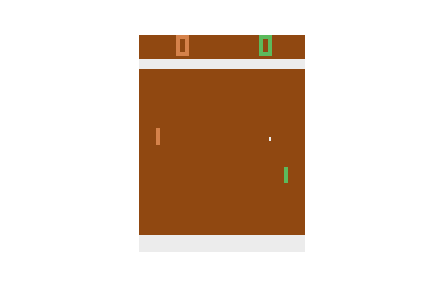
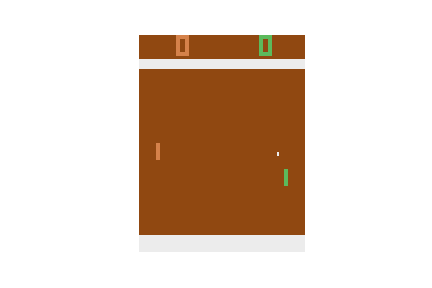
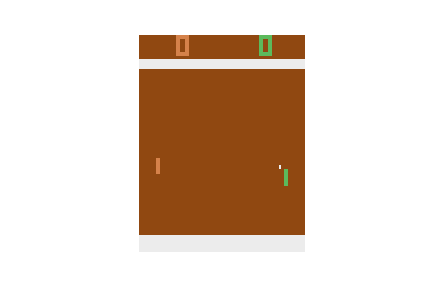
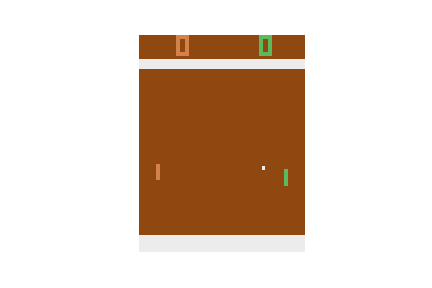
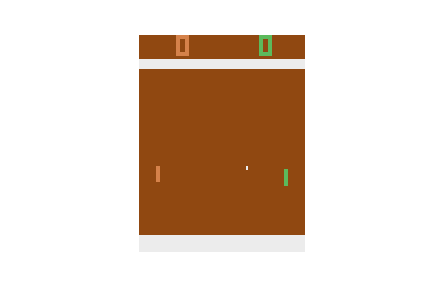
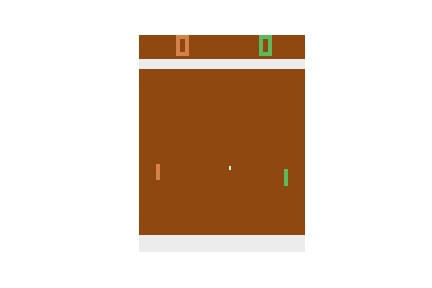
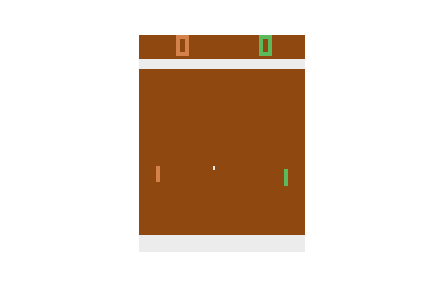
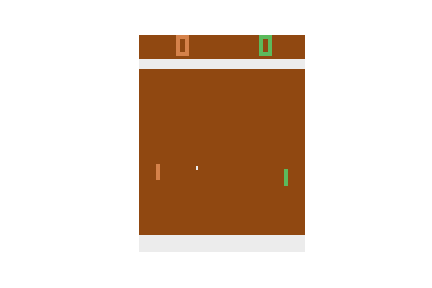
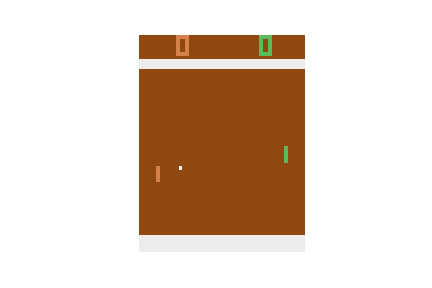
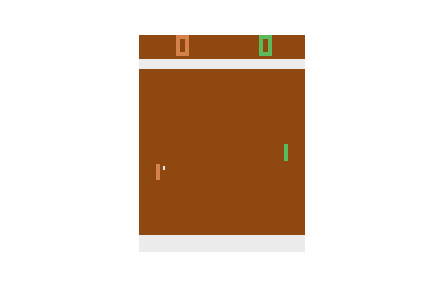
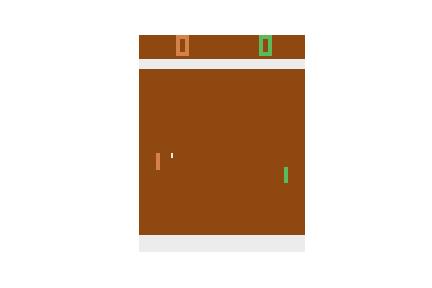
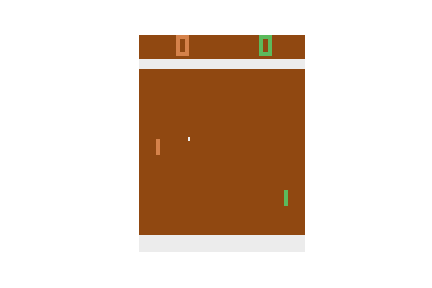
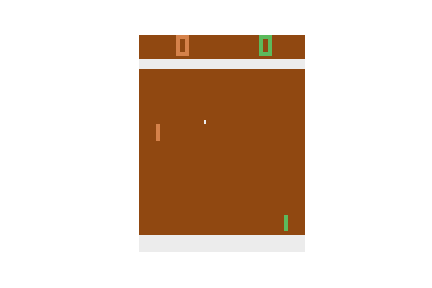
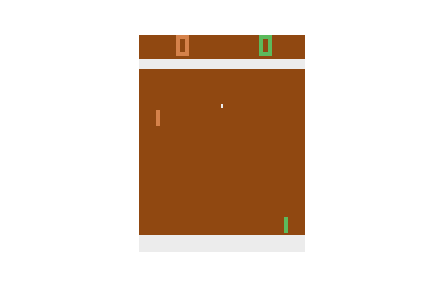
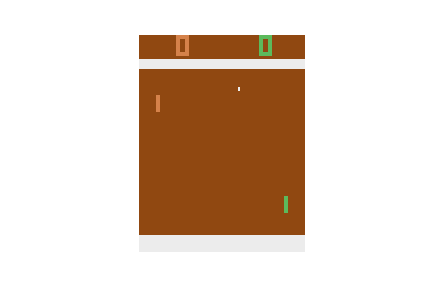
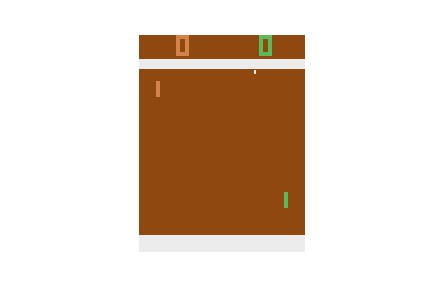
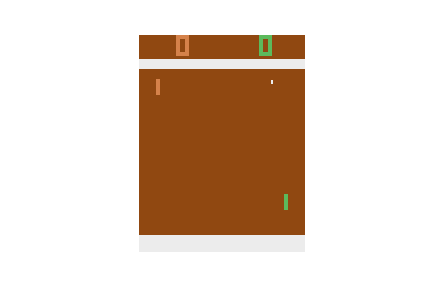
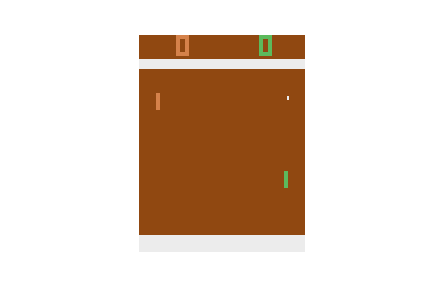
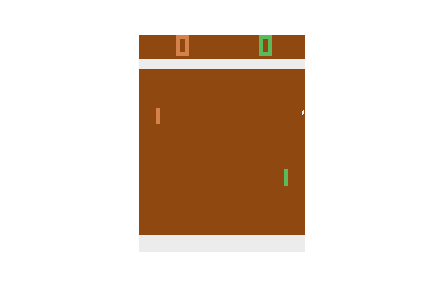
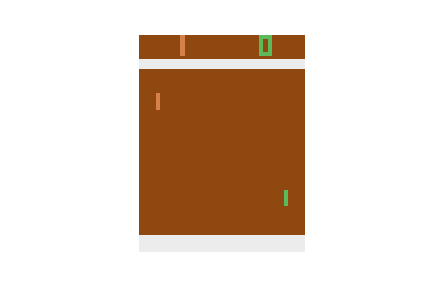
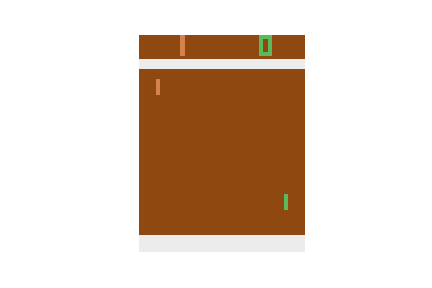
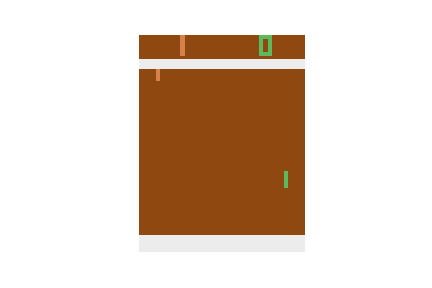
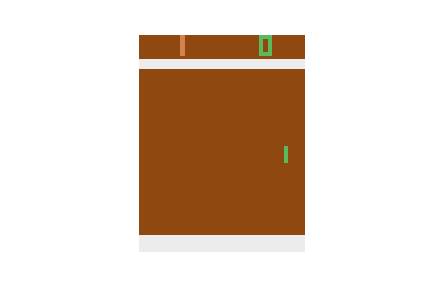
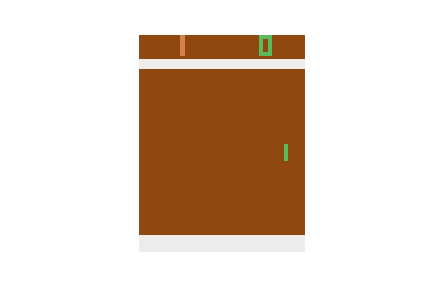
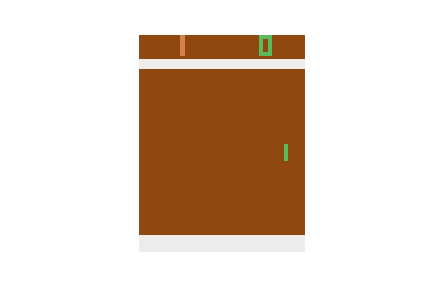
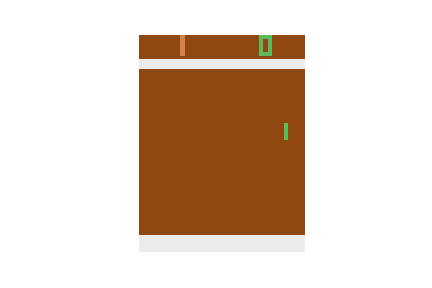
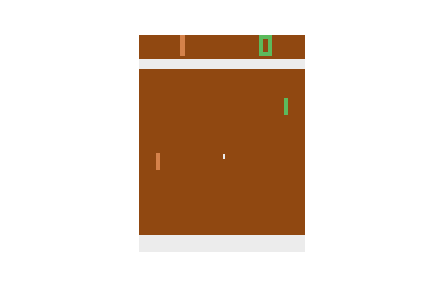
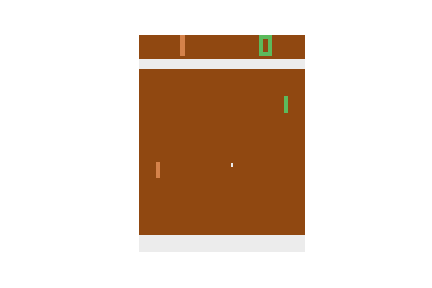
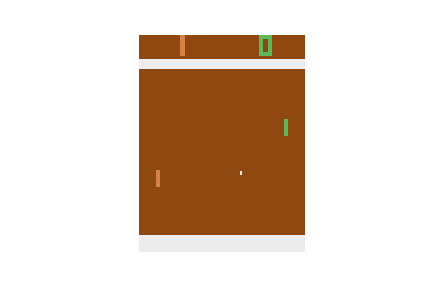
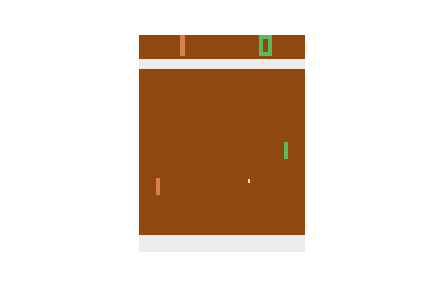
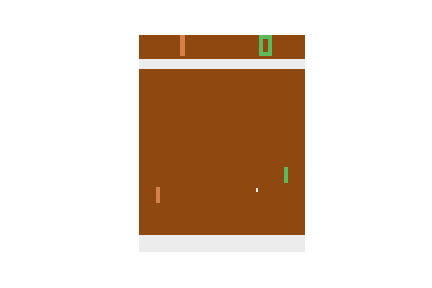
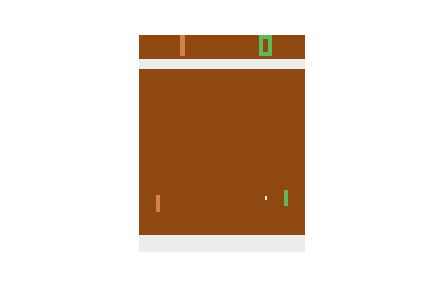
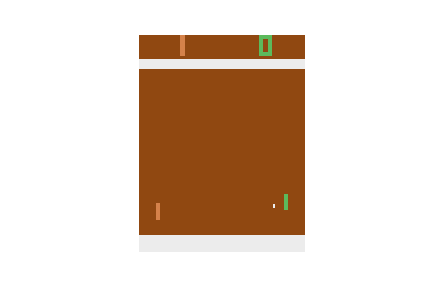
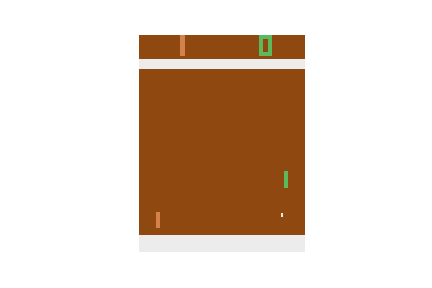
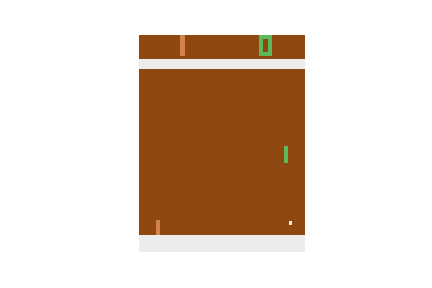
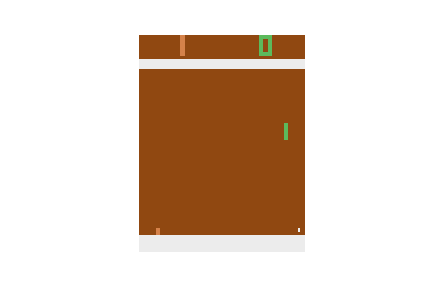
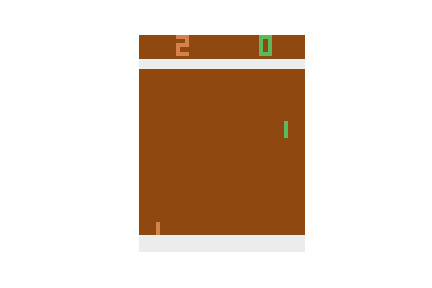
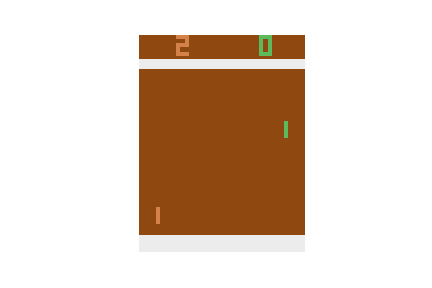
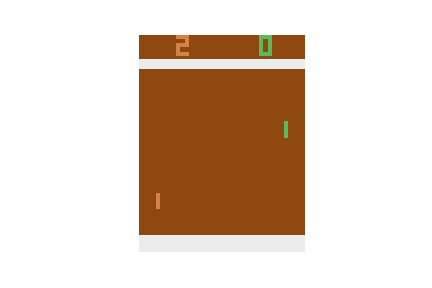
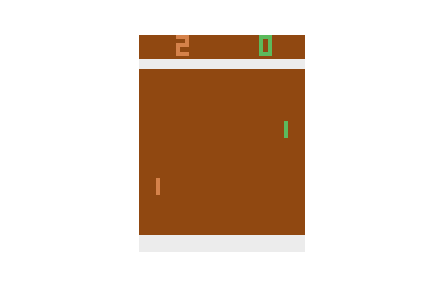
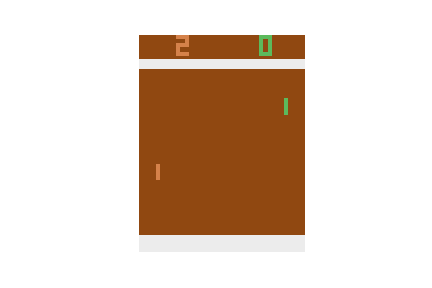
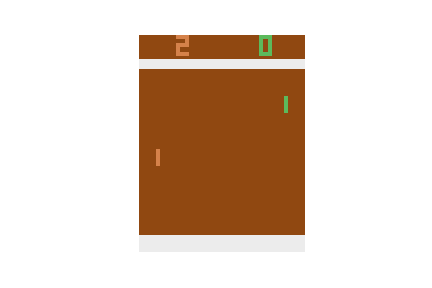
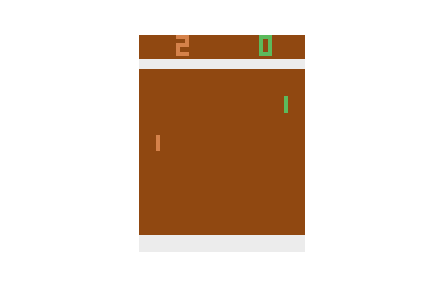
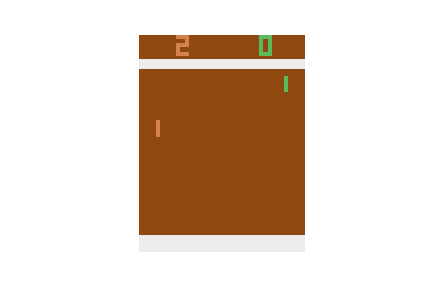
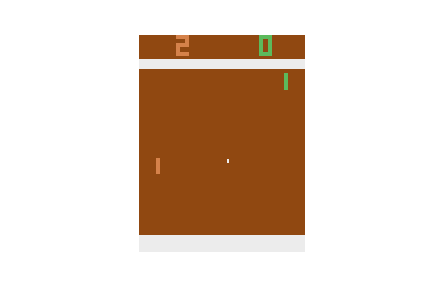
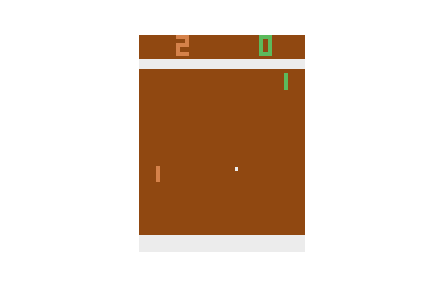
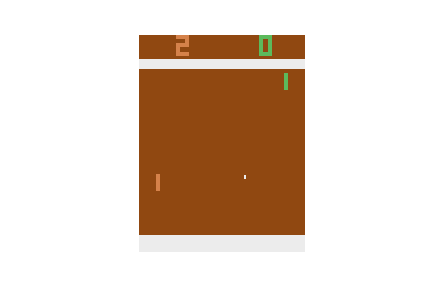
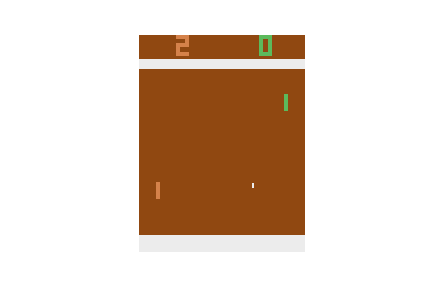
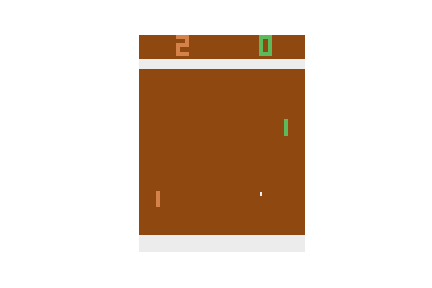
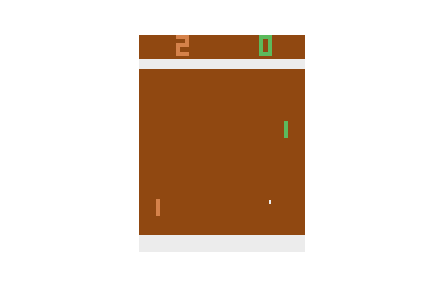
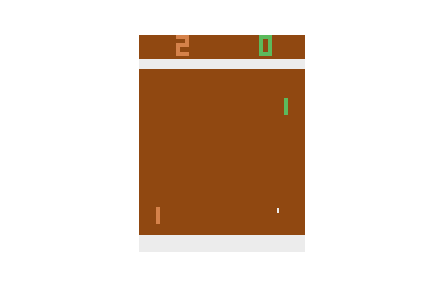
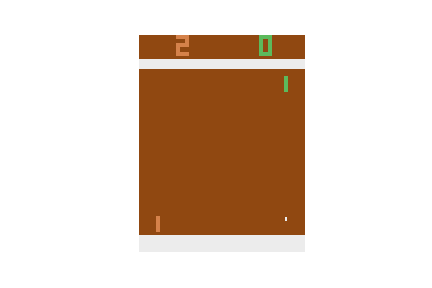
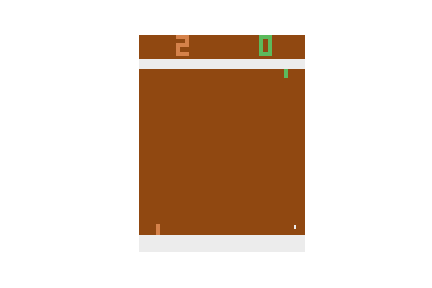
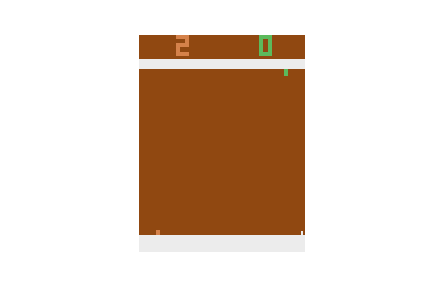
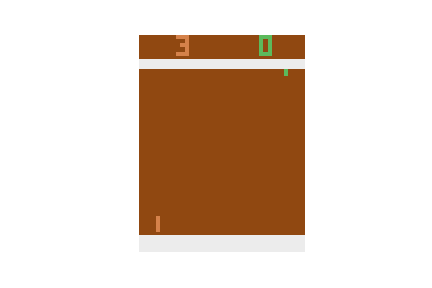
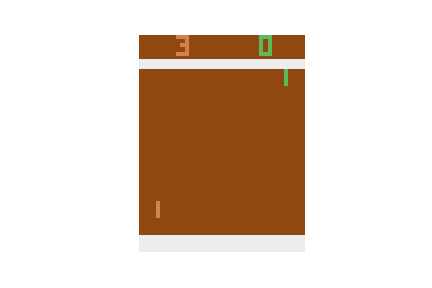
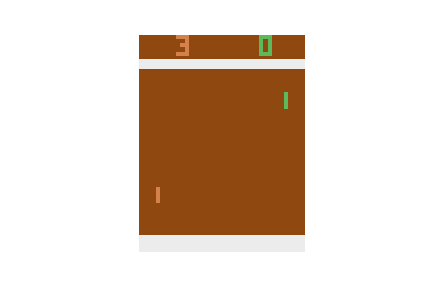
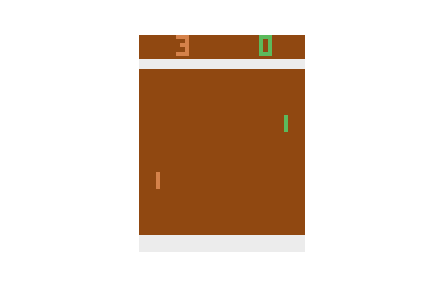
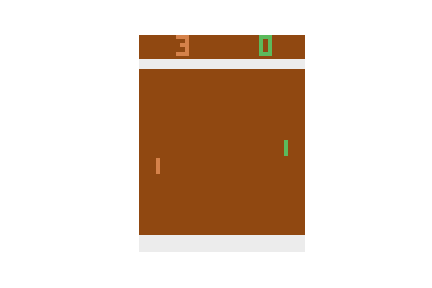
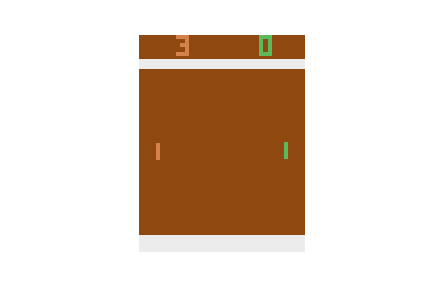
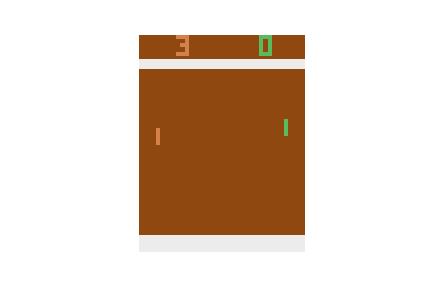
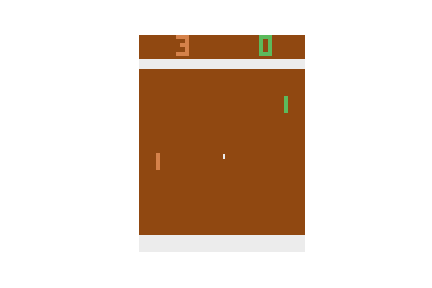
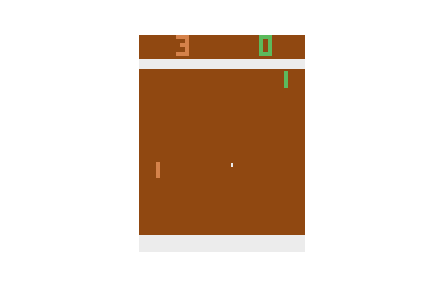
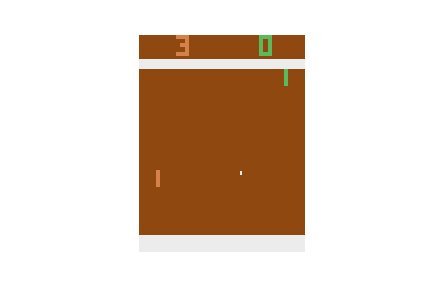
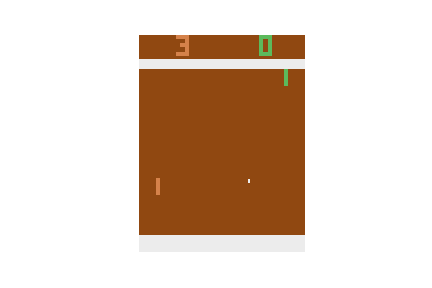
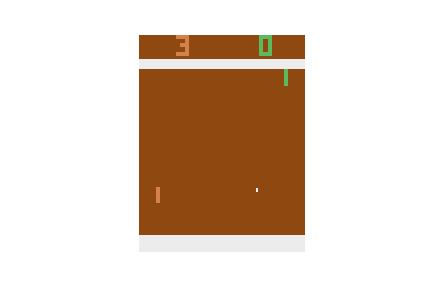
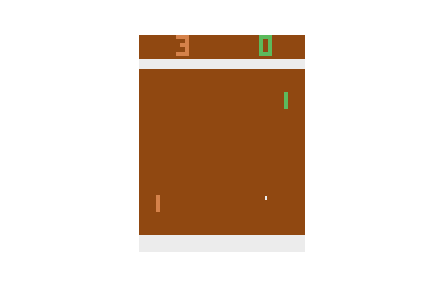
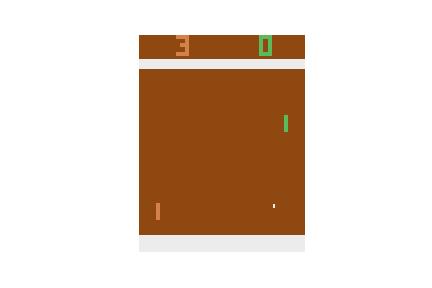
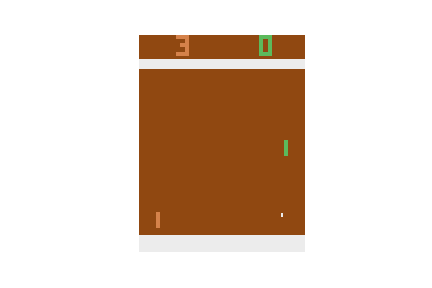
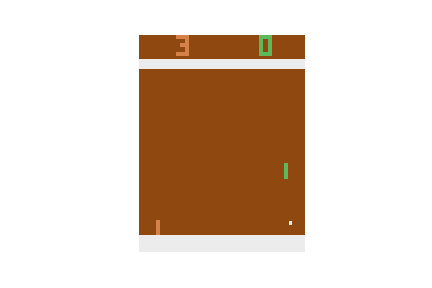
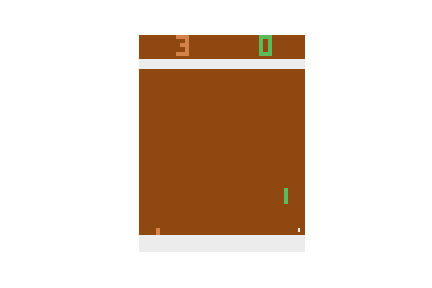
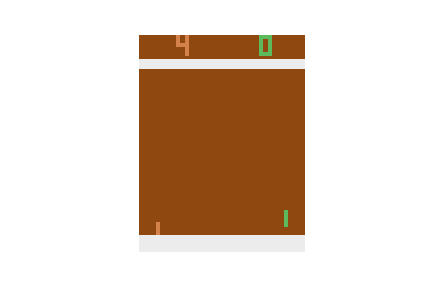
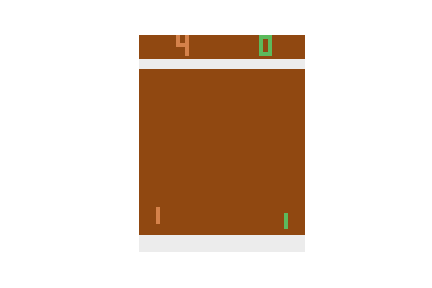
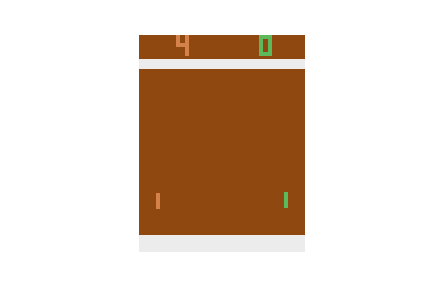
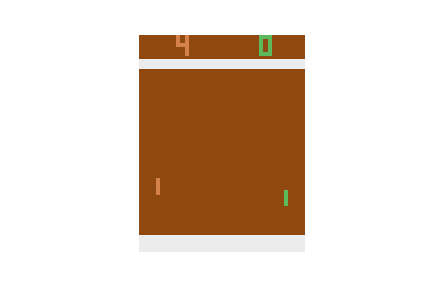
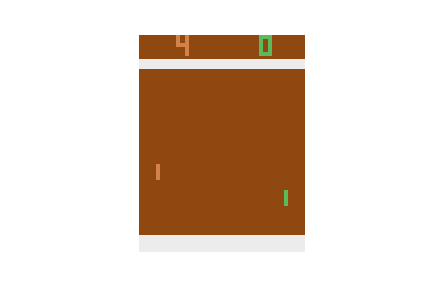
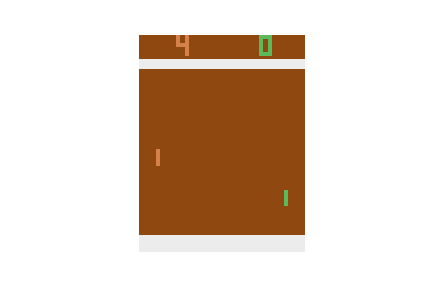
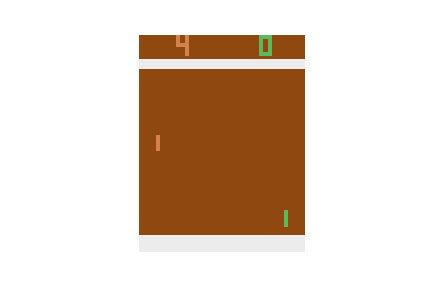
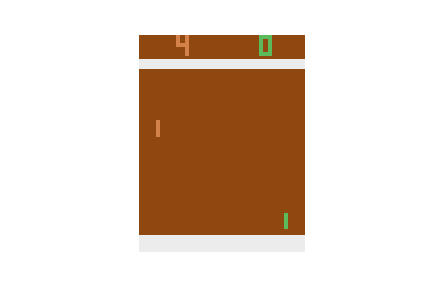
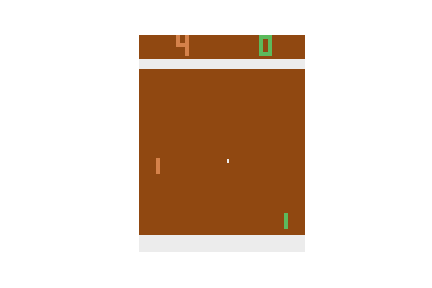
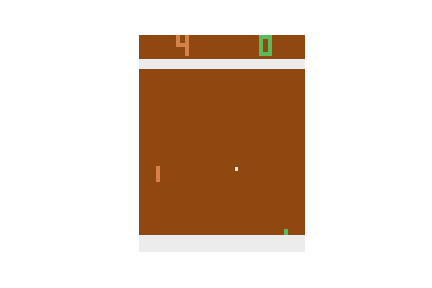
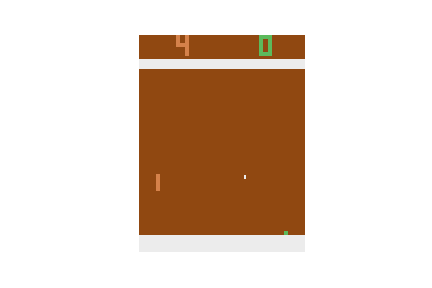
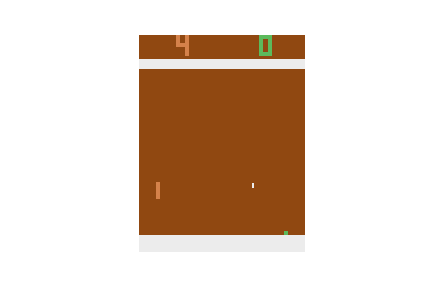
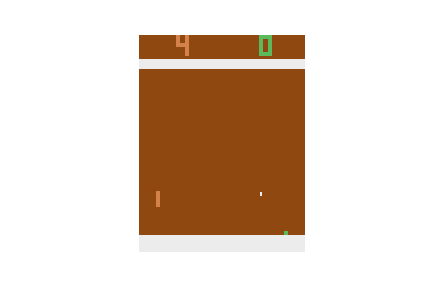
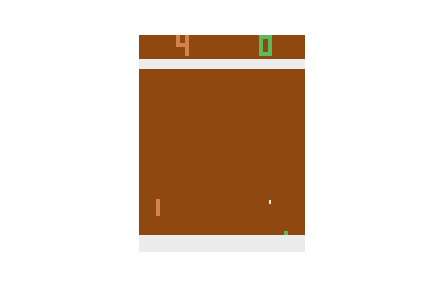
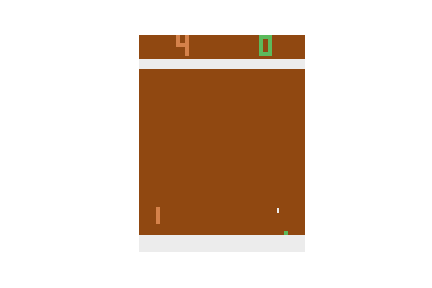
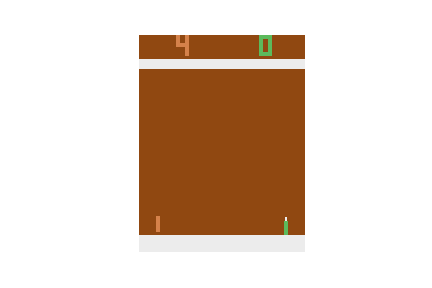
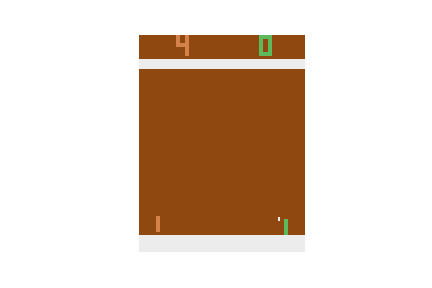
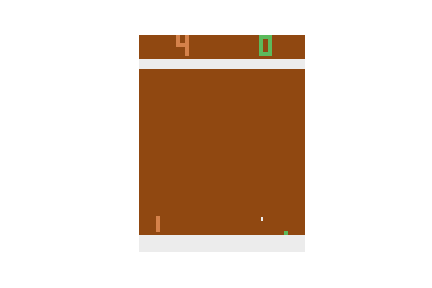
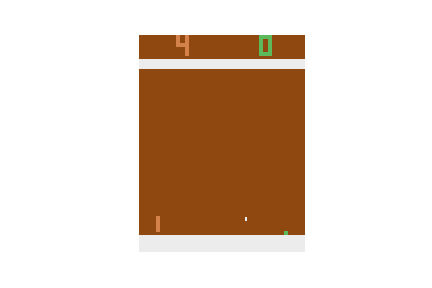
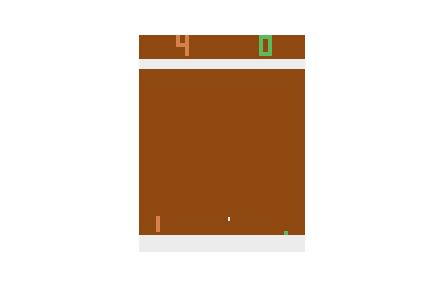
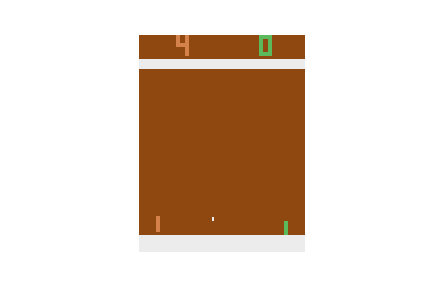
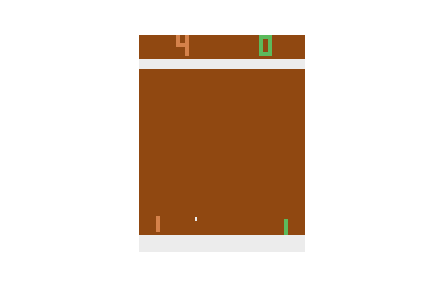
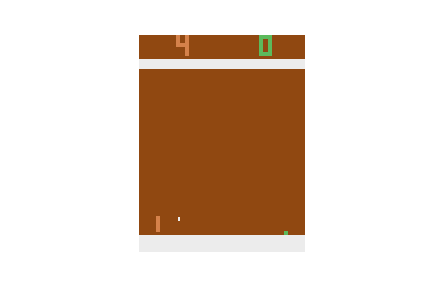
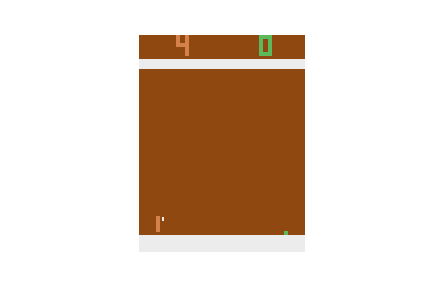
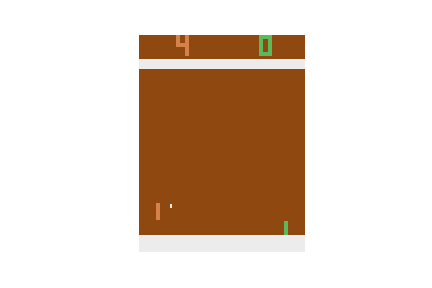
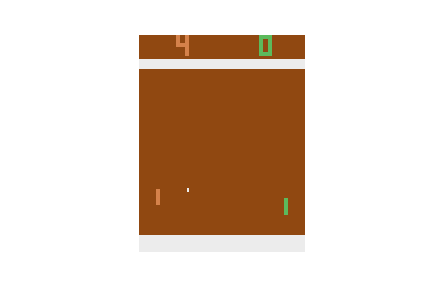
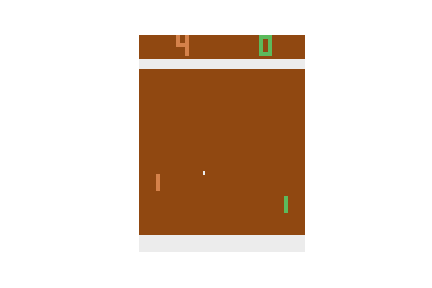
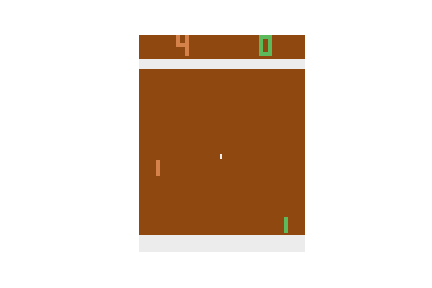
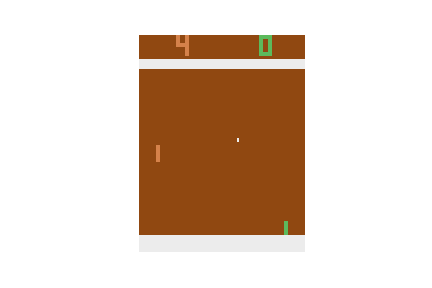
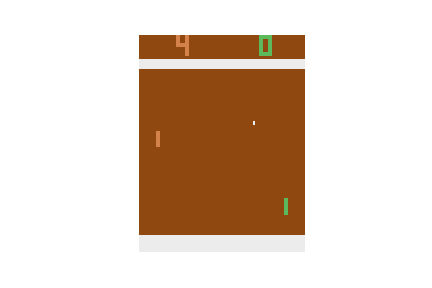
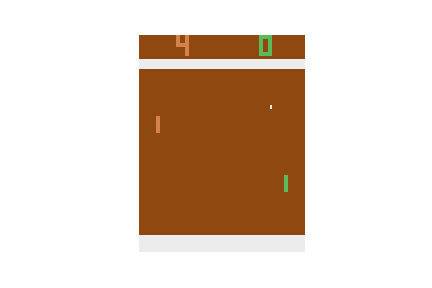
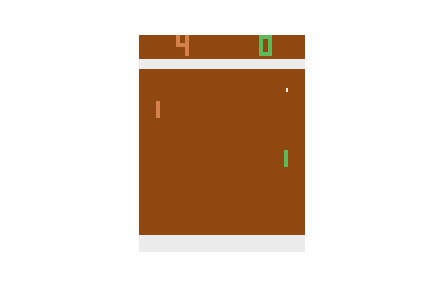
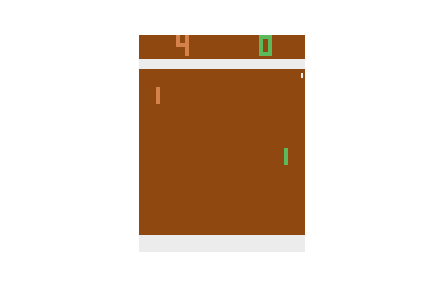
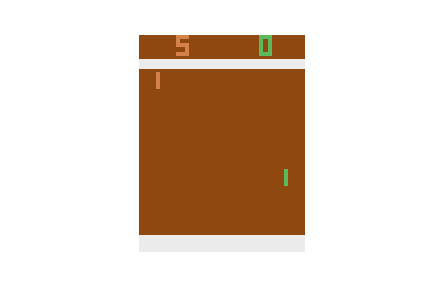
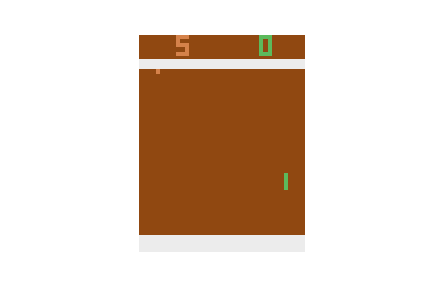
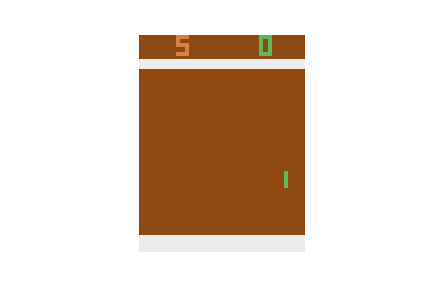
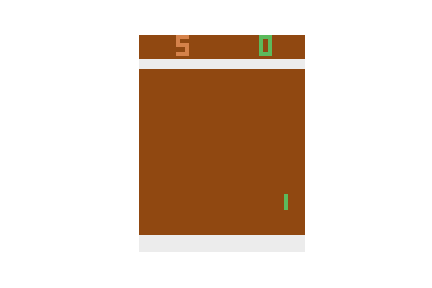
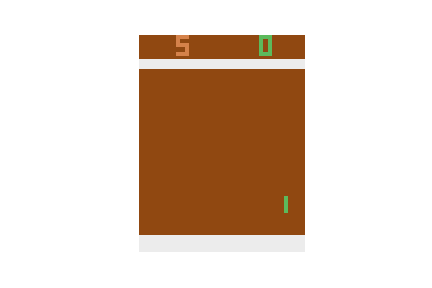
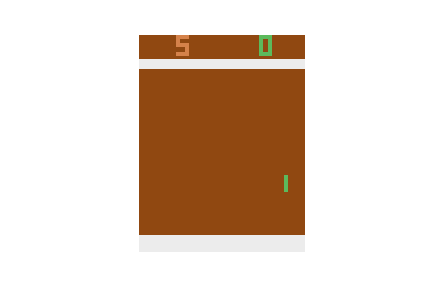
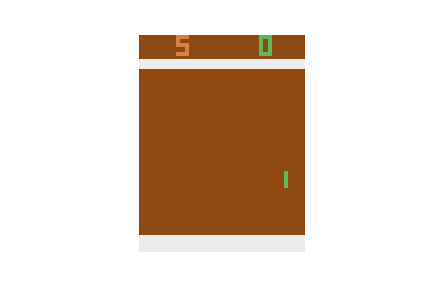
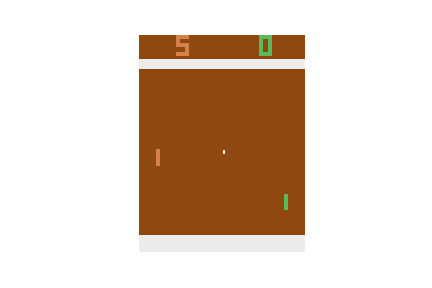
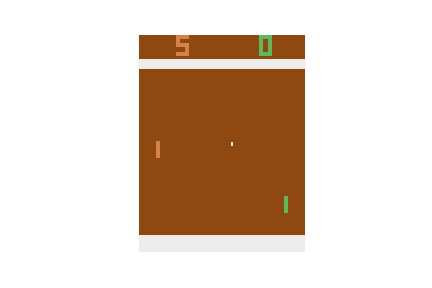
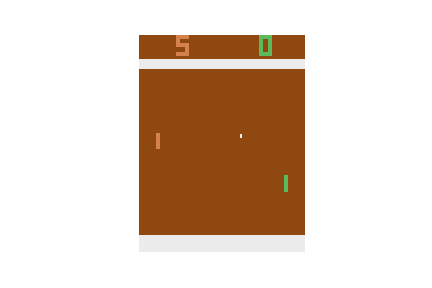
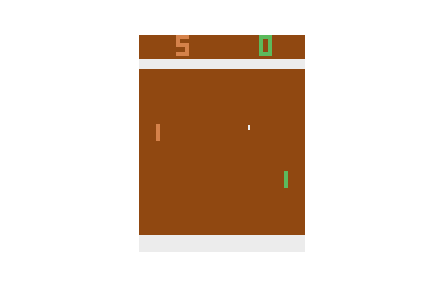
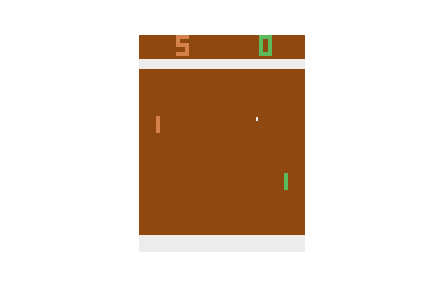
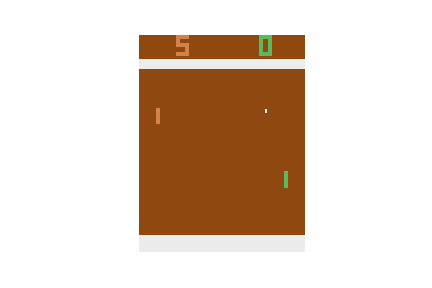
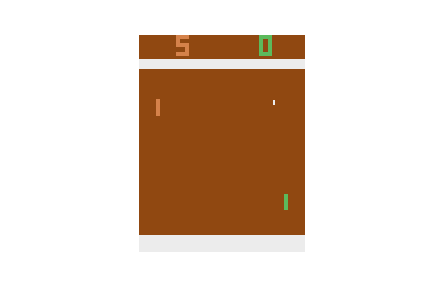
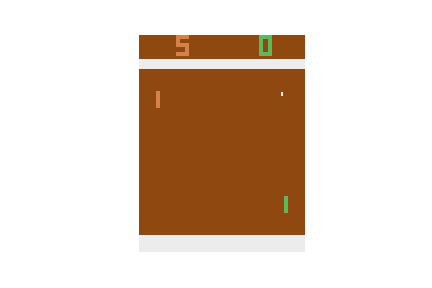
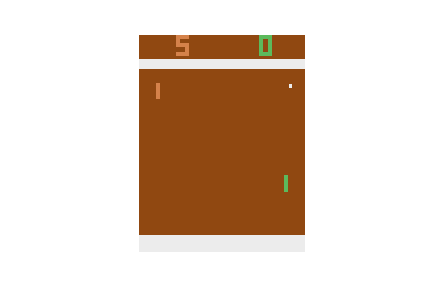
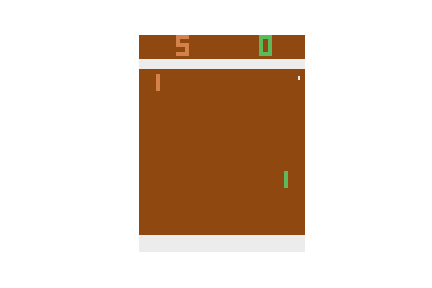
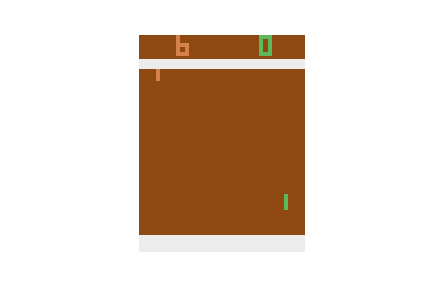
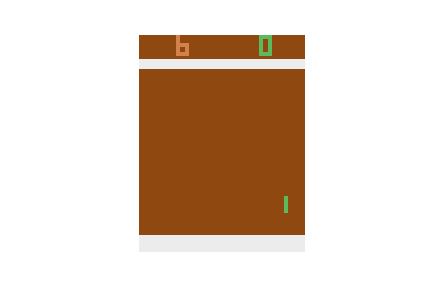
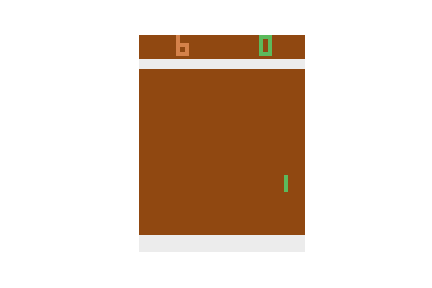
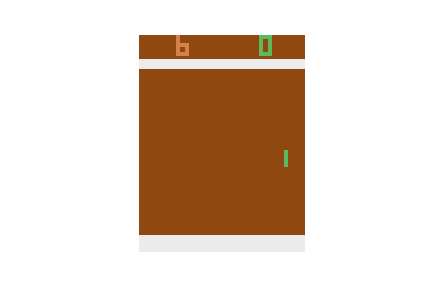
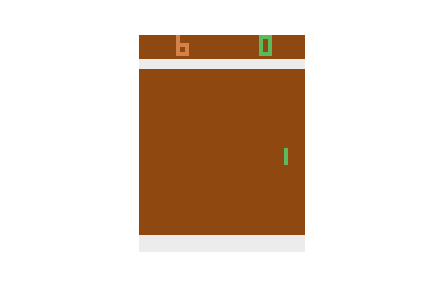
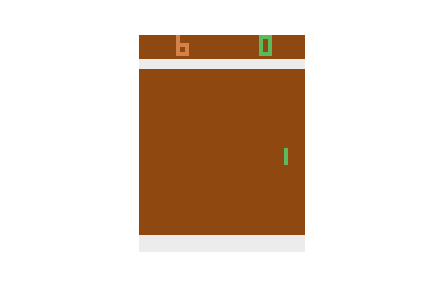
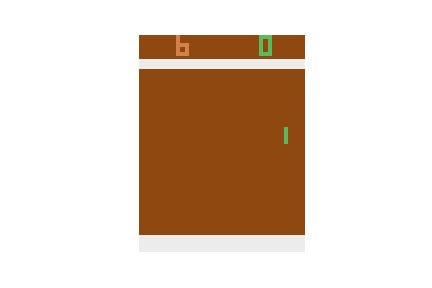
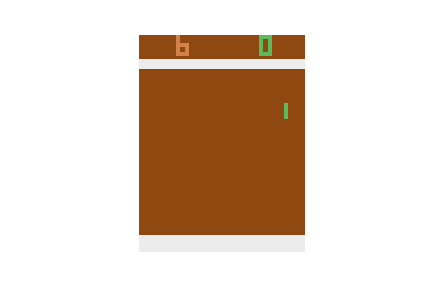
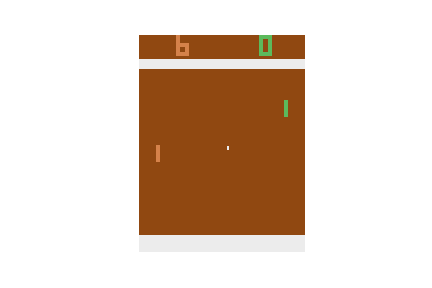
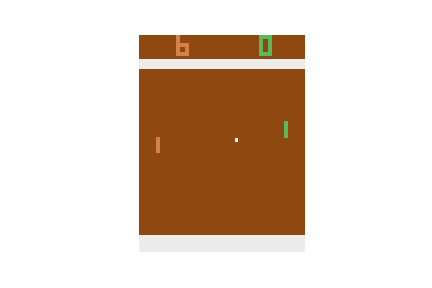
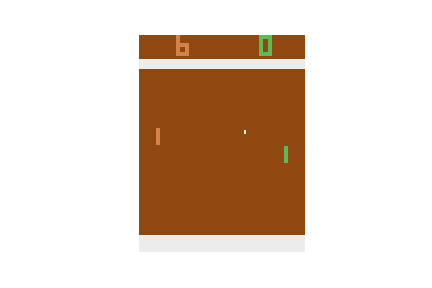
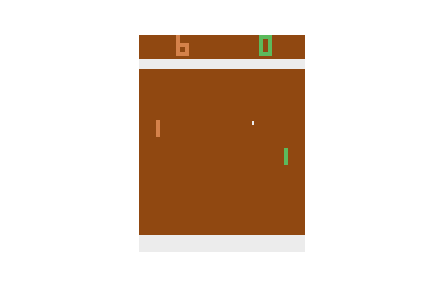
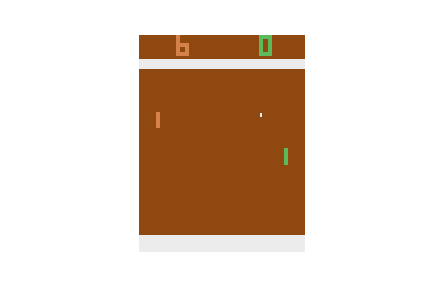
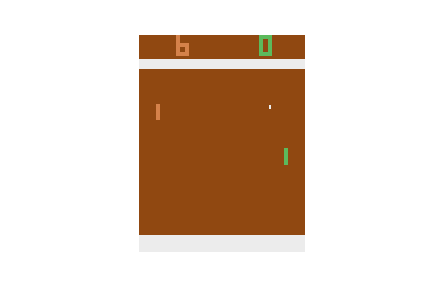
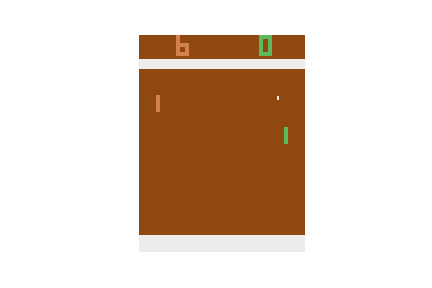
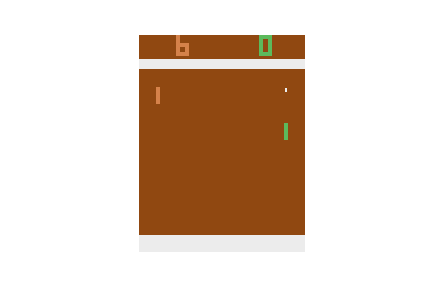
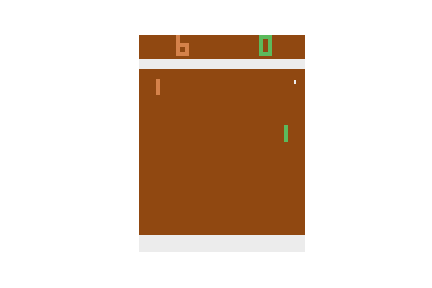
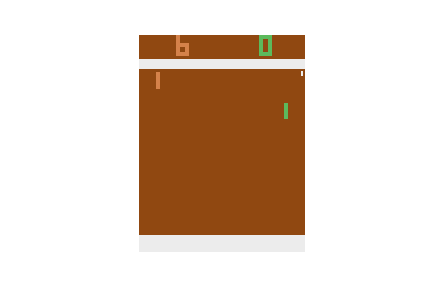
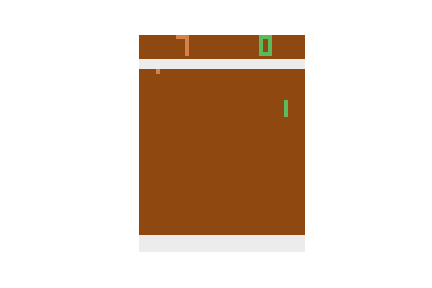
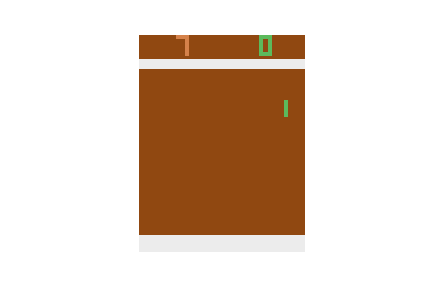
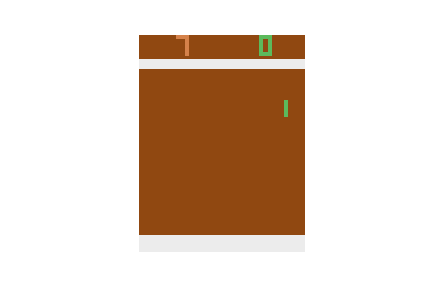
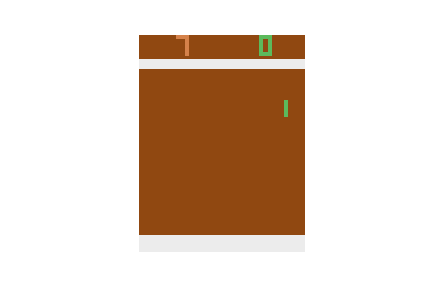
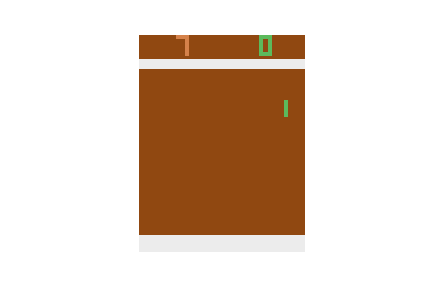
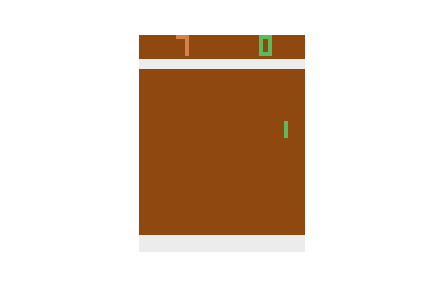
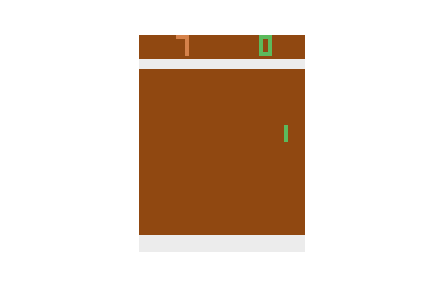
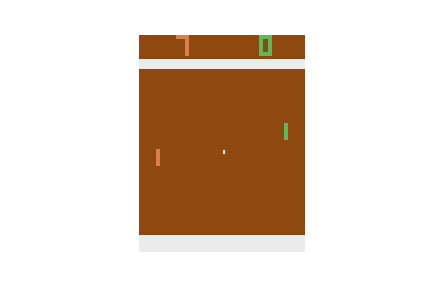
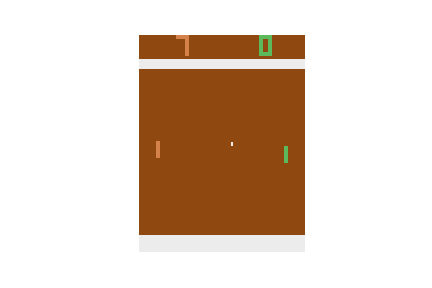
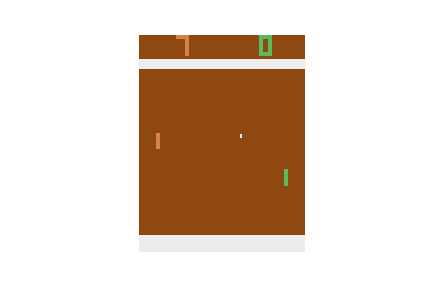
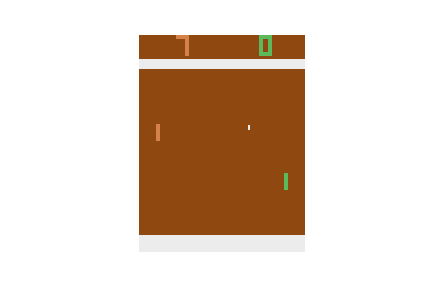
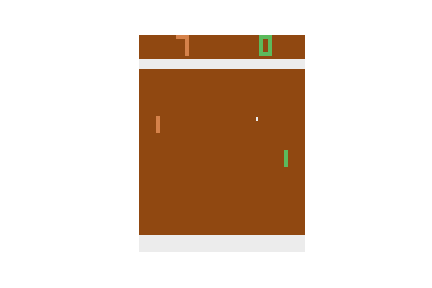
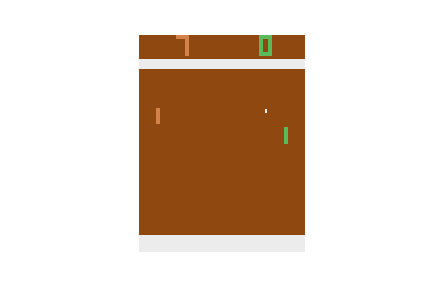
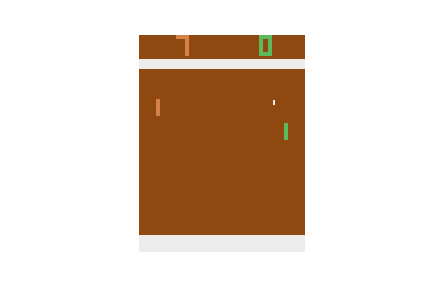
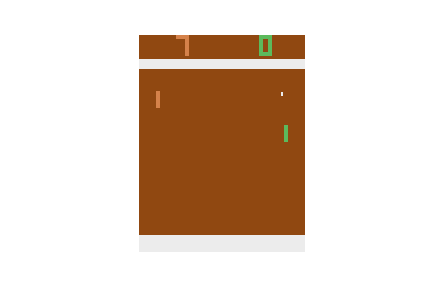
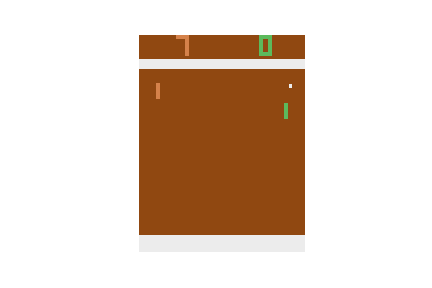
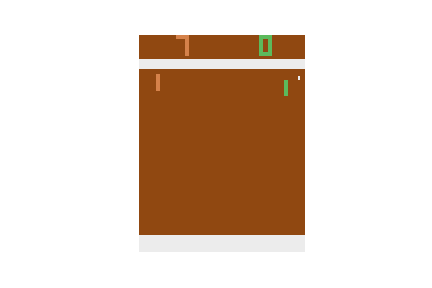
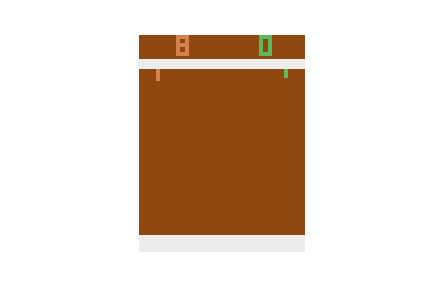
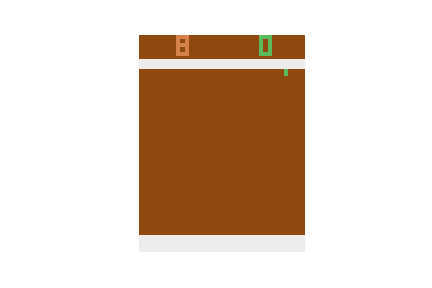
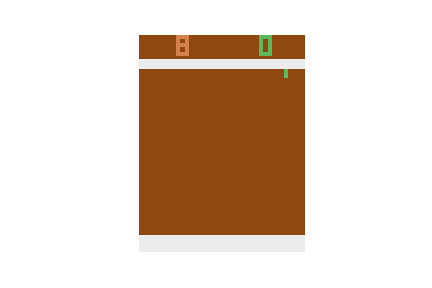
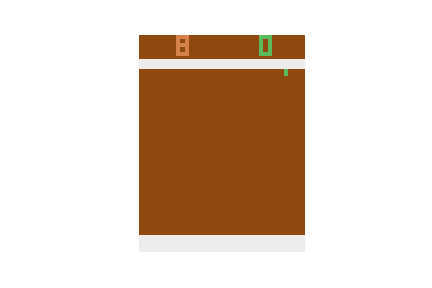
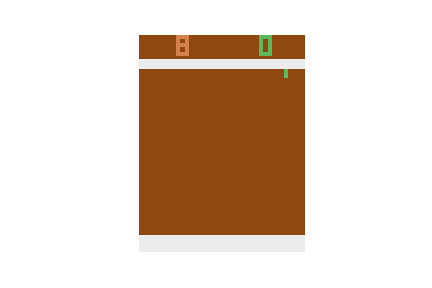
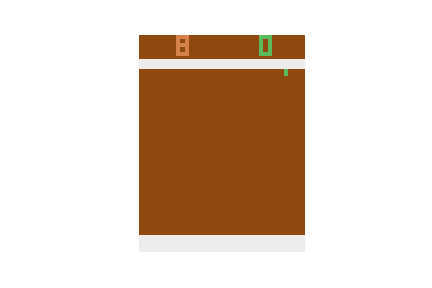
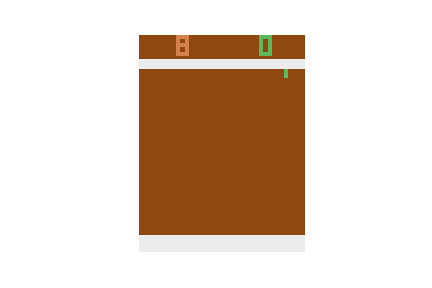
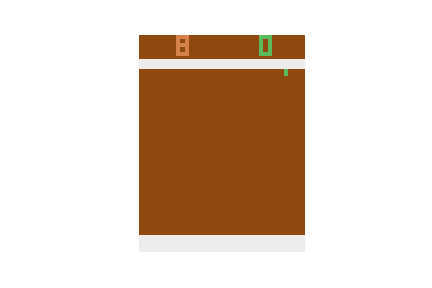
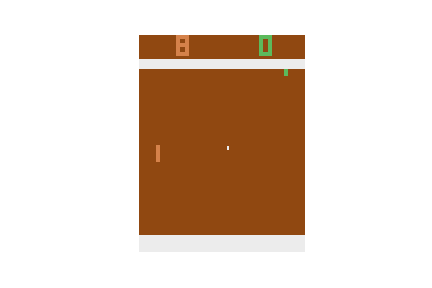
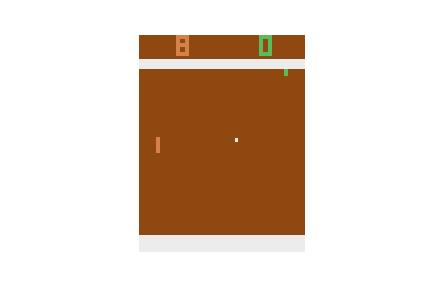
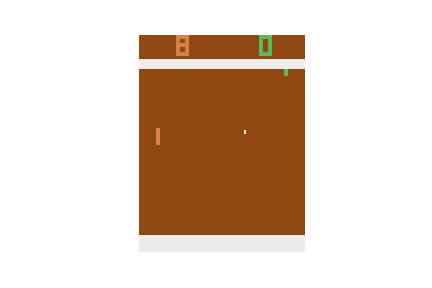
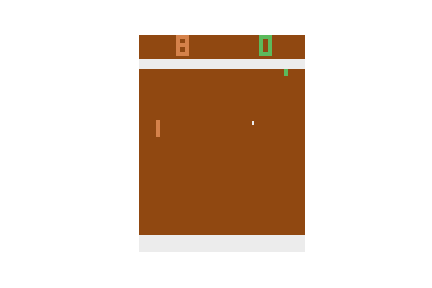
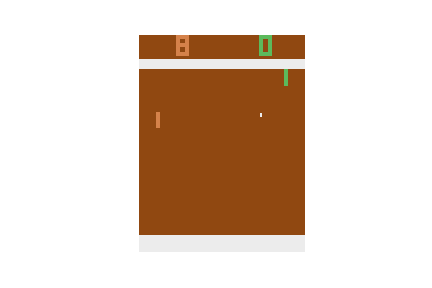
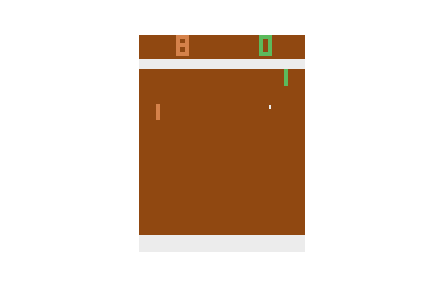
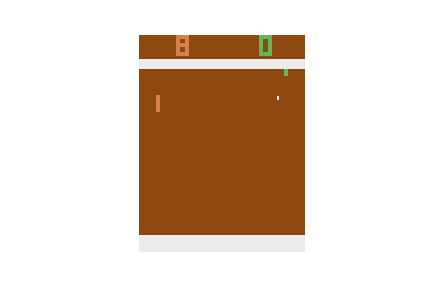
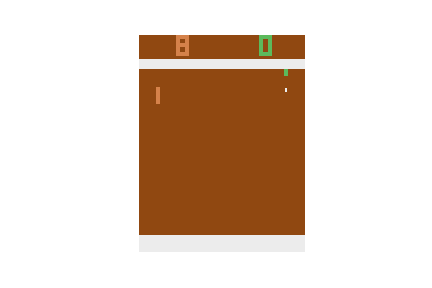
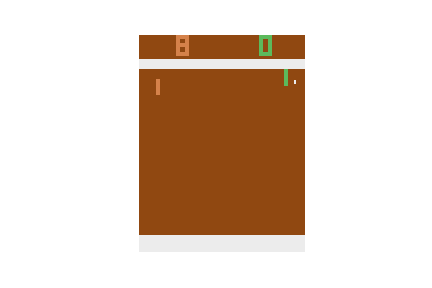
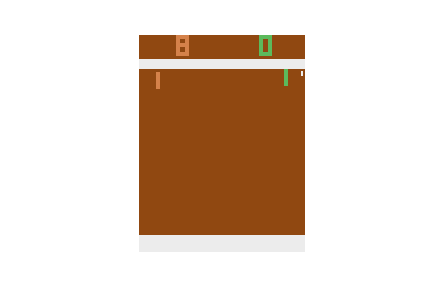
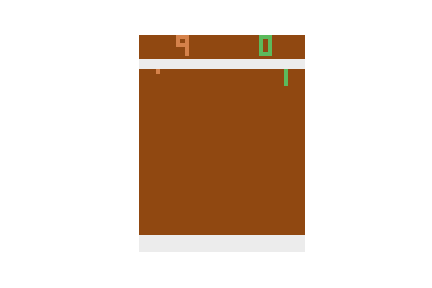
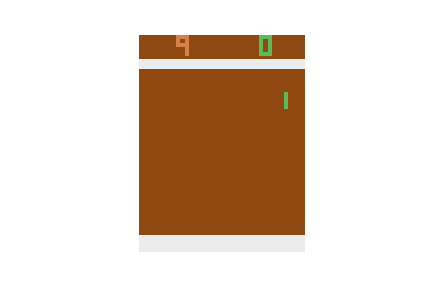
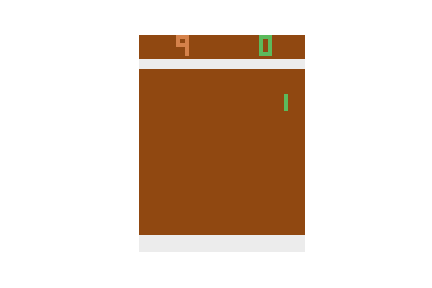
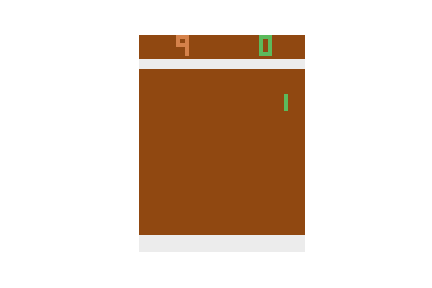

In [6]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [7]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    
    # Note: (tmax=500 and n=8)
    #    - old_probs shape is (tmax x n) 
    #    - states shape is (tmax x n x 2 x 80 x 80)  
    #    - actions shape is (tmax x n)
    #    - rewards shape is (tmax x n)

  
    # Prepare discount factors
    discounts = discount**np.arange(len(rewards))       
    # Compute discounted rewards
    discounted_rewards = np.asarray(rewards)*discounts[:,np.newaxis]
    # Convert discounted rewards to future rewards
    future_rewards = discounted_rewards[::-1].cumsum(axis=0)[::-1]
    
    # Normalize future rewards   
    mean = np.mean(future_rewards, axis=1)
    std = np.std(future_rewards, axis=1) + 1.0e-10
    norm_future_rewards = (future_rewards - mean[:, np.newaxis]) / std[:, np.newaxis]  
    
    # Convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    norm_future_rewards = torch.tensor(norm_future_rewards, dtype=torch.float, device=device)

    # convert states to policy probabilities
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    ratio = new_probs/old_probs

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    # clipped ratio
    clipped_ratio = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*norm_future_rewards, clipped_ratio*norm_future_rewards)

    return torch.mean(clipped_surrogate + beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [8]:
# Install Progressbar
!pip install progressbar2
!conda install -y tqdm==4.11.2

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Solving environment: done

# All requested packages already installed.



In [9]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000 #500


# widget bar to display progress
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA(), '  ', pb.Timer() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=threads, seed=1234)

discount_rate = .995 #.99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
        #L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
        #                                  epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

training loop:   2% |                   | ETA:   0:55:11  Elapsed Time: 0:01:07

Episode: 20, score: -14.875000
[-16. -16. -16. -13. -13. -16. -13. -16.]


training loop:   4% |                   | ETA:   0:52:35  Elapsed Time: 0:02:11

Episode: 40, score: -15.125000
[-13. -16. -15. -14. -15. -16. -16. -16.]


training loop:   6% |#                  | ETA:   0:50:57  Elapsed Time: 0:03:15

Episode: 60, score: -13.500000
[-14. -15. -11. -17. -12.  -9. -16. -14.]


training loop:   8% |#                  | ETA:   0:49:42  Elapsed Time: 0:04:19

Episode: 80, score: -14.500000
[-16. -14. -10. -16. -12. -16. -16. -16.]


training loop:  10% |#                  | ETA:   0:48:28  Elapsed Time: 0:05:23

Episode: 100, score: -14.375000
[-14. -15. -16. -14. -15. -13. -14. -14.]


training loop:  12% |##                 | ETA:   0:47:11  Elapsed Time: 0:06:26

Episode: 120, score: -12.875000
[-10. -15. -15. -14.  -8. -14. -14. -13.]


training loop:  14% |##                 | ETA:   0:46:02  Elapsed Time: 0:07:29

Episode: 140, score: -12.000000
[-11. -12. -15. -11. -12. -11. -12. -12.]


training loop:  16% |###                | ETA:   0:44:59  Elapsed Time: 0:08:34

Episode: 160, score: -10.125000
[ -8. -12. -13. -11.  -6. -12. -13.  -6.]


training loop:  18% |###                | ETA:   0:43:54  Elapsed Time: 0:09:38

Episode: 180, score: -10.625000
[-13.  -8. -11. -12. -13. -11. -11.  -6.]


training loop:  20% |###                | ETA:   0:42:46  Elapsed Time: 0:10:41

Episode: 200, score: -9.125000
[-11. -12.  -2. -13. -13.  -5. -11.  -6.]


training loop:  22% |####               | ETA:   0:41:37  Elapsed Time: 0:11:44

Episode: 220, score: -6.000000
[ -5. -10.  -6. -10.  -3.  -6.  -6.  -2.]


training loop:  24% |####               | ETA:   0:40:34  Elapsed Time: 0:12:48

Episode: 240, score: -6.375000
[ -7.  -4.  -7. -12.  -9.  -2.  -7.  -3.]


training loop:  26% |####               | ETA:   0:39:30  Elapsed Time: 0:13:52

Episode: 260, score: -4.250000
[-3. -5. -7. -7. -5.  0. -6. -1.]


training loop:  28% |#####              | ETA:   0:38:25  Elapsed Time: 0:14:56

Episode: 280, score: -1.375000
[-1.  0. -1.  0. -1. -3. -4. -1.]


training loop:  30% |#####              | ETA:   0:37:21  Elapsed Time: 0:16:00

Episode: 300, score: -1.625000
[-7.  0. -1. -3. -1.  0.  0. -1.]


training loop:  32% |######             | ETA:   0:36:17  Elapsed Time: 0:17:04

Episode: 320, score: -0.625000
[ 3. -1.  2. -2.  0.  0.  0. -7.]


training loop:  34% |######             | ETA:   0:35:12  Elapsed Time: 0:18:08

Episode: 340, score: 1.125000
[ 2.  2.  3.  3.  2. -3.  1. -1.]


training loop:  36% |######             | ETA:   0:34:06  Elapsed Time: 0:19:11

Episode: 360, score: 0.750000
[ 0.  0.  3. -2.  3.  3. -1.  0.]


training loop:  38% |#######            | ETA:   0:33:02  Elapsed Time: 0:20:14

Episode: 380, score: 1.375000
[ 3.  2.  3.  3.  3.  0. -1. -2.]


training loop:  40% |#######            | ETA:   0:31:58  Elapsed Time: 0:21:19

Episode: 400, score: 2.000000
[ 3. -2.  3.  3.  3.  0.  3.  3.]


training loop:  42% |#######            | ETA:   0:30:55  Elapsed Time: 0:22:23

Episode: 420, score: 2.875000
[3. 3. 2. 3. 3. 3. 3. 3.]


training loop:  44% |########           | ETA:   0:29:52  Elapsed Time: 0:23:28

Episode: 440, score: 3.125000
[3. 3. 2. 3. 3. 3. 3. 5.]


training loop:  46% |########           | ETA:   0:28:47  Elapsed Time: 0:24:31

Episode: 460, score: 3.000000
[ 2.  5. -4.  5.  3.  3.  5.  5.]


training loop:  48% |#########          | ETA:   0:27:43  Elapsed Time: 0:25:35

Episode: 480, score: 4.375000
[5. 5. 5. 5. 5. 5. 0. 5.]


training loop:  50% |#########          | ETA:   0:26:39  Elapsed Time: 0:26:39

Episode: 500, score: 4.500000
[5. 5. 5. 3. 3. 5. 5. 5.]


training loop:  52% |#########          | ETA:   0:25:35  Elapsed Time: 0:27:43

Episode: 520, score: 3.500000
[5. 5. 0. 5. 5. 5. 1. 2.]


training loop:  54% |##########         | ETA:   0:24:31  Elapsed Time: 0:28:47

Episode: 540, score: 4.750000
[5. 5. 3. 5. 5. 5. 5. 5.]


training loop:  56% |##########         | ETA:   0:23:27  Elapsed Time: 0:29:51

Episode: 560, score: 4.625000
[7. 5. 5. 5. 5. 2. 3. 5.]


training loop:  57% |###########        | ETA:   0:22:23  Elapsed Time: 0:30:55

Episode: 580, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


training loop:  60% |###########        | ETA:   0:21:19  Elapsed Time: 0:31:59

Episode: 600, score: 5.250000
[5. 5. 5. 5. 5. 5. 7. 5.]


training loop:  62% |###########        | ETA:   0:20:15  Elapsed Time: 0:33:02

Episode: 620, score: 3.875000
[ 5.  4.  5.  5.  5. -5.  5.  7.]


training loop:  64% |############       | ETA:   0:19:11  Elapsed Time: 0:34:06

Episode: 640, score: 4.625000
[5. 5. 5. 2. 5. 5. 5. 5.]


training loop:  66% |############       | ETA:   0:18:06  Elapsed Time: 0:35:09

Episode: 660, score: 4.125000
[-2.  5.  5.  5.  3.  7.  5.  5.]


training loop:  68% |############       | ETA:   0:17:02  Elapsed Time: 0:36:12

Episode: 680, score: 5.000000
[5. 5. 3. 5. 5. 5. 7. 5.]


training loop:  70% |#############      | ETA:   0:15:58  Elapsed Time: 0:37:16

Episode: 700, score: 3.625000
[ 5.  5.  7.  5. -1.  5.  5. -2.]


training loop:  72% |#############      | ETA:   0:14:54  Elapsed Time: 0:38:20

Episode: 720, score: 5.500000
[5. 5. 5. 7. 5. 7. 5. 5.]


training loop:  74% |##############     | ETA:   0:13:50  Elapsed Time: 0:39:24

Episode: 740, score: 5.250000
[5. 5. 5. 5. 5. 5. 7. 5.]


training loop:  76% |##############     | ETA:   0:12:46  Elapsed Time: 0:40:28

Episode: 760, score: 5.500000
[3. 5. 5. 7. 7. 7. 5. 5.]


training loop:  78% |##############     | ETA:   0:11:42  Elapsed Time: 0:41:32

Episode: 780, score: 5.500000
[5. 7. 5. 5. 5. 5. 7. 5.]


training loop:  80% |###############    | ETA:   0:10:39  Elapsed Time: 0:42:36

Episode: 800, score: 5.250000
[3. 5. 5. 5. 7. 5. 5. 7.]


training loop:  82% |###############    | ETA:   0:09:35  Elapsed Time: 0:43:39

Episode: 820, score: 4.625000
[2. 5. 5. 5. 5. 5. 5. 5.]


training loop:  84% |###############    | ETA:   0:08:31  Elapsed Time: 0:44:43

Episode: 840, score: 5.250000
[5. 5. 5. 5. 5. 5. 7. 5.]


training loop:  86% |################   | ETA:   0:07:27  Elapsed Time: 0:45:46

Episode: 860, score: 4.750000
[3. 5. 5. 5. 5. 5. 5. 5.]


training loop:  88% |################   | ETA:   0:06:23  Elapsed Time: 0:46:50

Episode: 880, score: 3.875000
[ 5.  3.  5. -2.  5.  5.  5.  5.]


training loop:  90% |#################  | ETA:   0:05:19  Elapsed Time: 0:47:52

Episode: 900, score: 3.875000
[ 5.  5.  5.  5.  3.  5. -2.  5.]


training loop:  92% |#################  | ETA:   0:04:15  Elapsed Time: 0:48:57

Episode: 920, score: 5.500000
[3. 5. 7. 5. 7. 5. 5. 7.]


training loop:  94% |#################  | ETA:   0:03:11  Elapsed Time: 0:50:03

Episode: 940, score: 5.750000
[5. 5. 7. 7. 5. 5. 7. 5.]


training loop:  96% |################## | ETA:   0:02:07  Elapsed Time: 0:51:06

Episode: 960, score: 5.500000
[5. 5. 5. 7. 7. 5. 5. 5.]


training loop:  98% |################## | ETA:   0:01:03  Elapsed Time: 0:52:09

Episode: 980, score: 5.250000
[5. 7. 5. 5. 5. 5. 5. 5.]


training loop: 100% |###################| Time:  0:53:14  Elapsed Time: 0:53:14


Episode: 1000, score: 5.500000
[5. 7. 5. 5. 7. 3. 5. 7.]


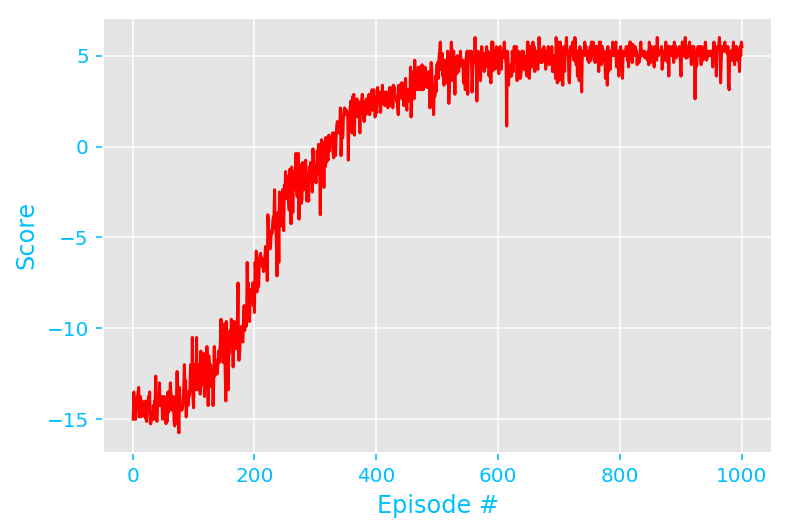

In [10]:
# Add-on : Enhanced Rewards plot
#plt.plot(mean_rewards)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='x', colors='deepskyblue')
ax.tick_params(axis='y', colors='deepskyblue')
plt.plot(np.arange(1, len(mean_rewards)+1), mean_rewards, color='red')
plt.ylabel('Score', color='deepskyblue')
plt.xlabel('Episode #', color='deepskyblue')
plt.show()


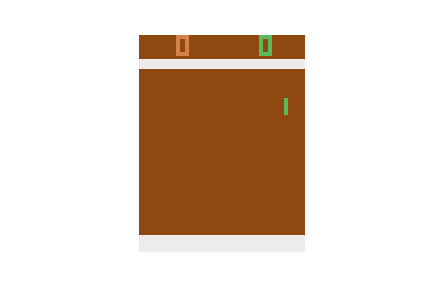
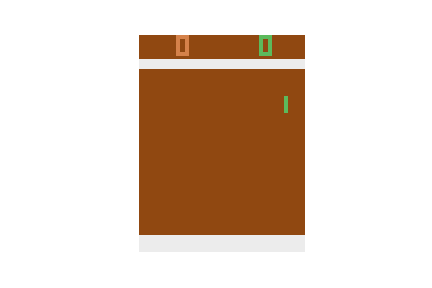
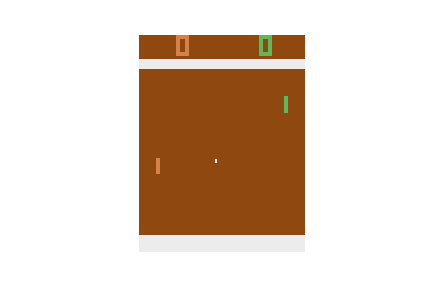
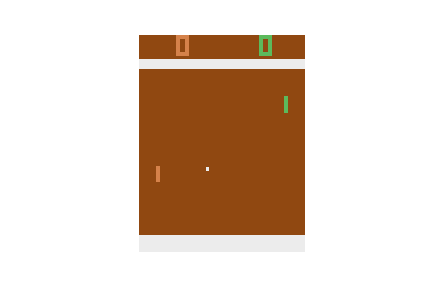
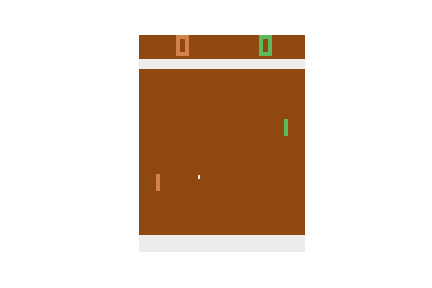
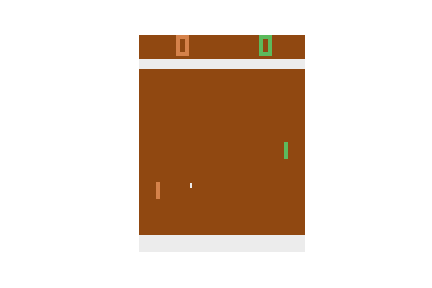
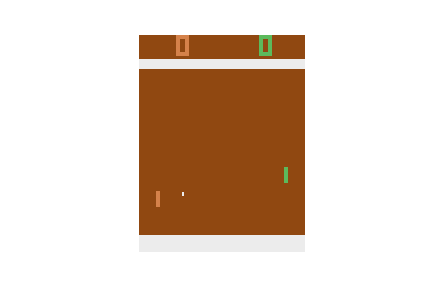
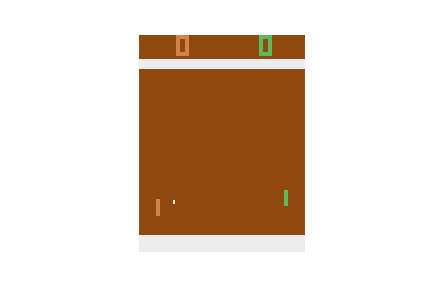
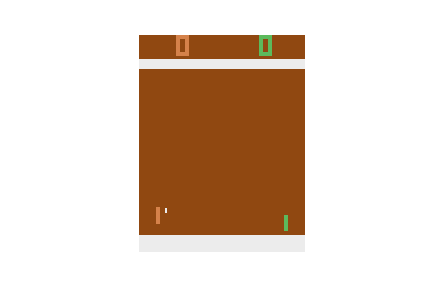
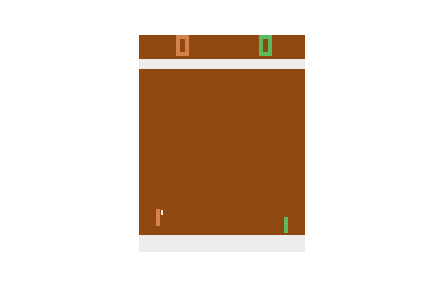
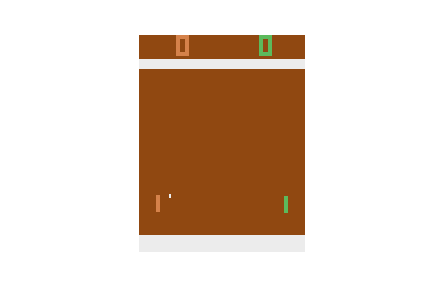
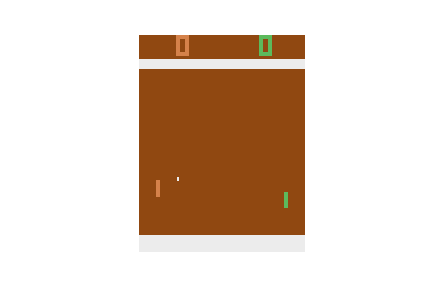
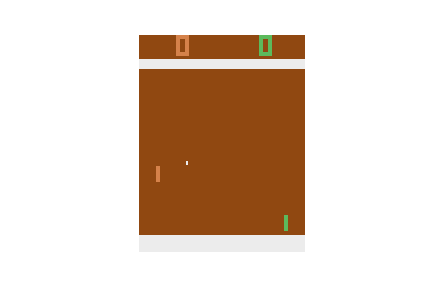
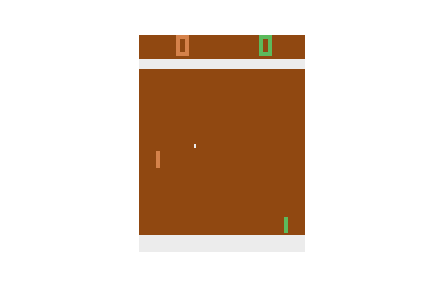
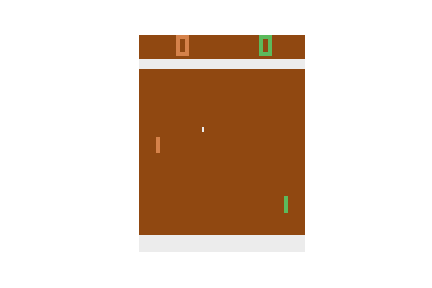
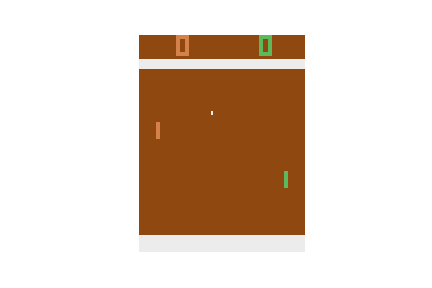
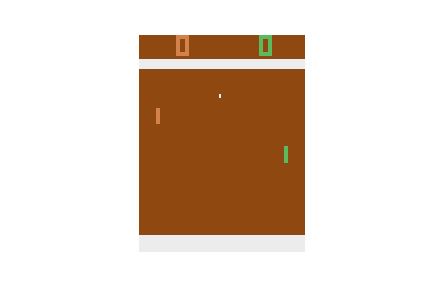
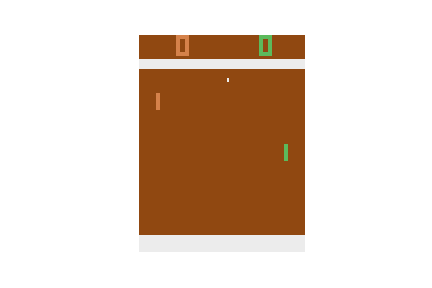
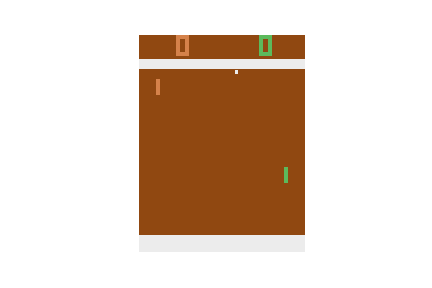
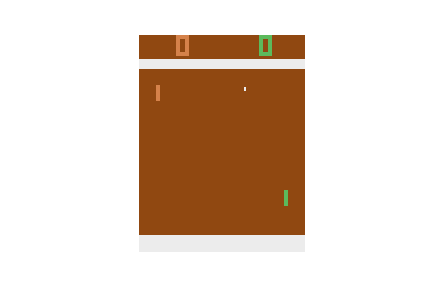
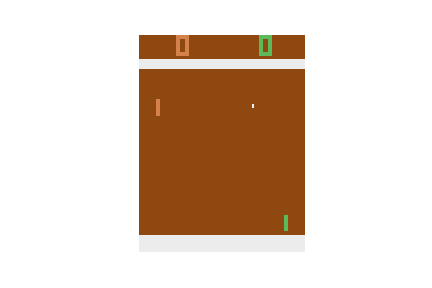
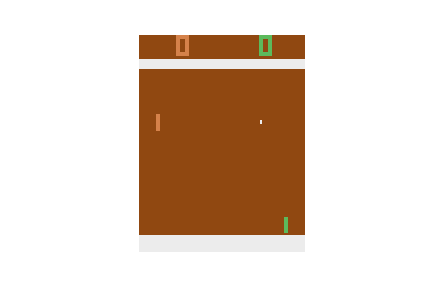
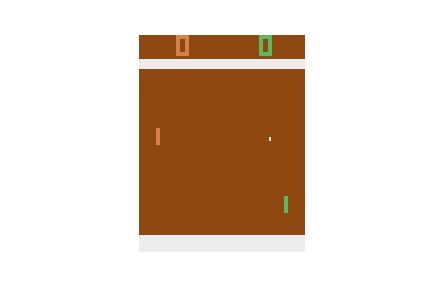
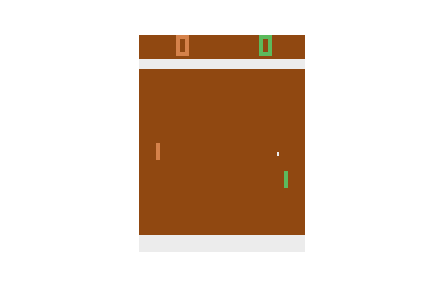
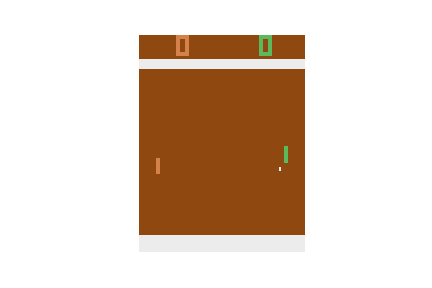
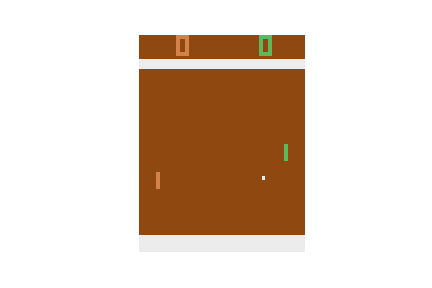
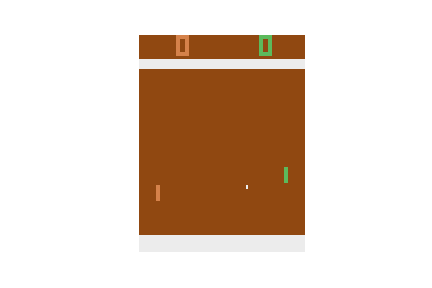
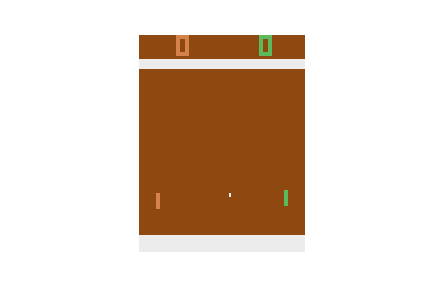
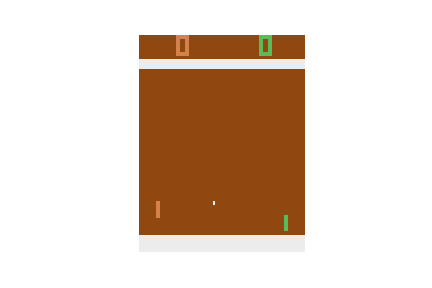
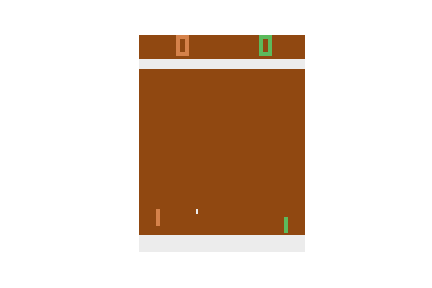
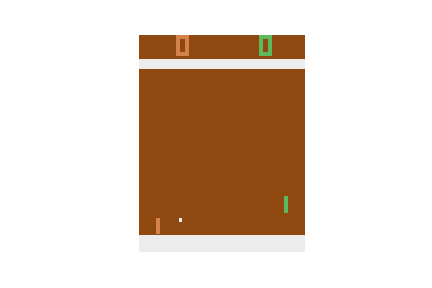
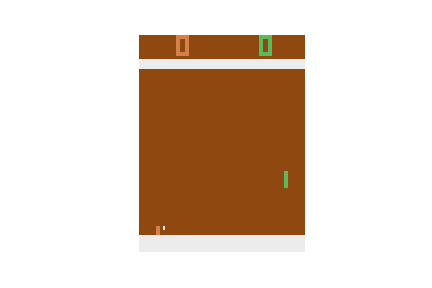
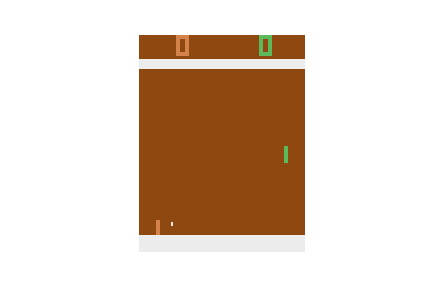
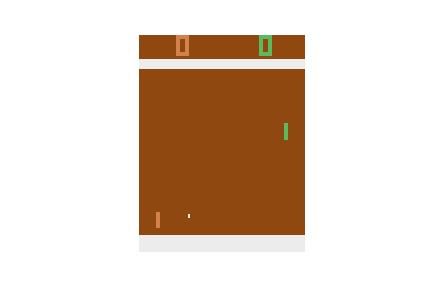
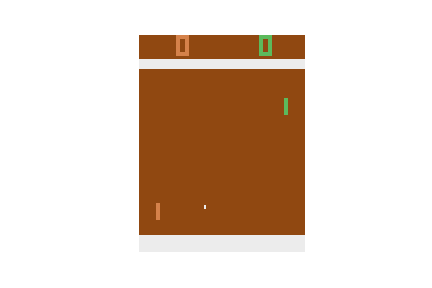
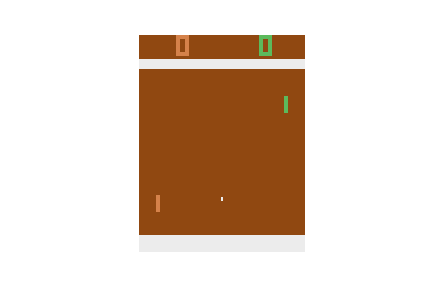
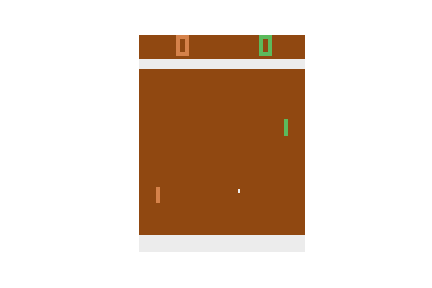
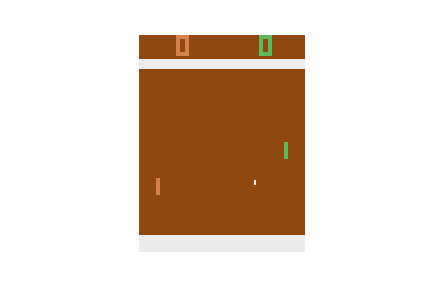
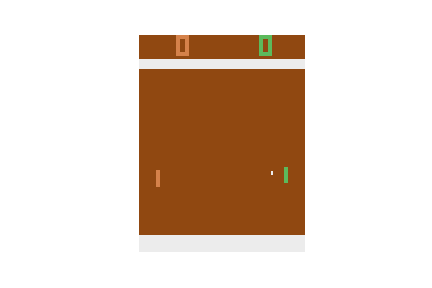
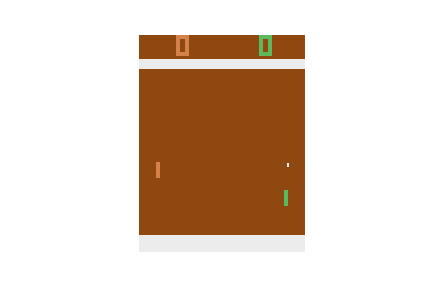
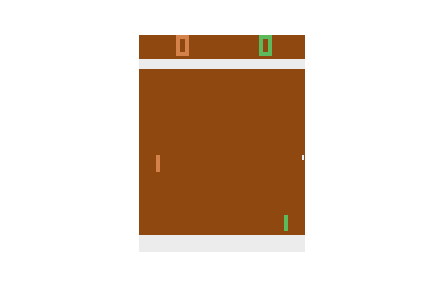
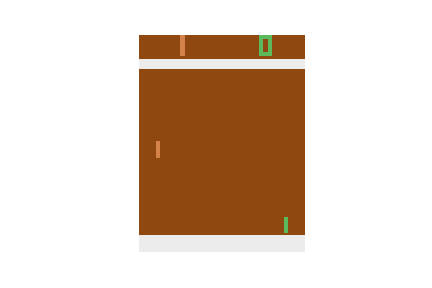
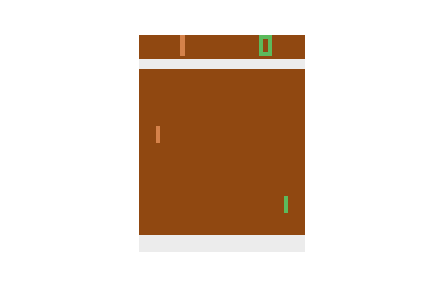
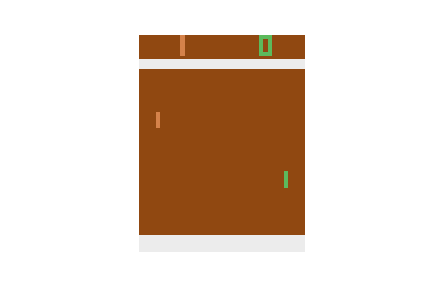
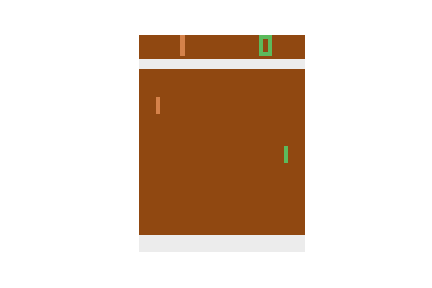
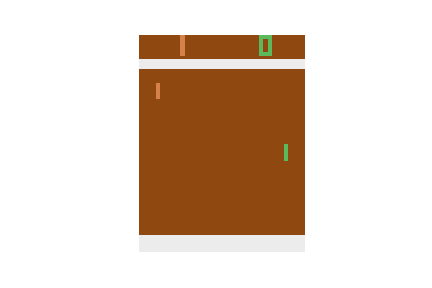
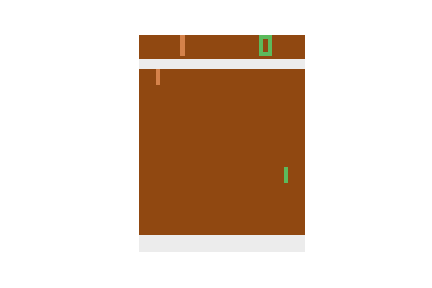
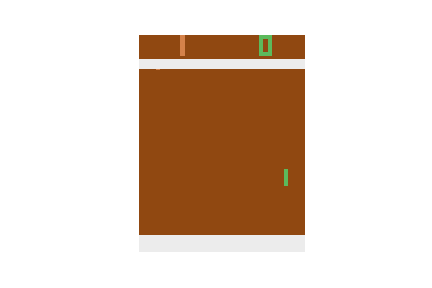
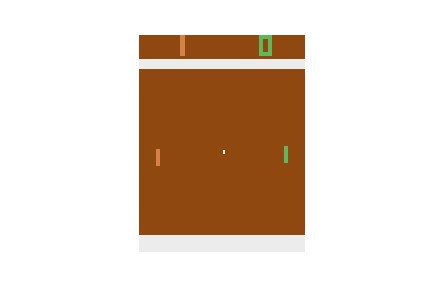
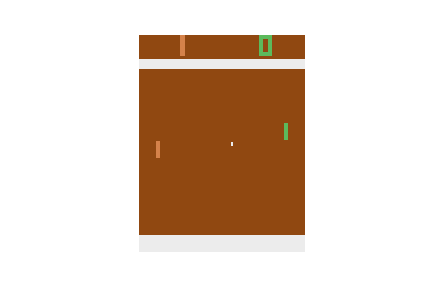
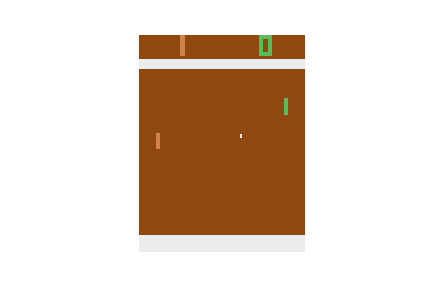
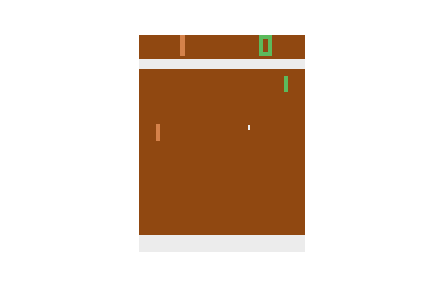
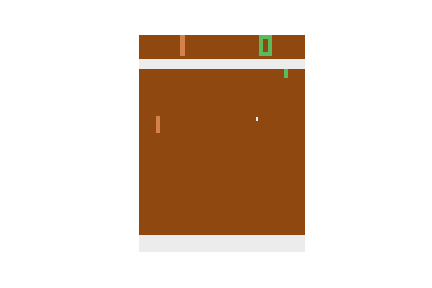
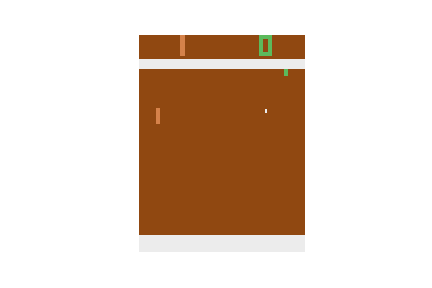
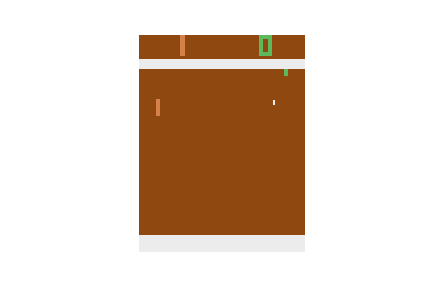
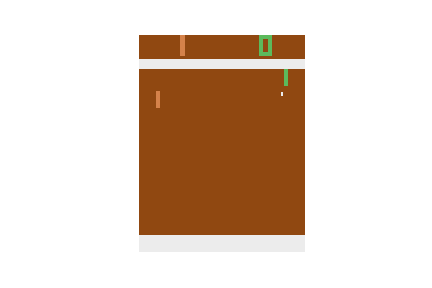
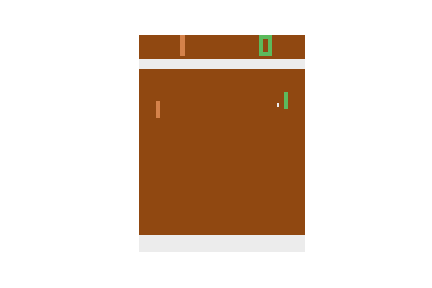
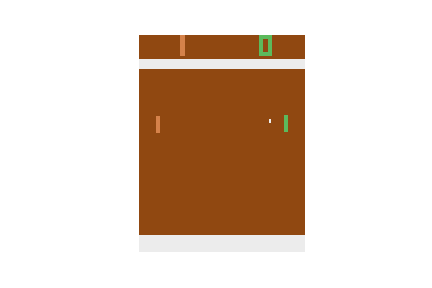
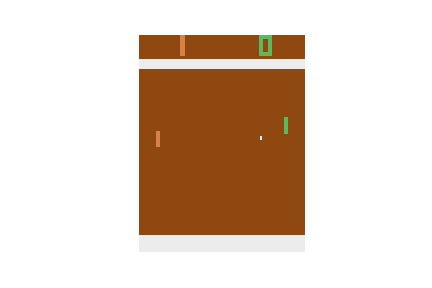
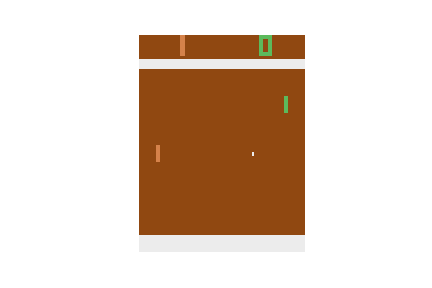
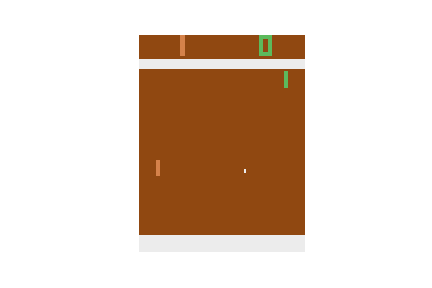
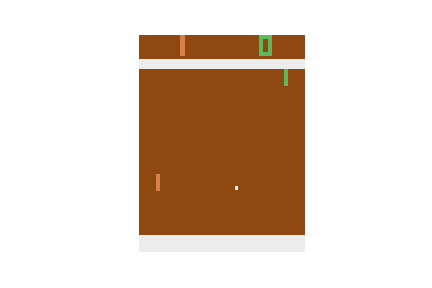
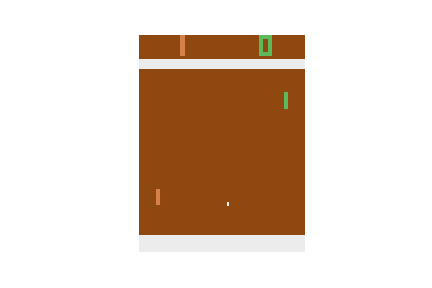
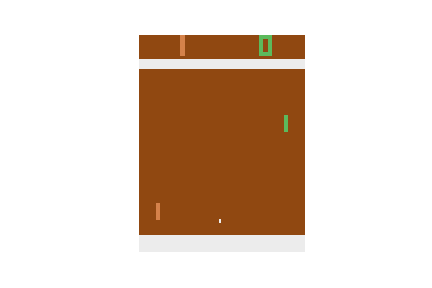
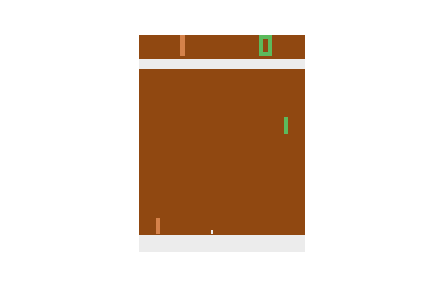
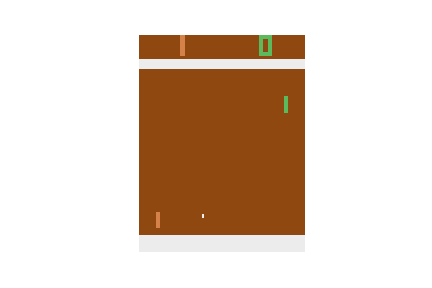
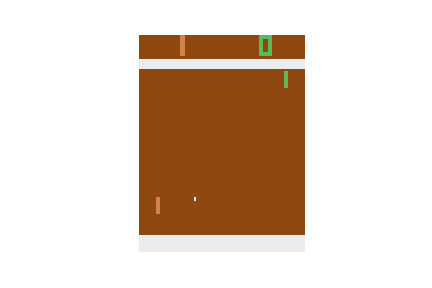
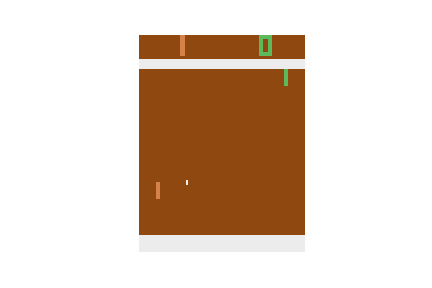
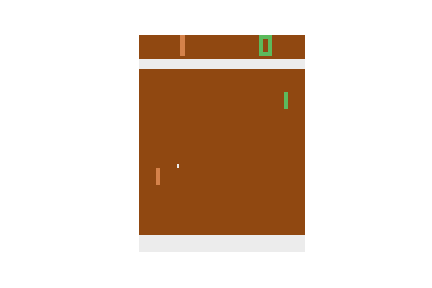
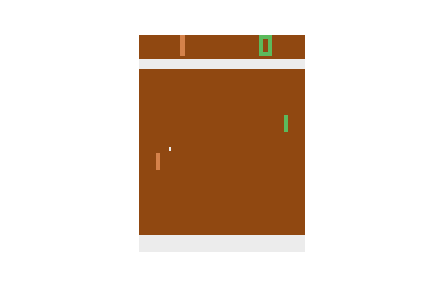
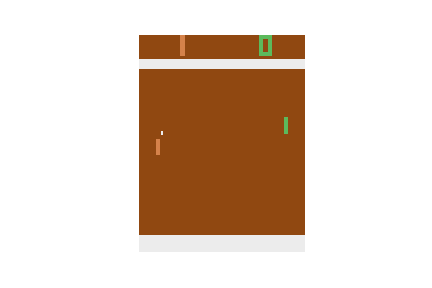
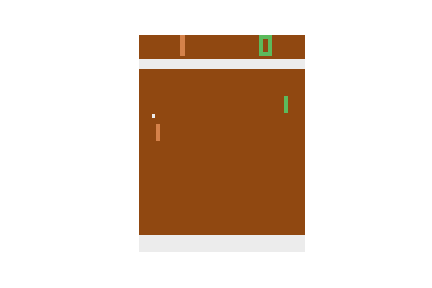
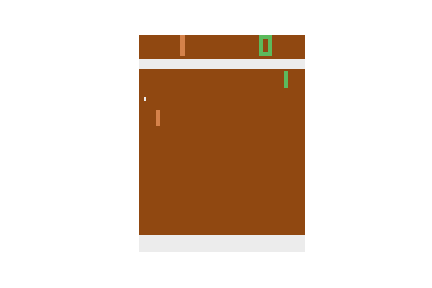
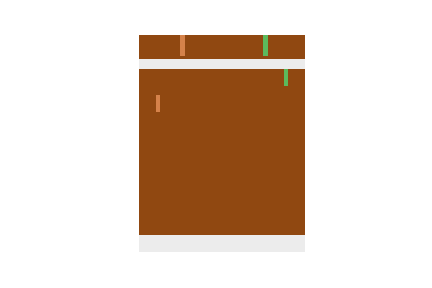
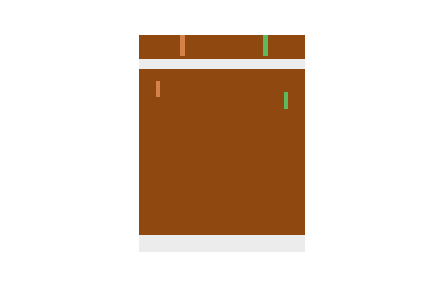
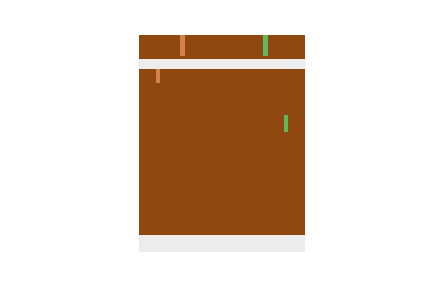
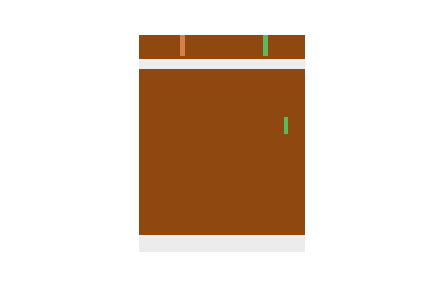
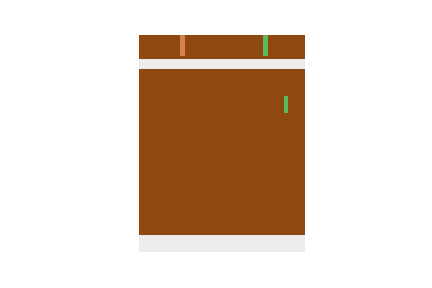
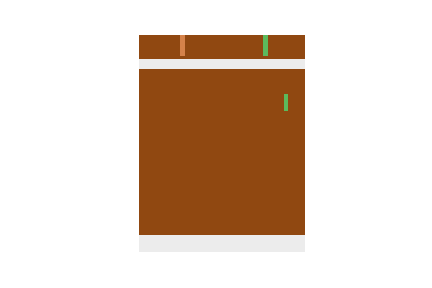
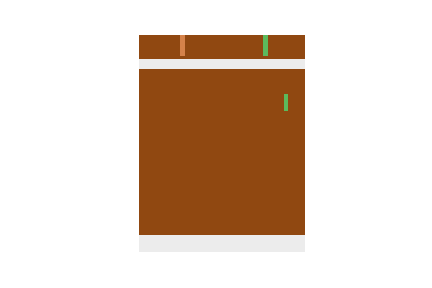
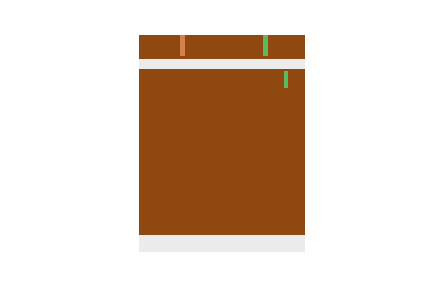
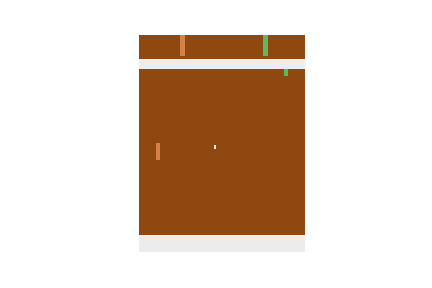
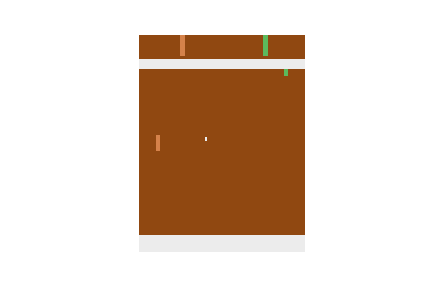
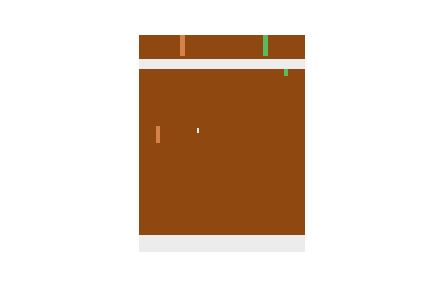
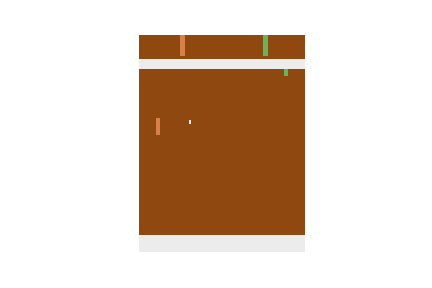
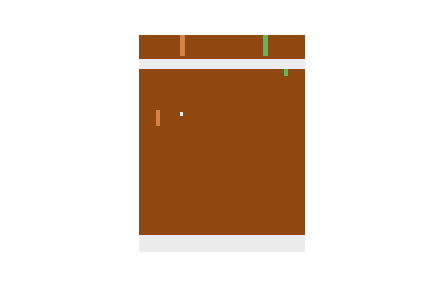
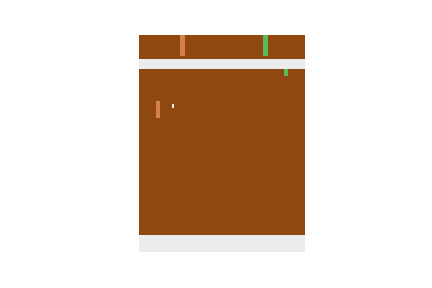
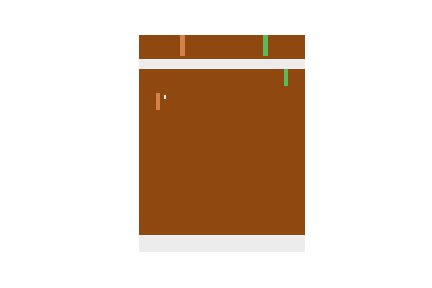
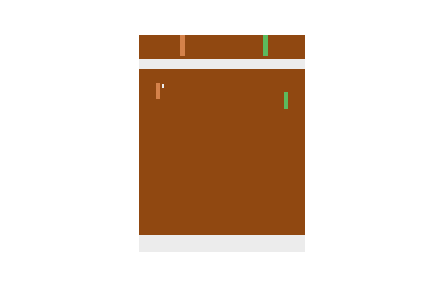
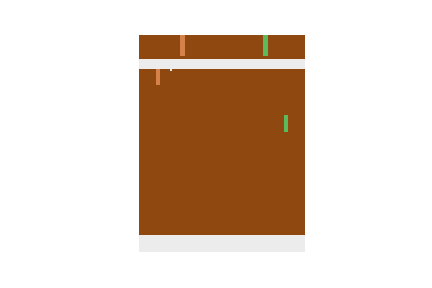
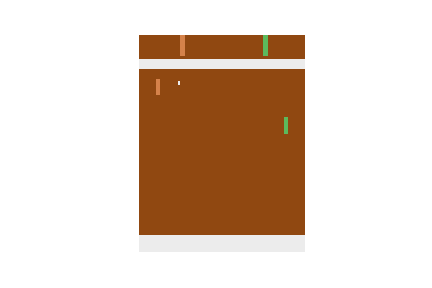
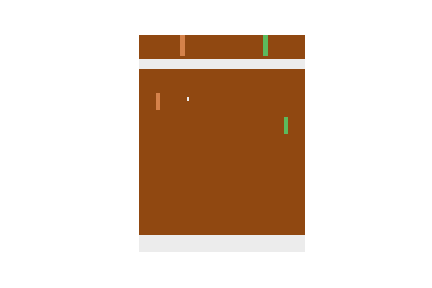
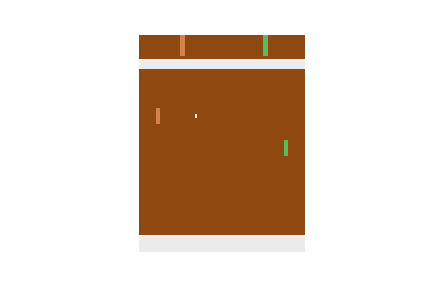
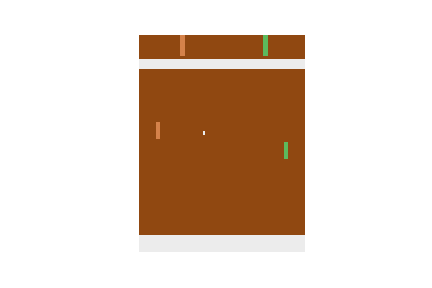
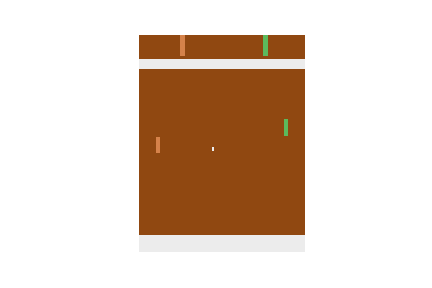
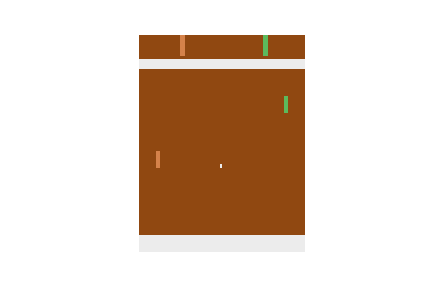
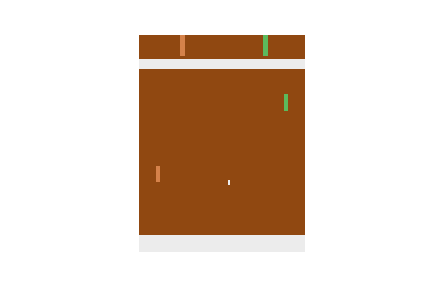
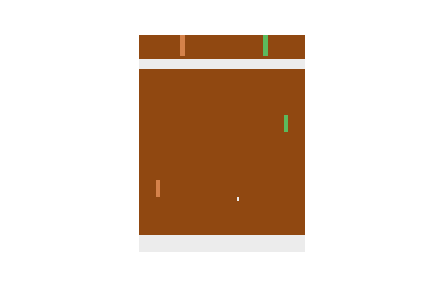
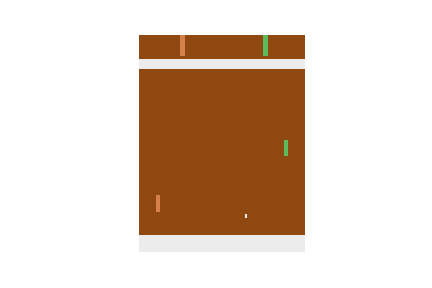
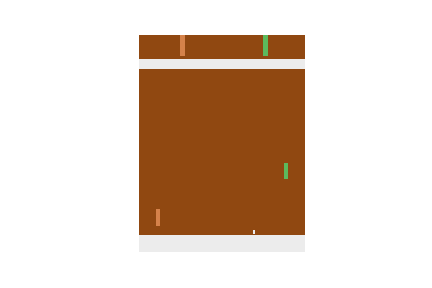
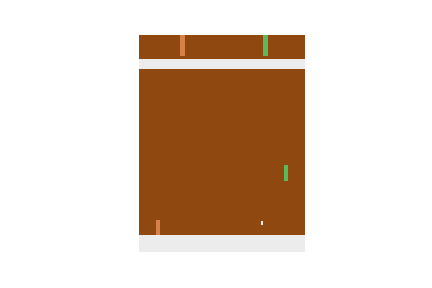
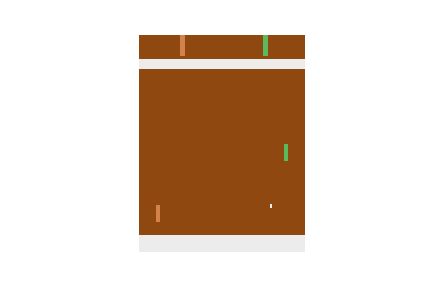
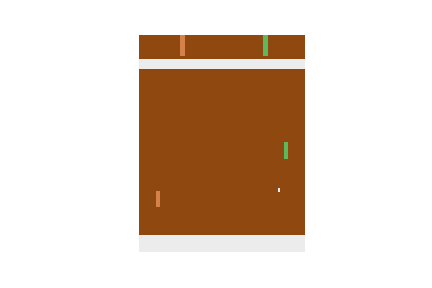
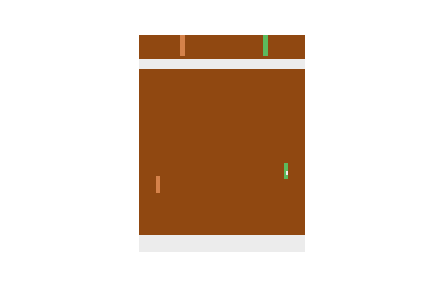
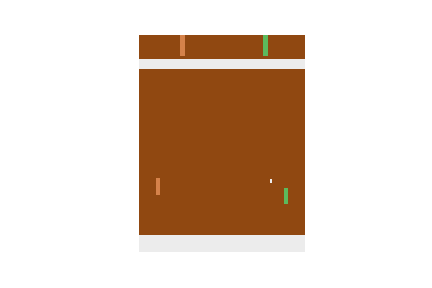
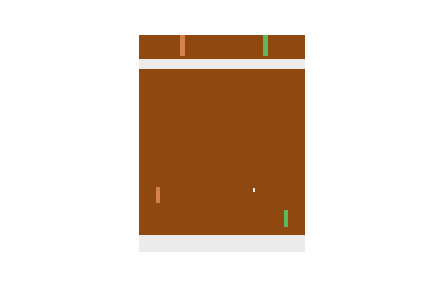
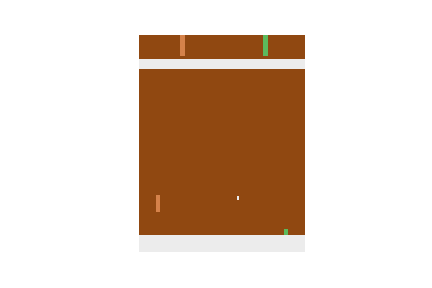
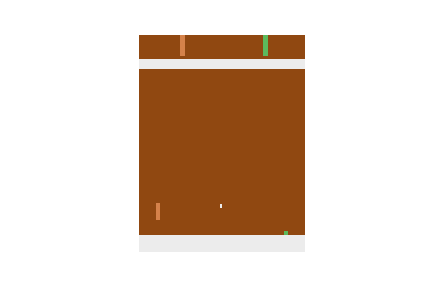
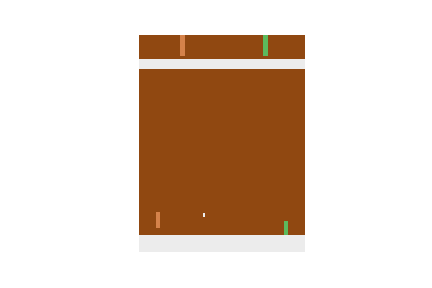
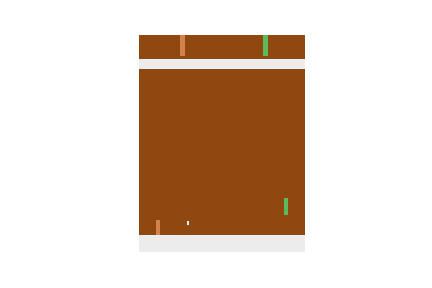
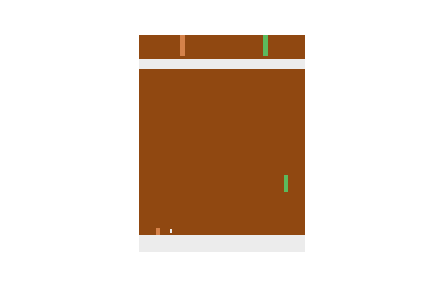
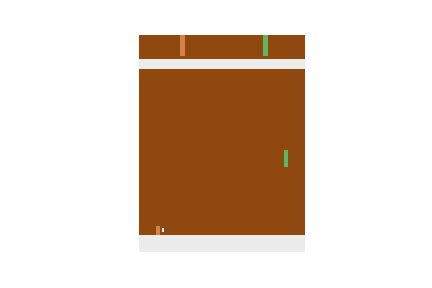
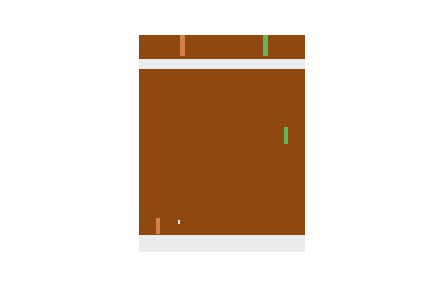
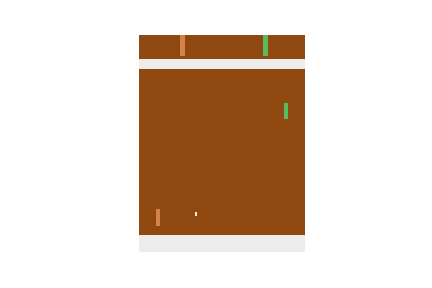
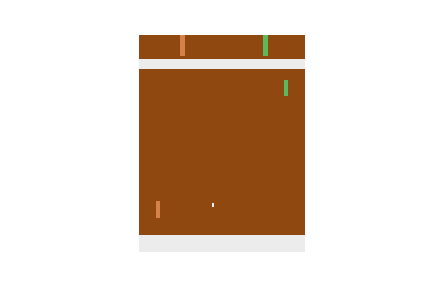
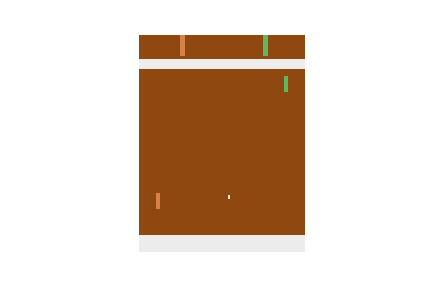
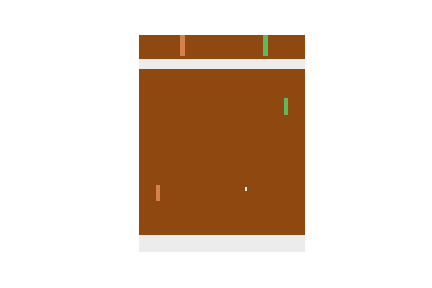
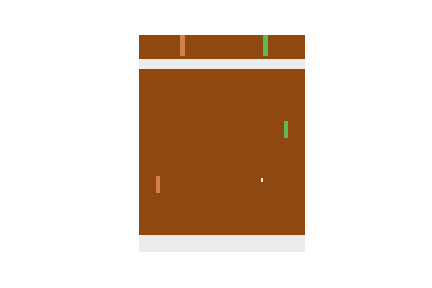
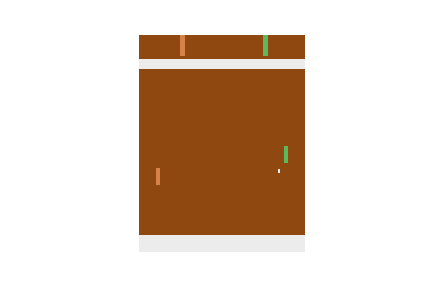
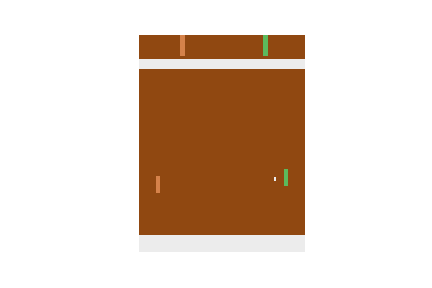
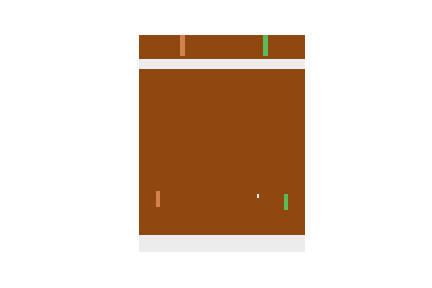
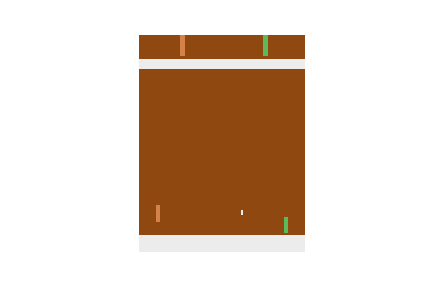
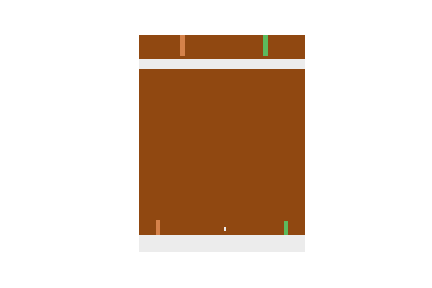
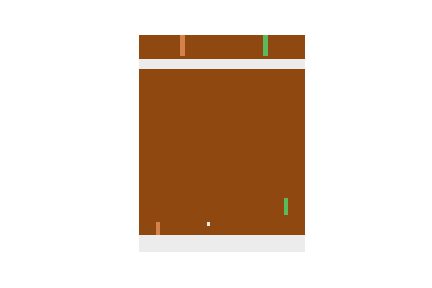
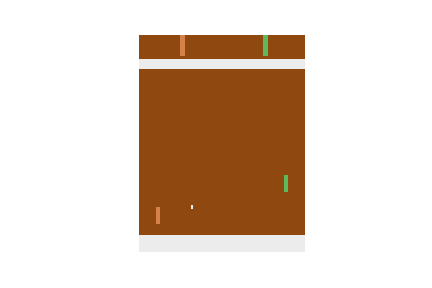
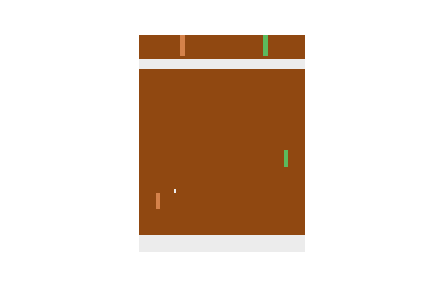
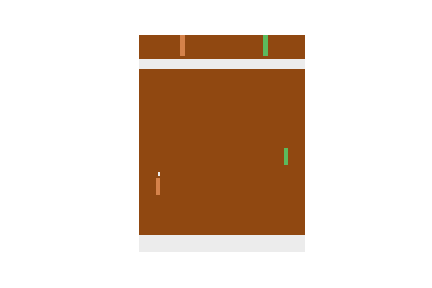
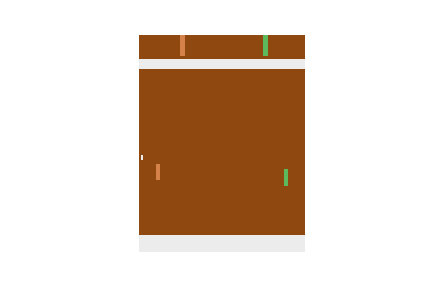
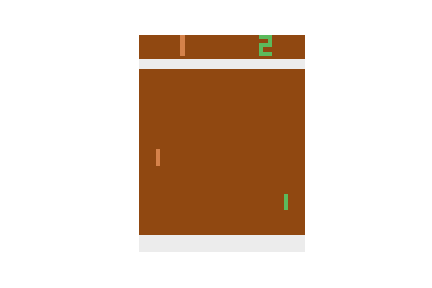
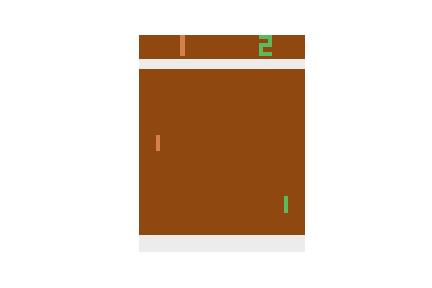
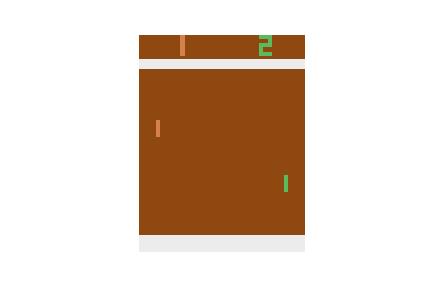
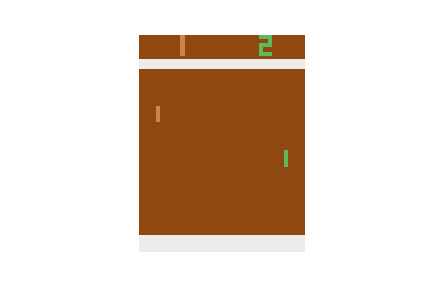
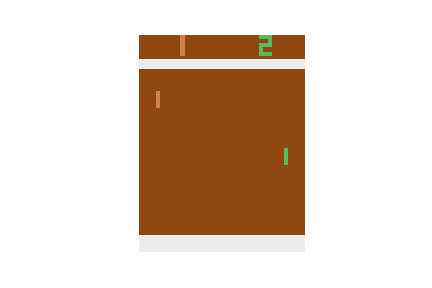
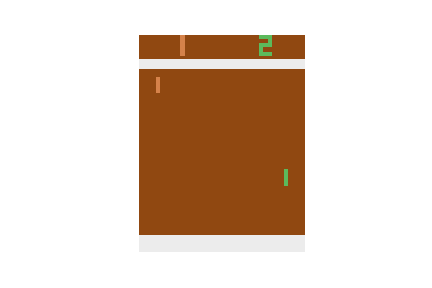
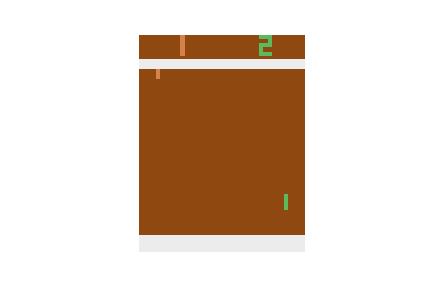
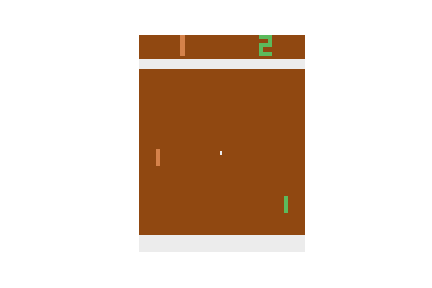
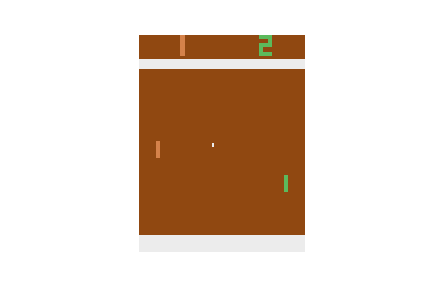
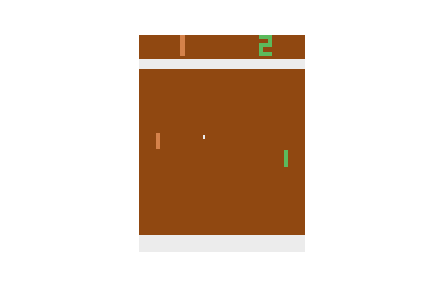
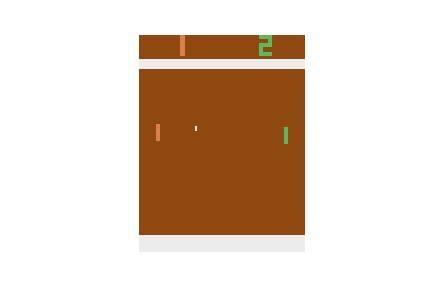
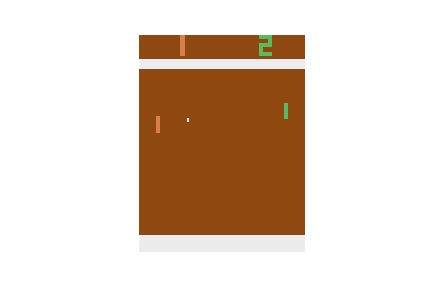
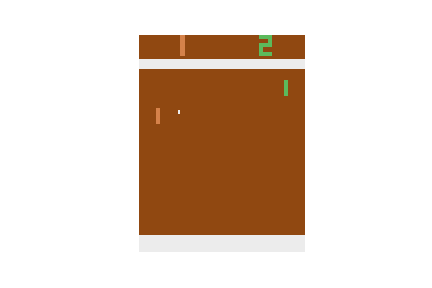
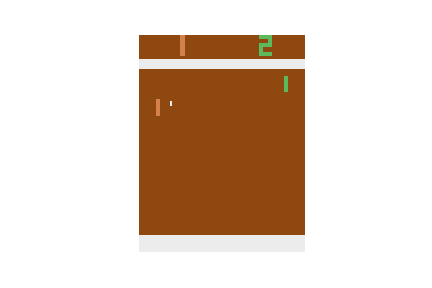
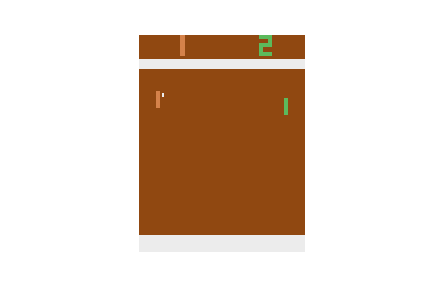
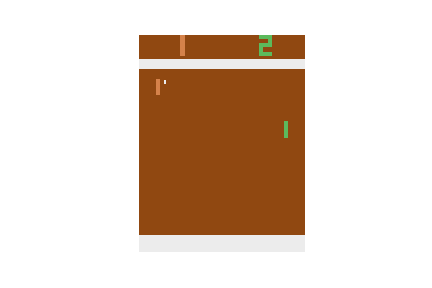
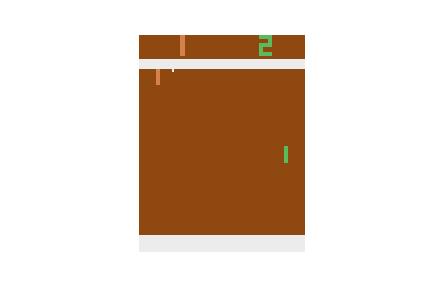
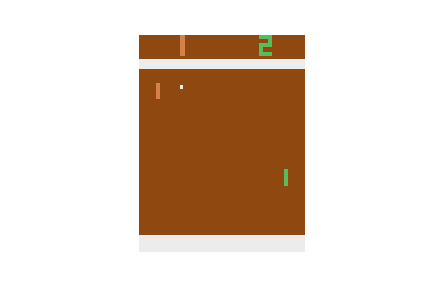
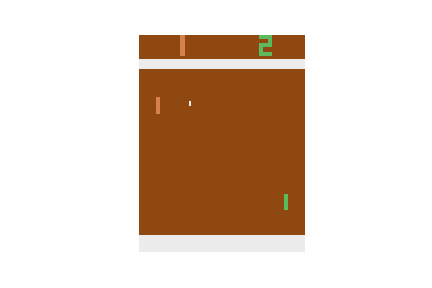
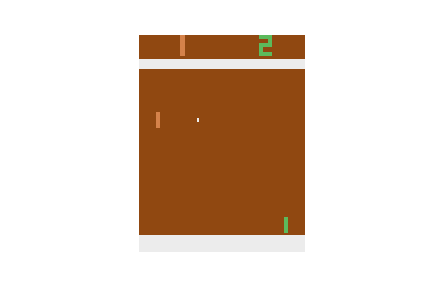
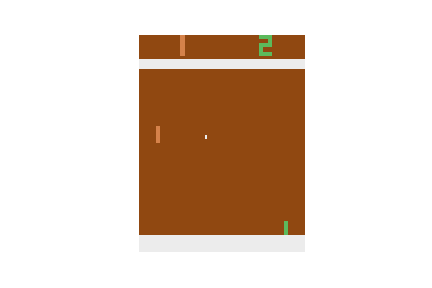
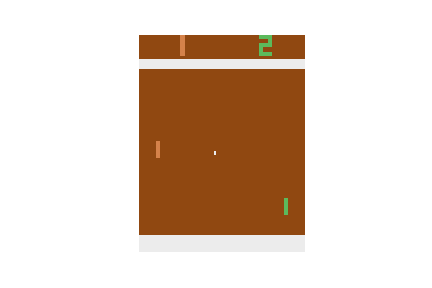
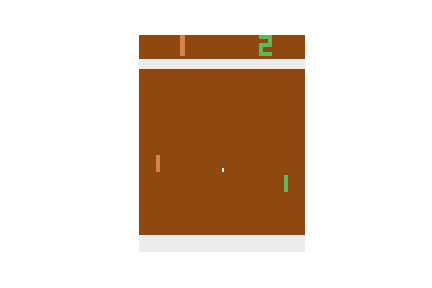
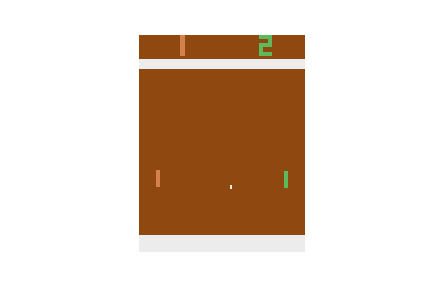
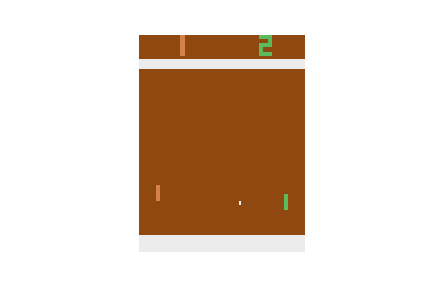
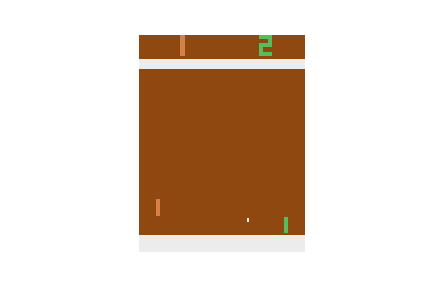
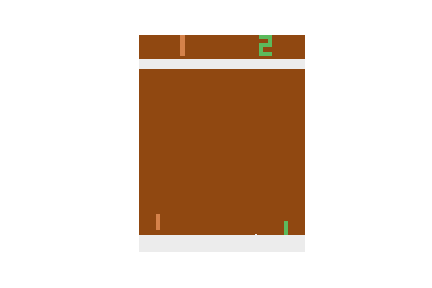
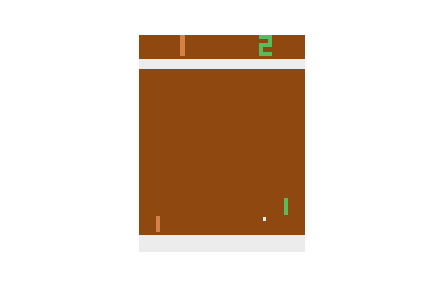
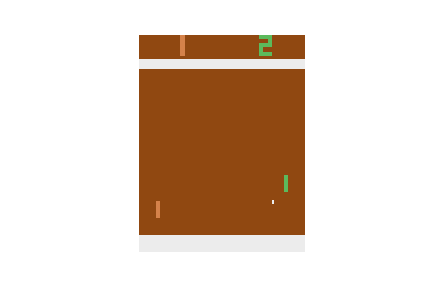
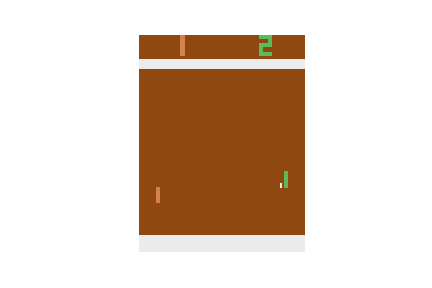
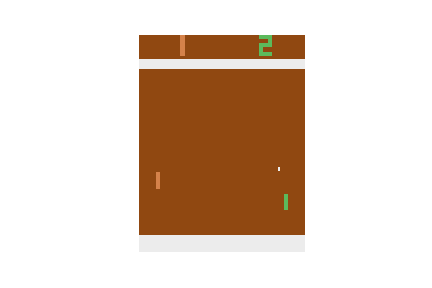
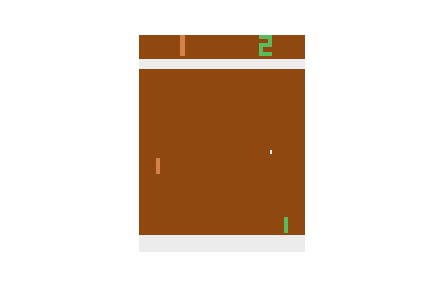
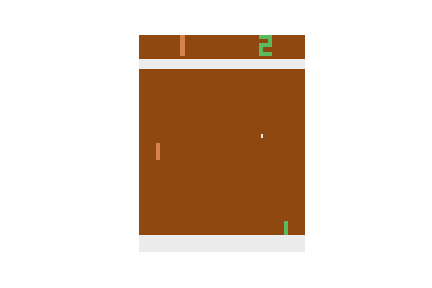
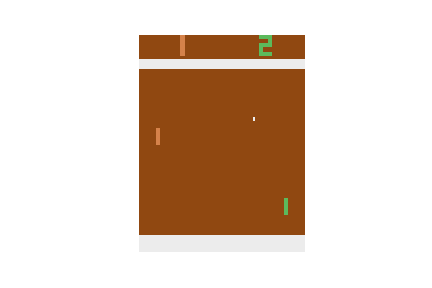
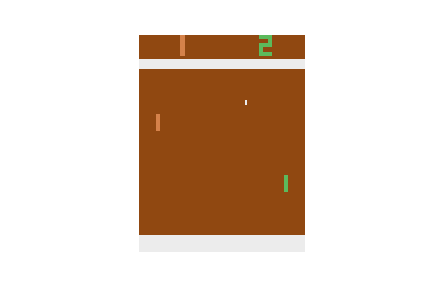
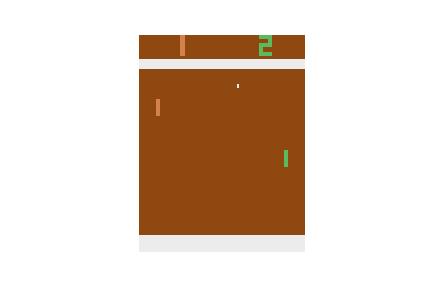
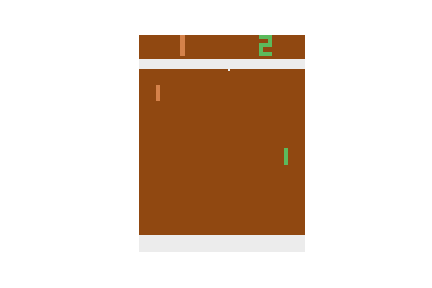
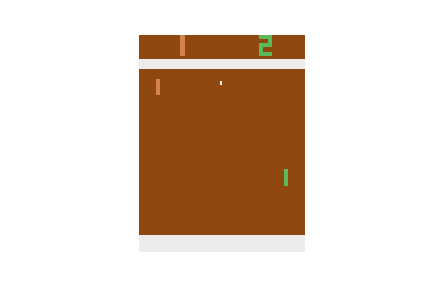
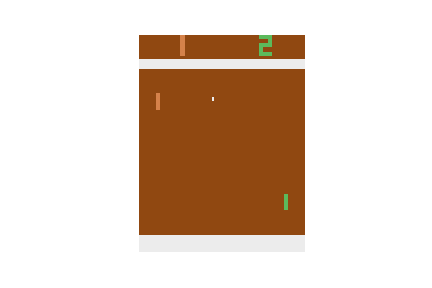
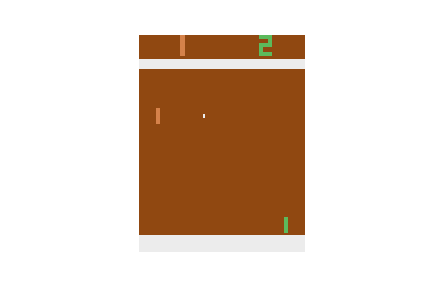
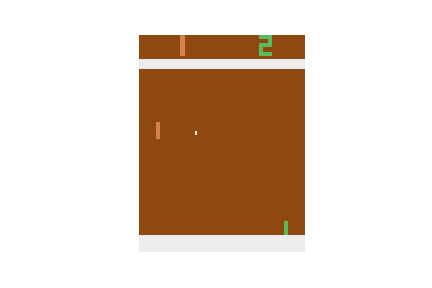
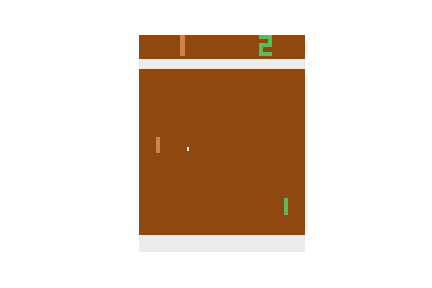
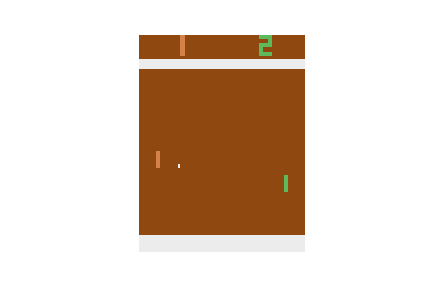
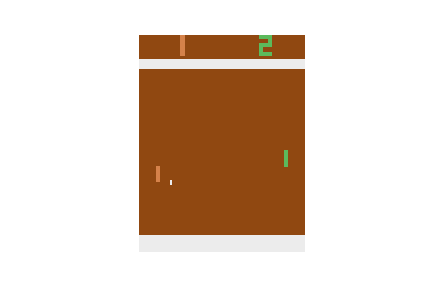
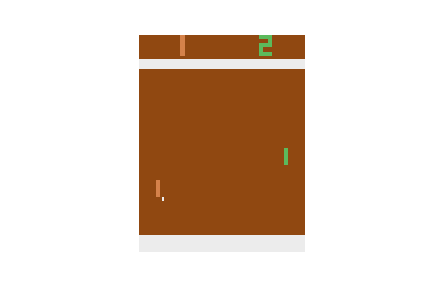
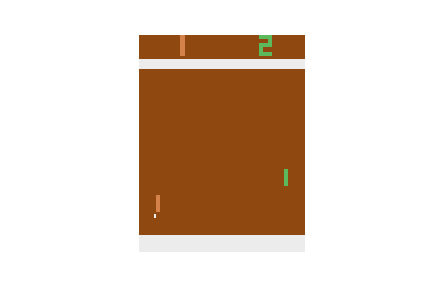
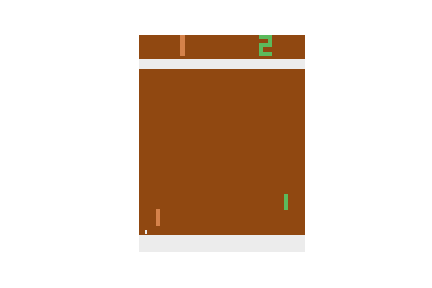
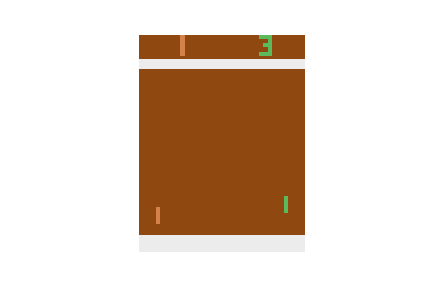
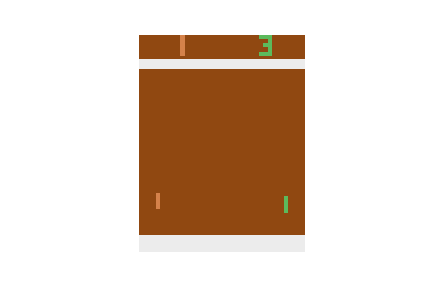
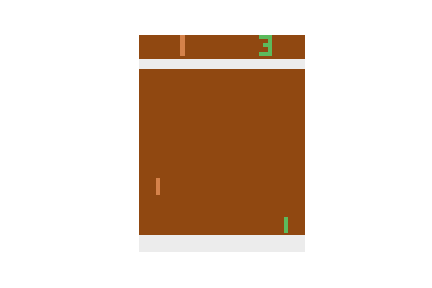
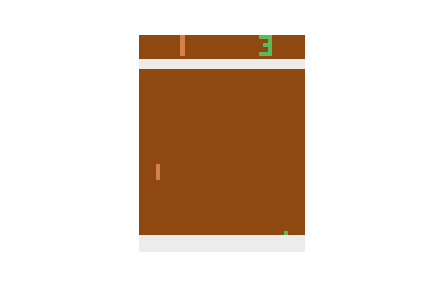
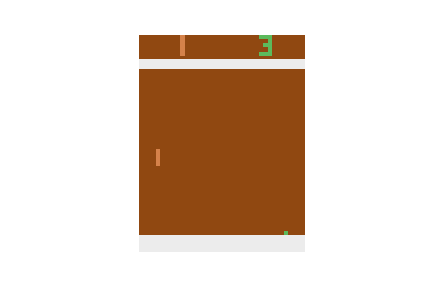
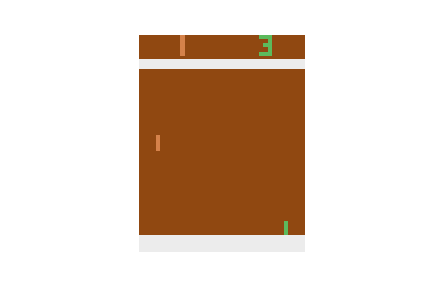
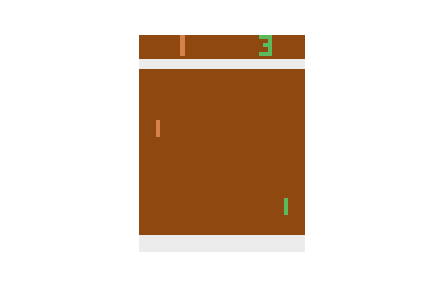
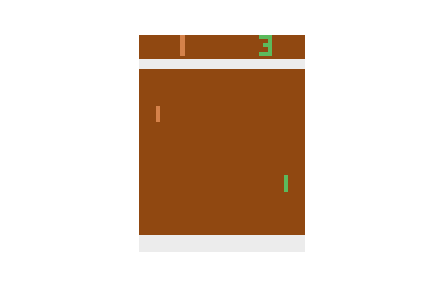
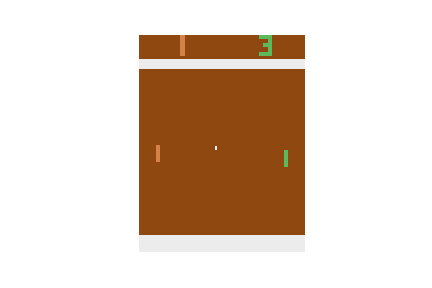
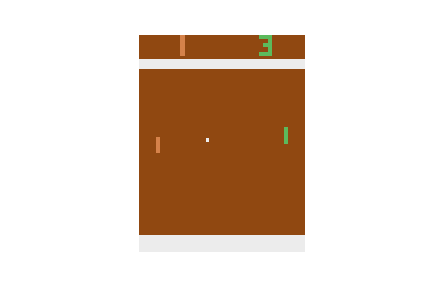
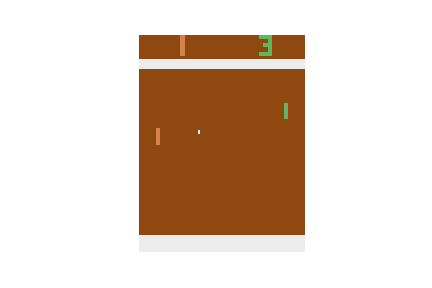
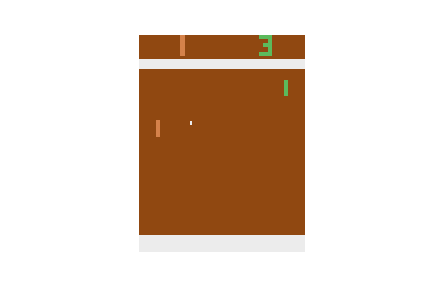
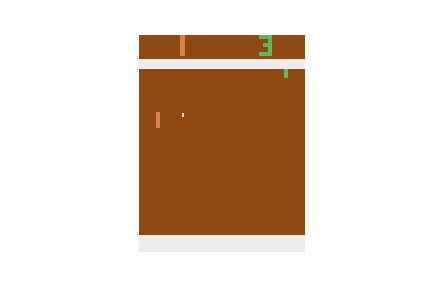
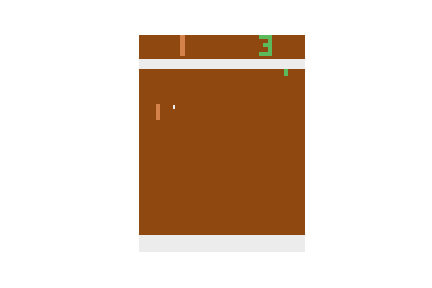
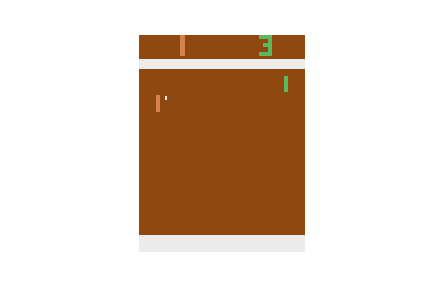
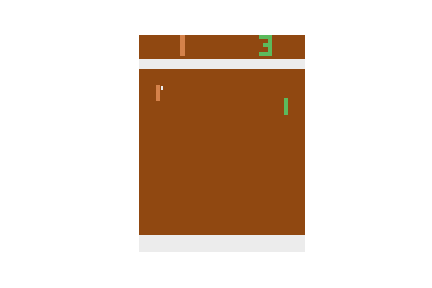
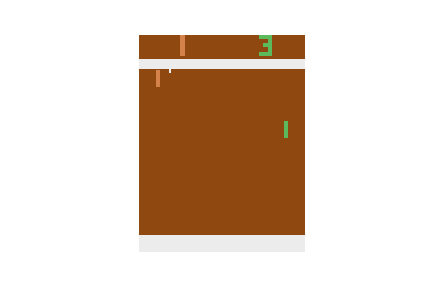
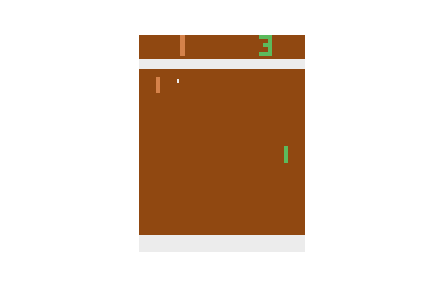
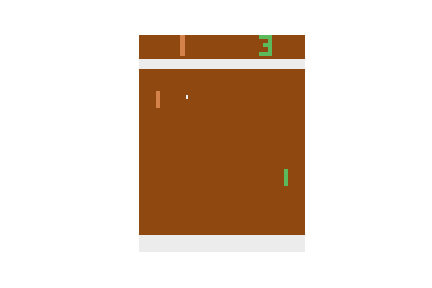
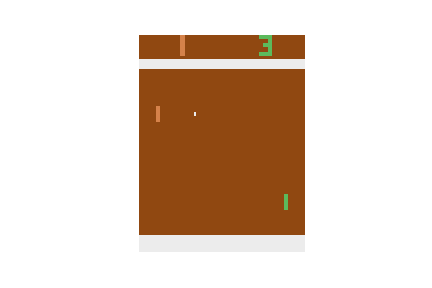
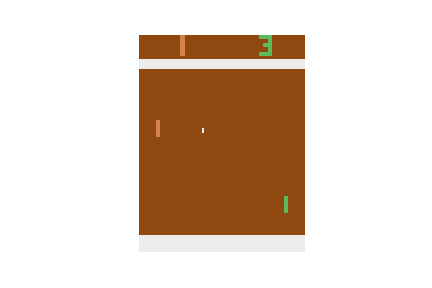
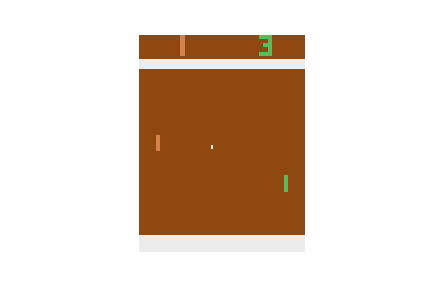
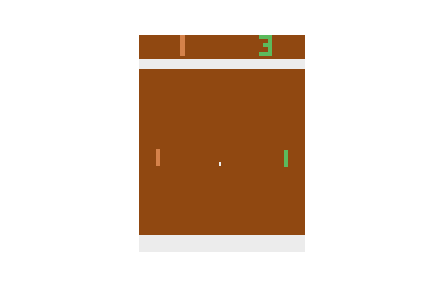
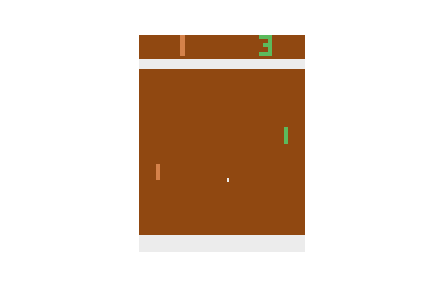
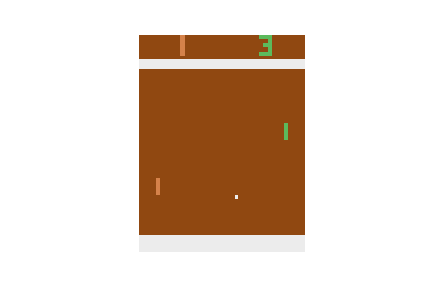
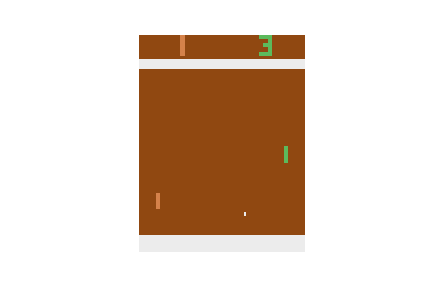
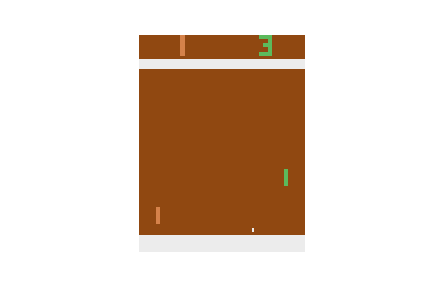
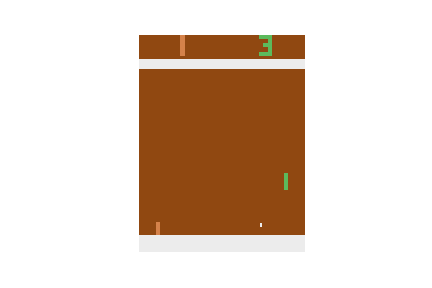
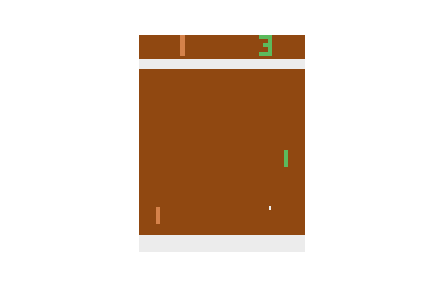
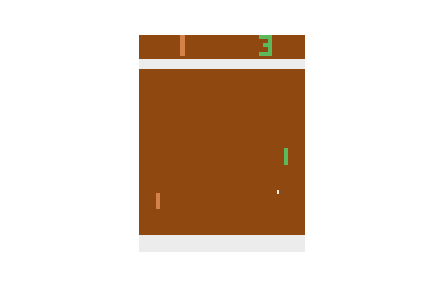
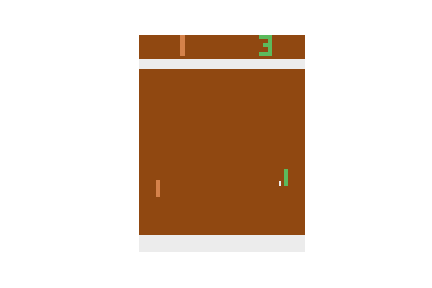
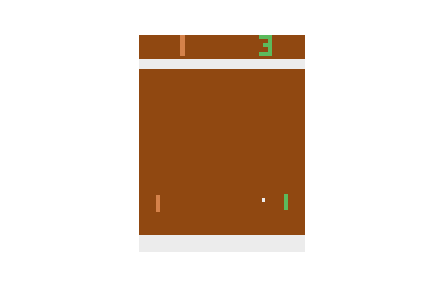
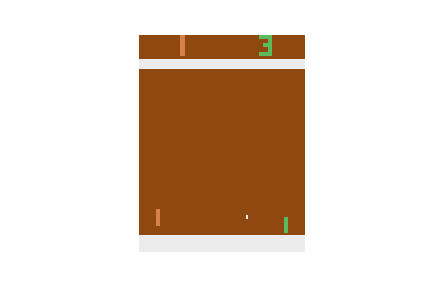
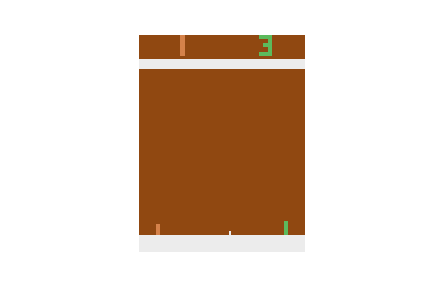
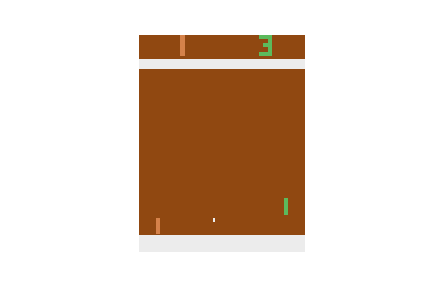
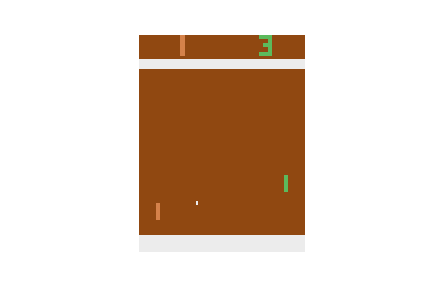
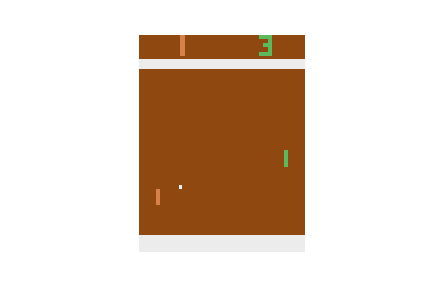
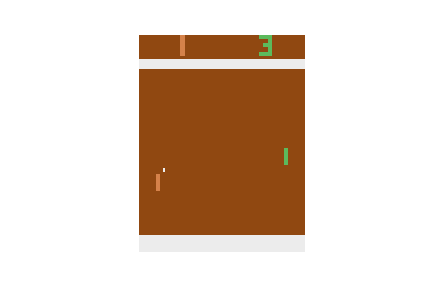
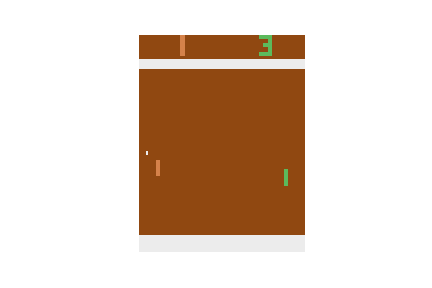
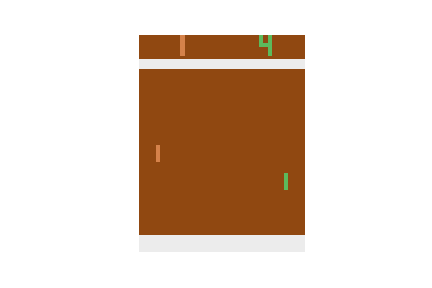
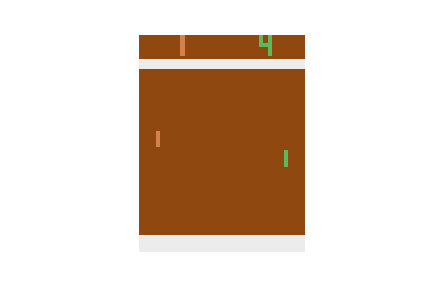
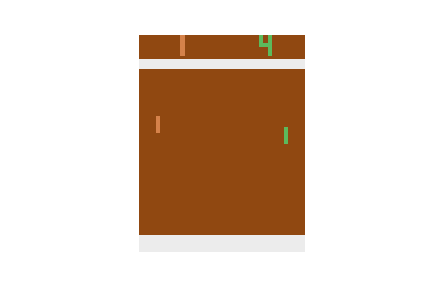
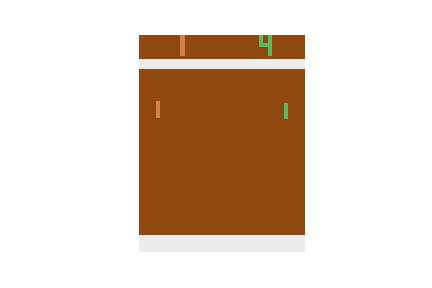
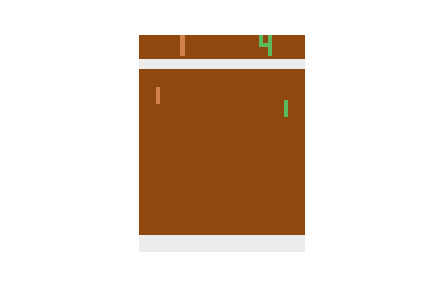
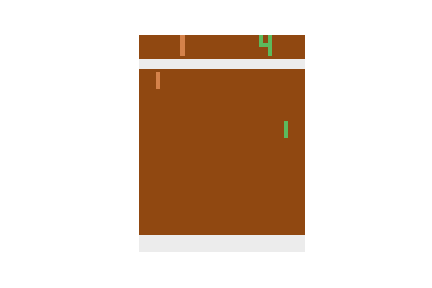
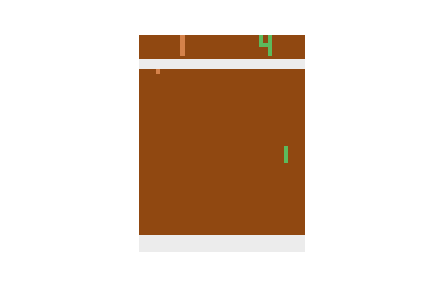
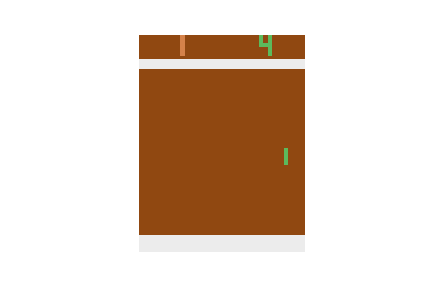
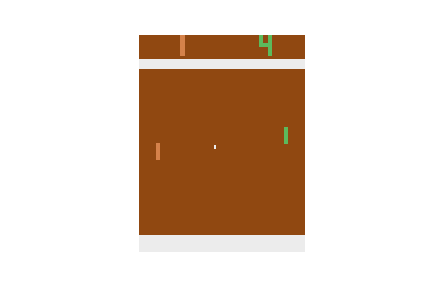
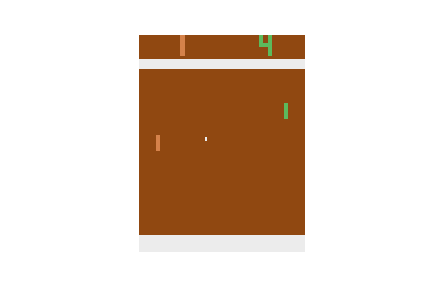
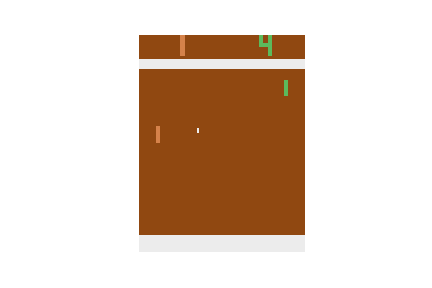
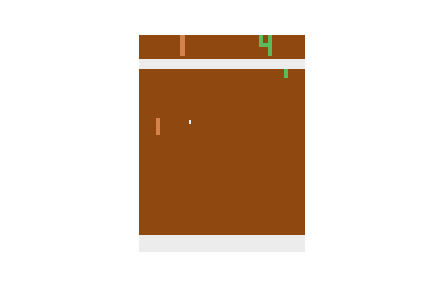
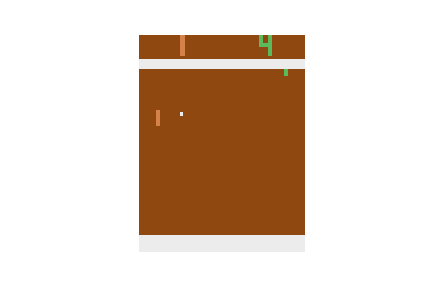
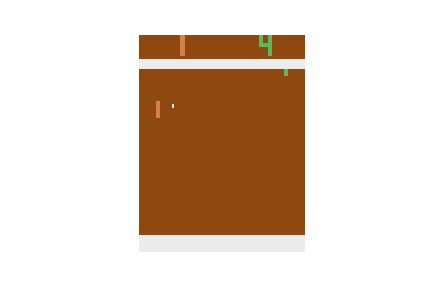
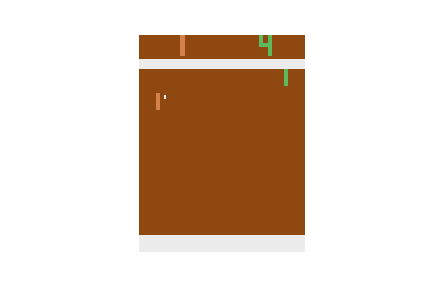
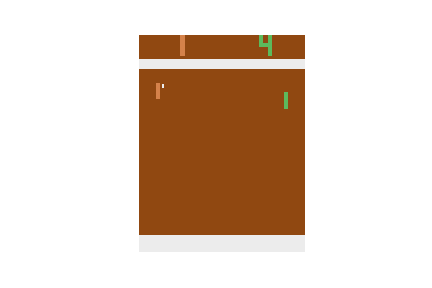
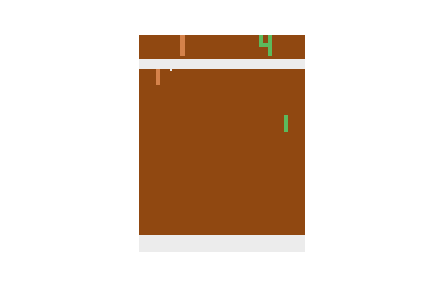
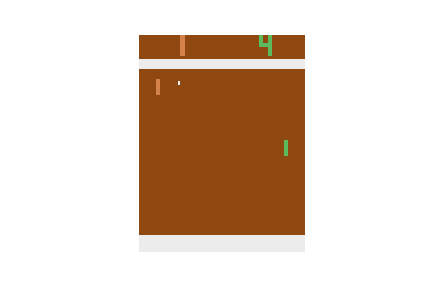
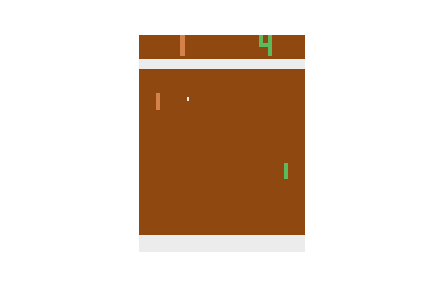
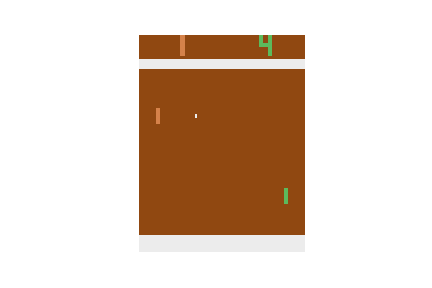
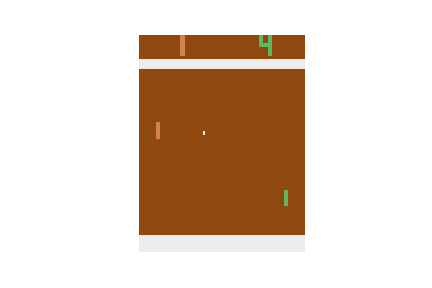
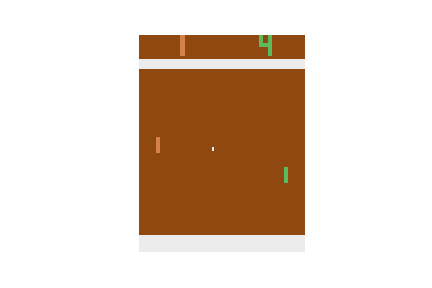
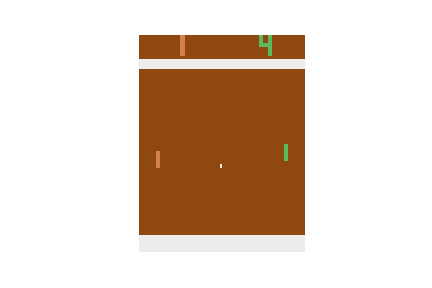
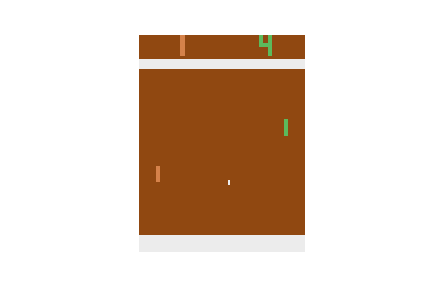
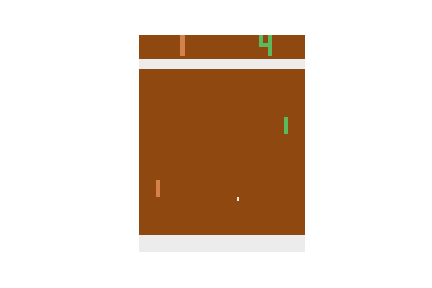
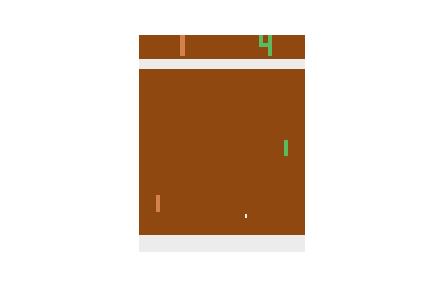
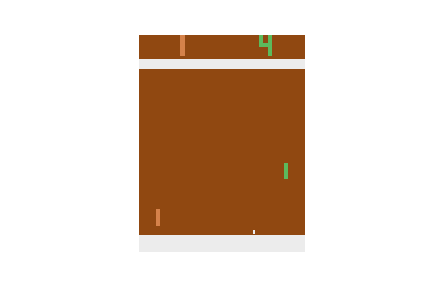
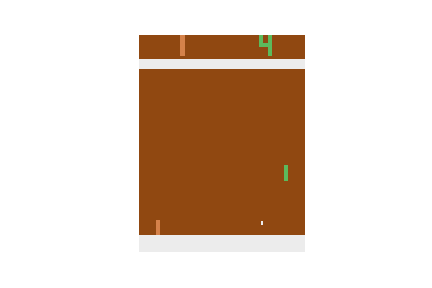
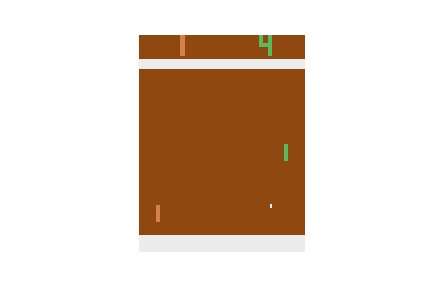
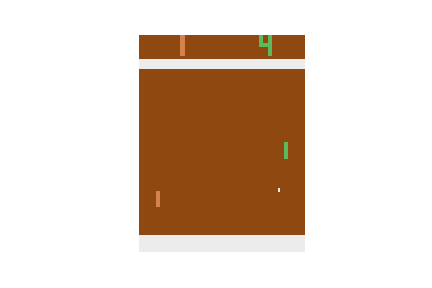
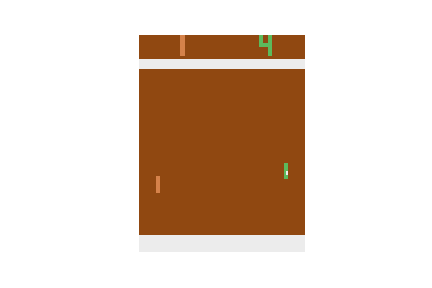
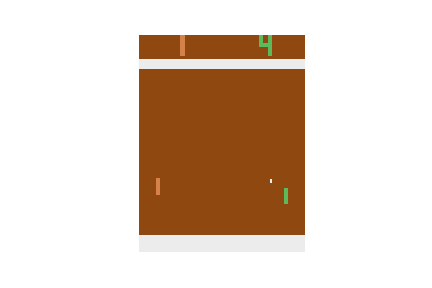
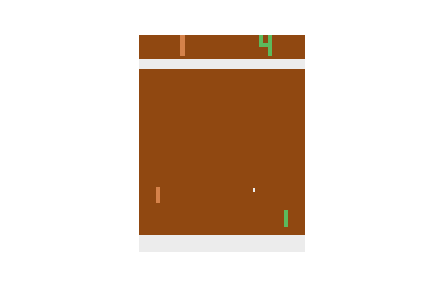
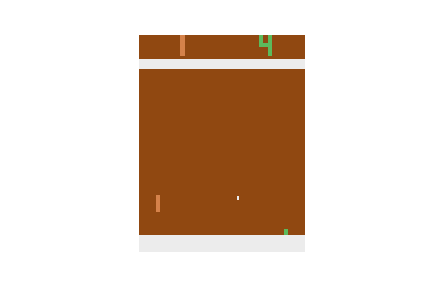
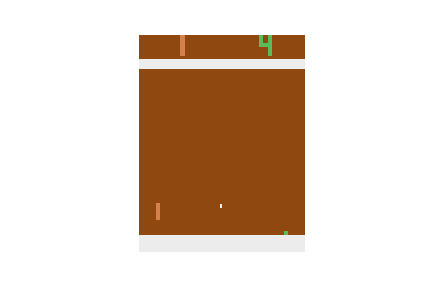
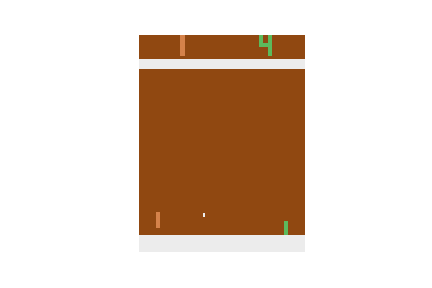
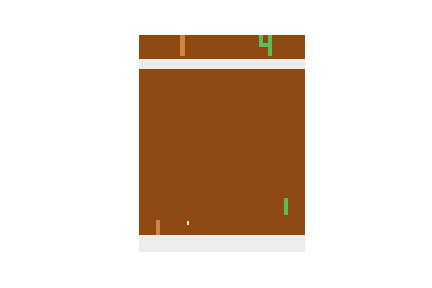
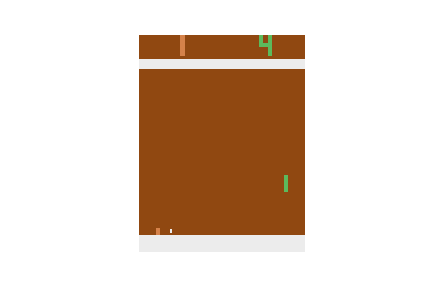
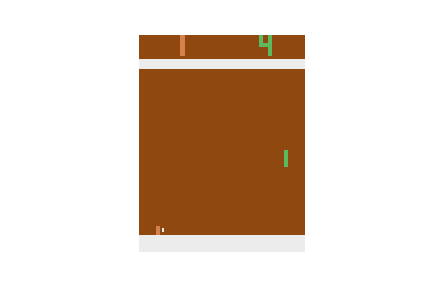
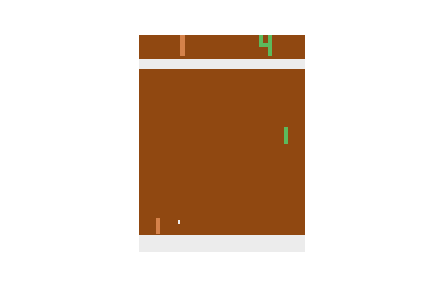
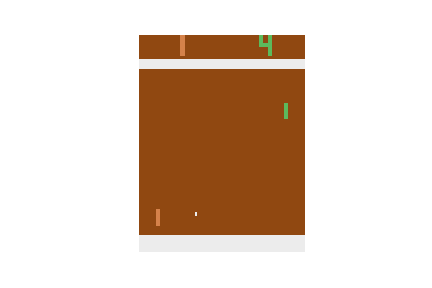
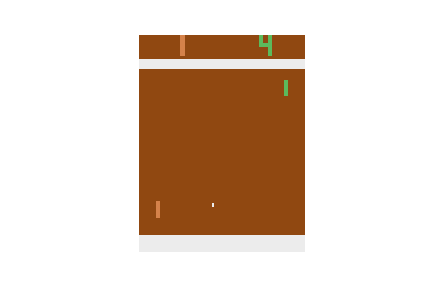
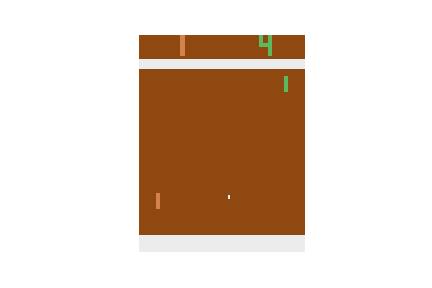
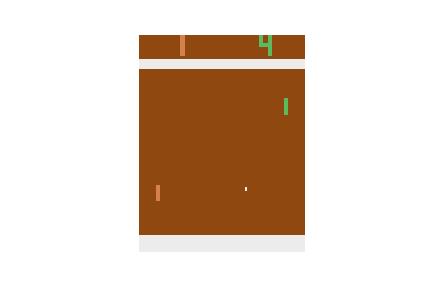
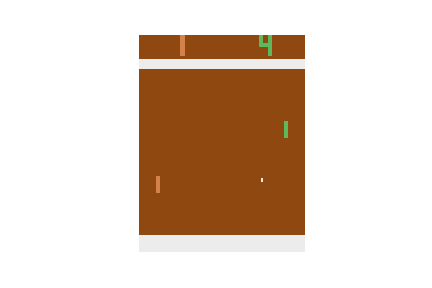
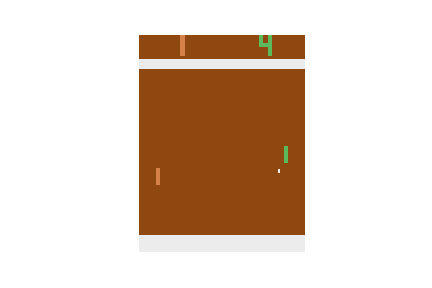
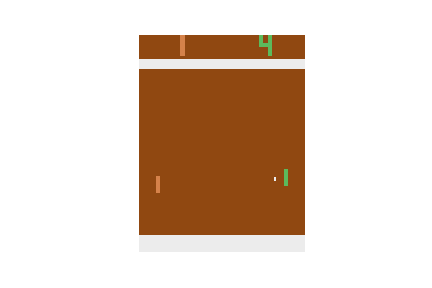
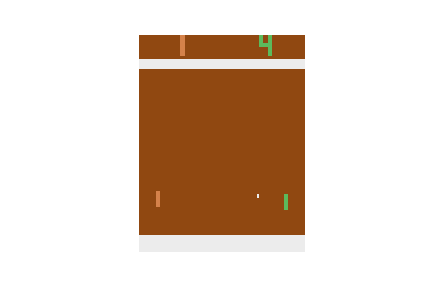
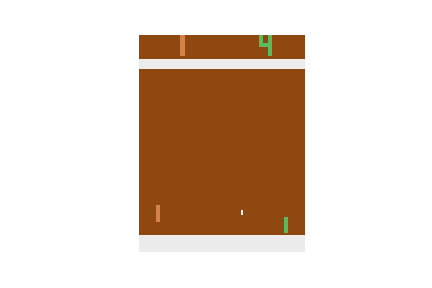
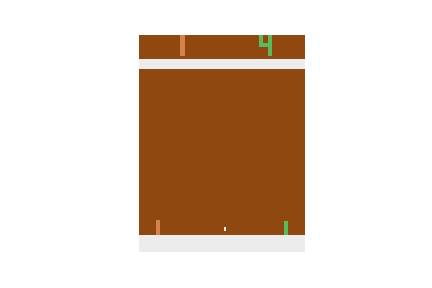
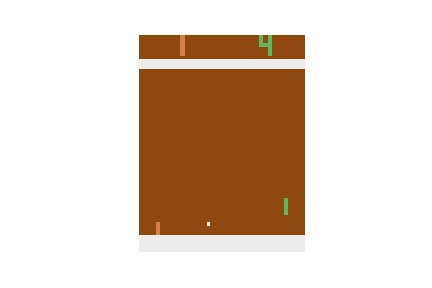
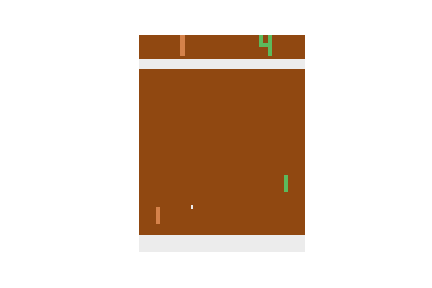
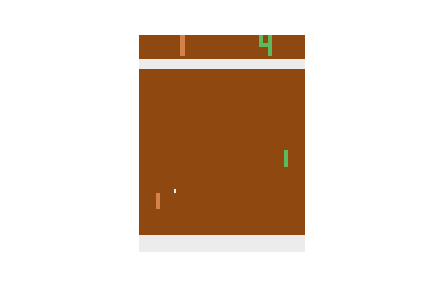
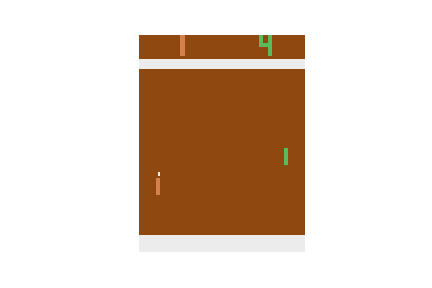
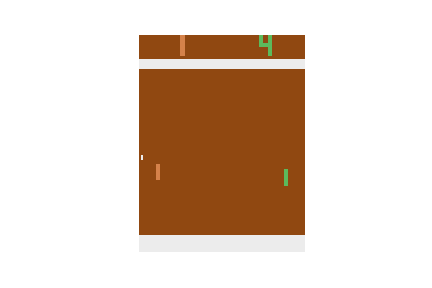
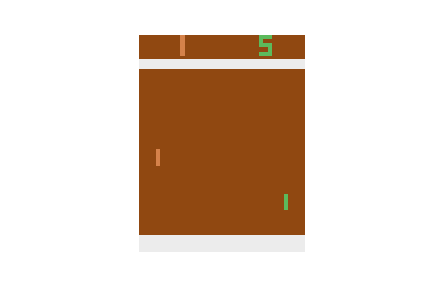
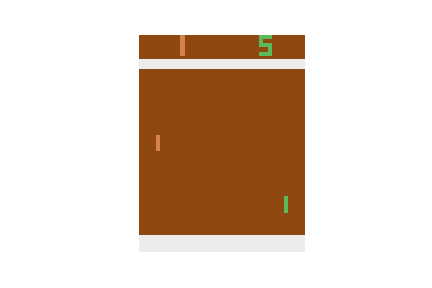
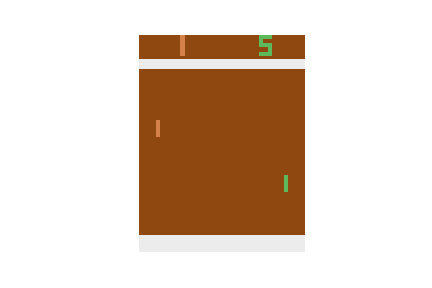
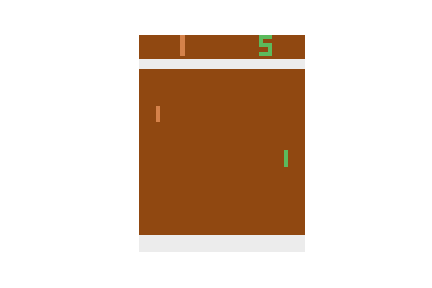
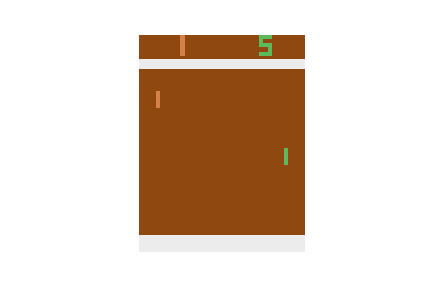
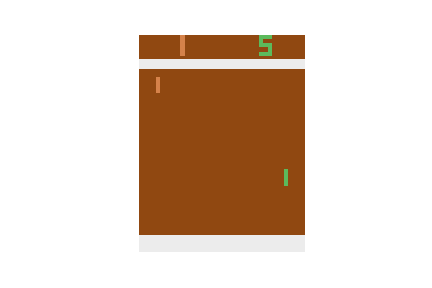
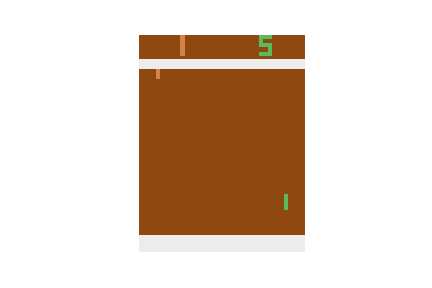
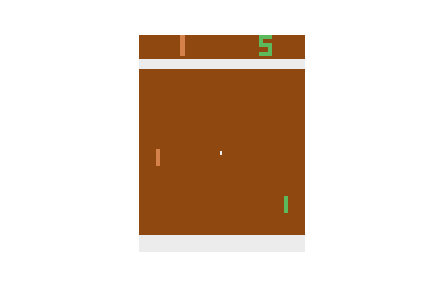
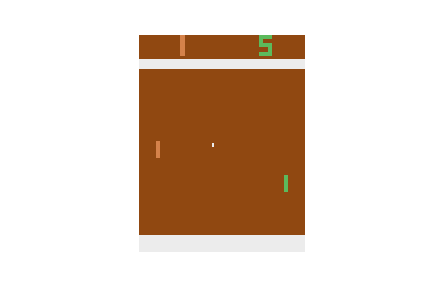
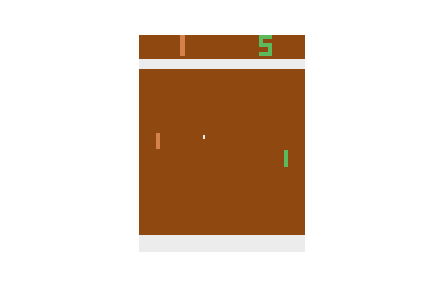
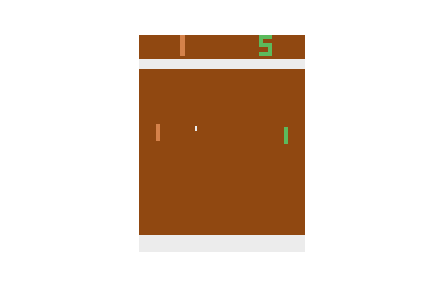
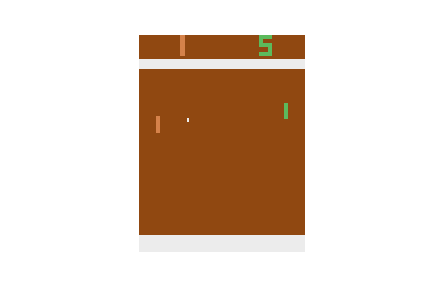
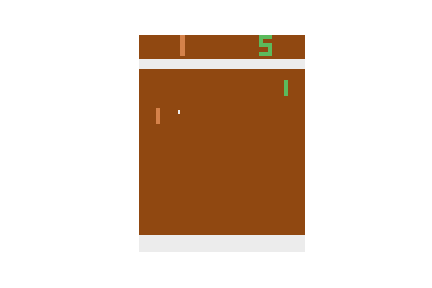
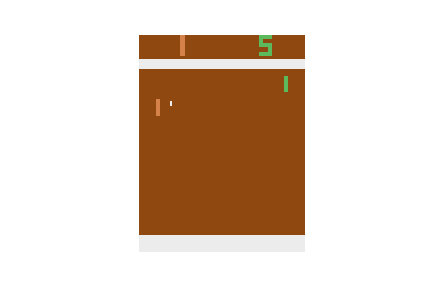
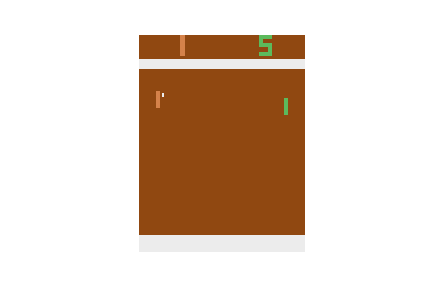
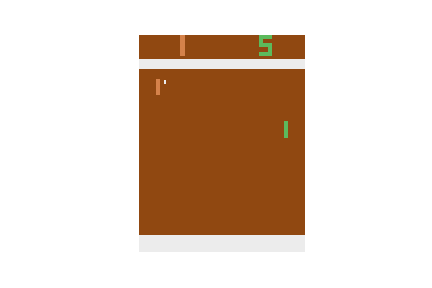
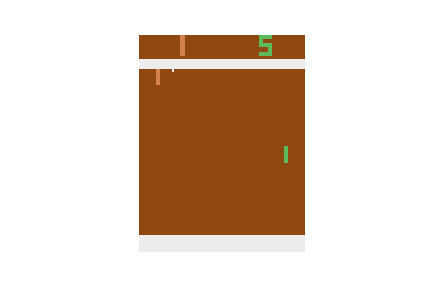
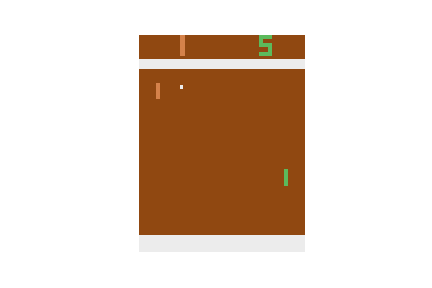
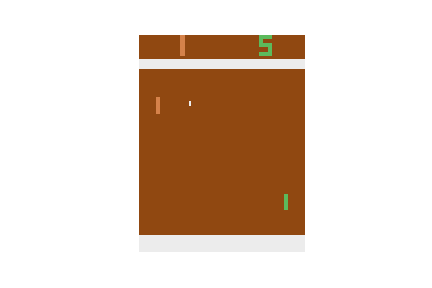
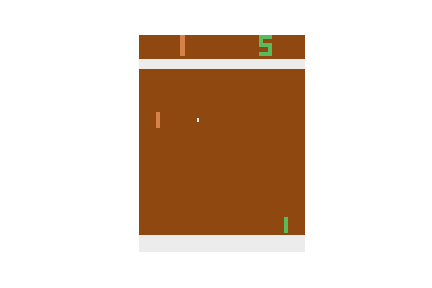
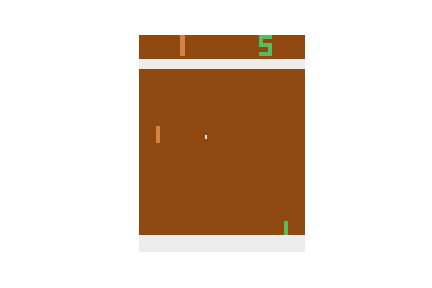
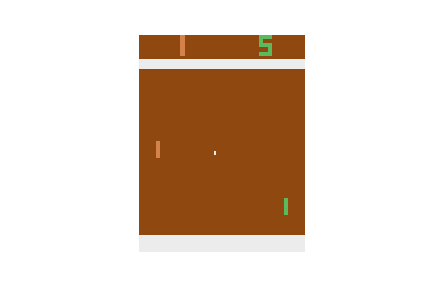
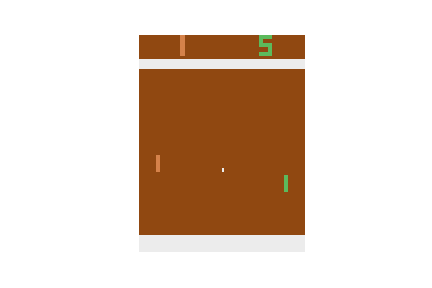
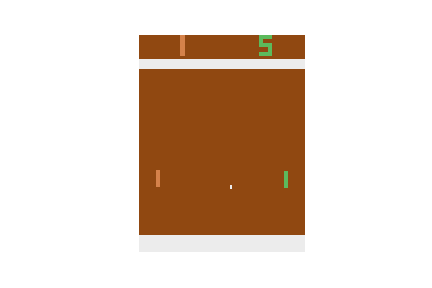
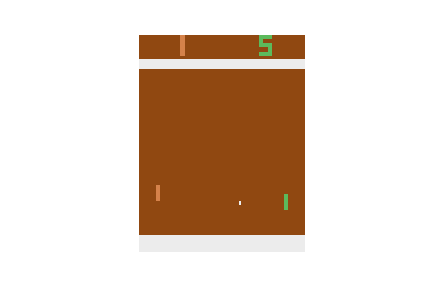
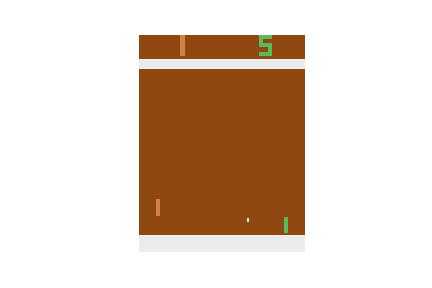
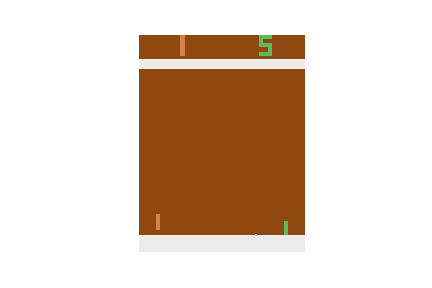
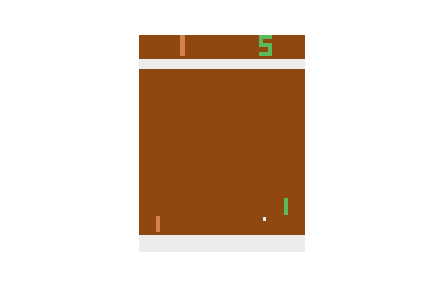
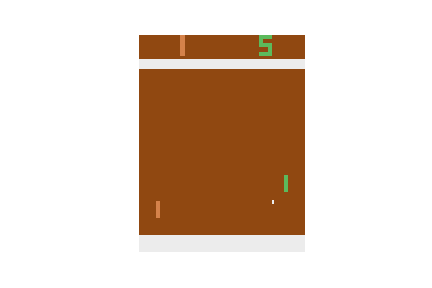
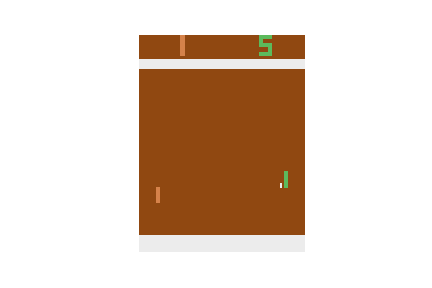
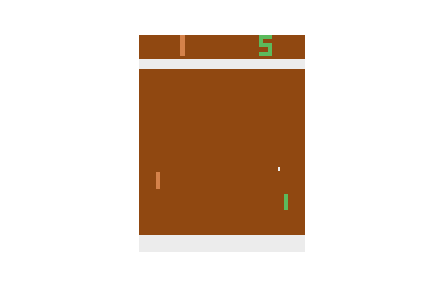
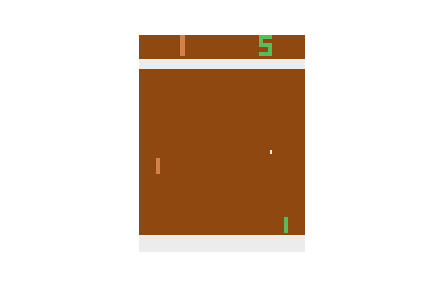
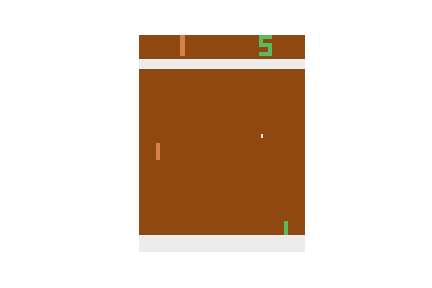
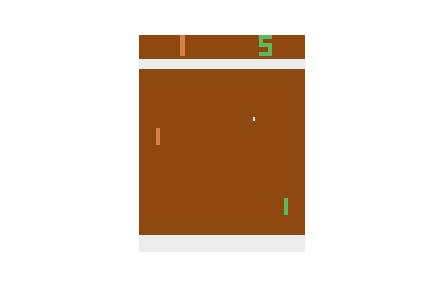
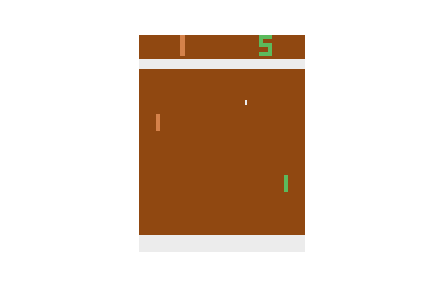
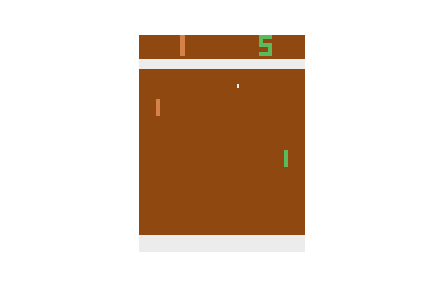
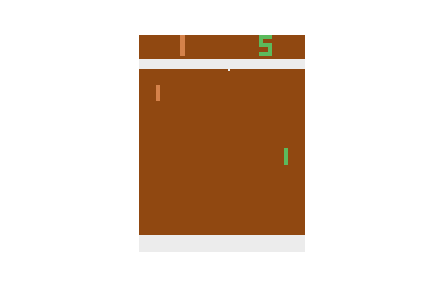
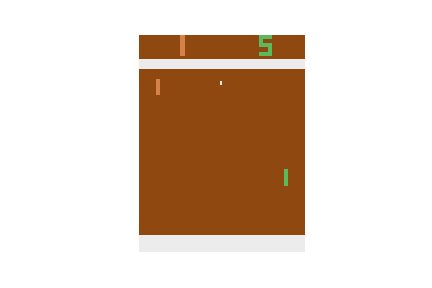
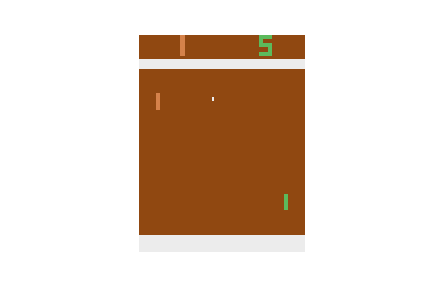
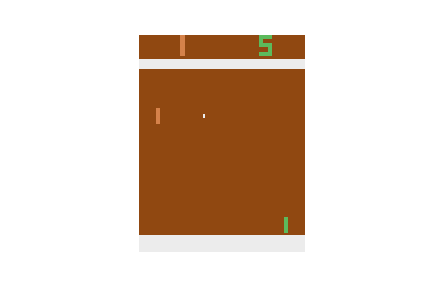
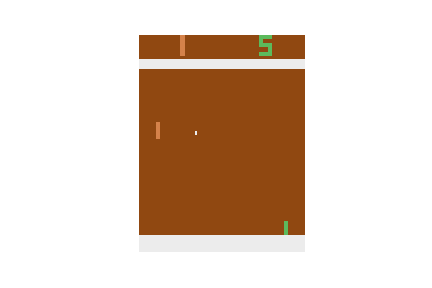
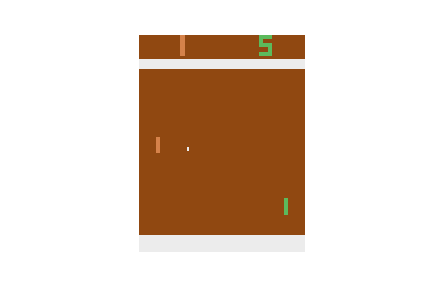
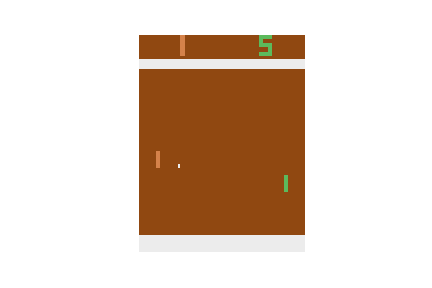
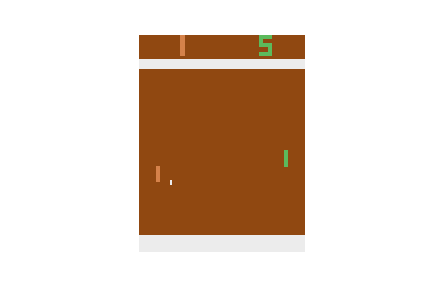
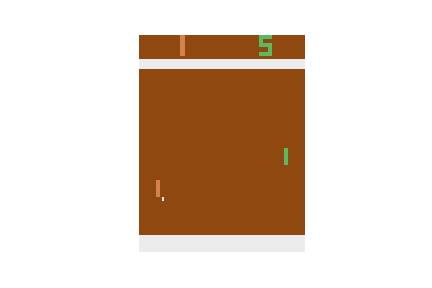
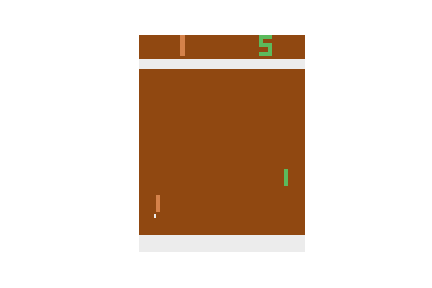
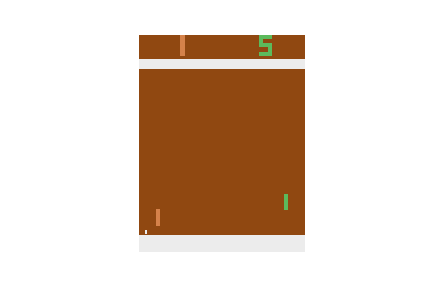
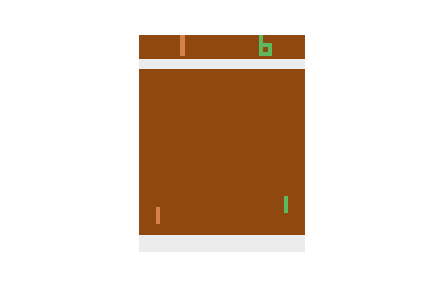
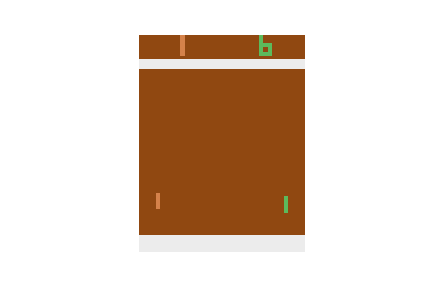
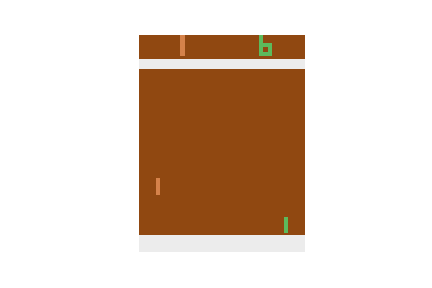
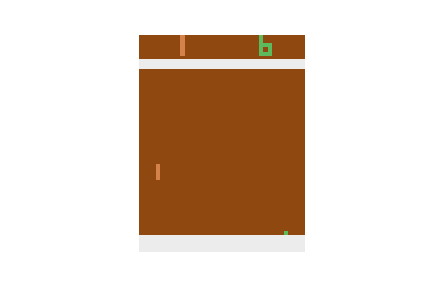
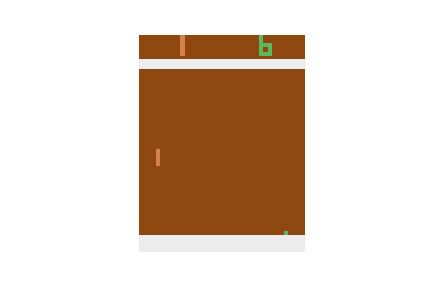
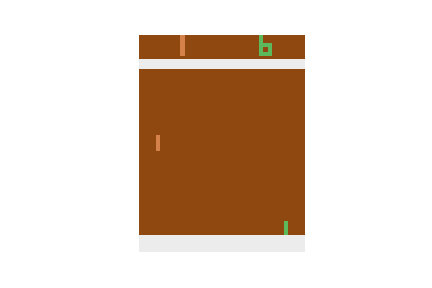
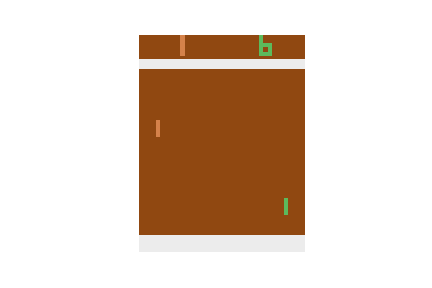
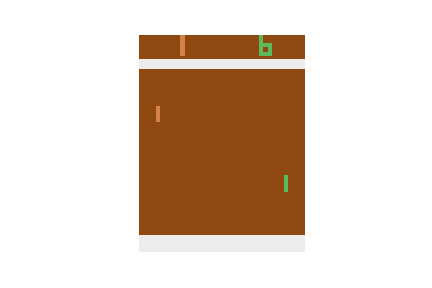
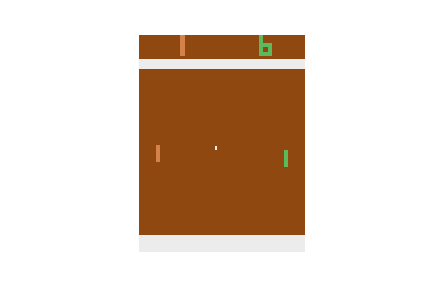
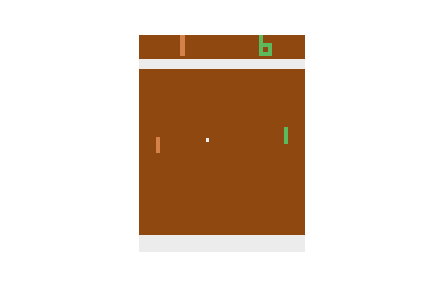
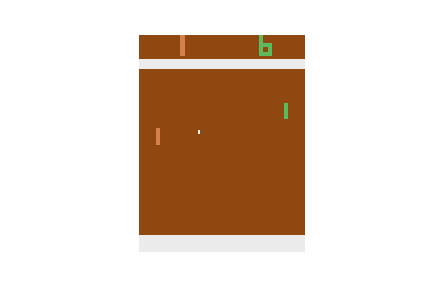
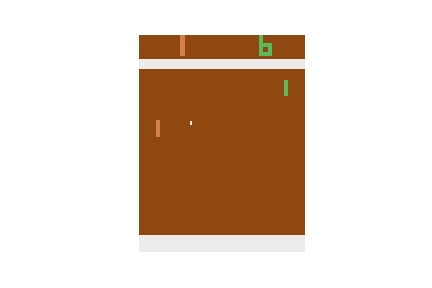
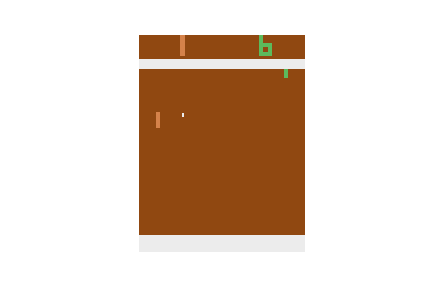
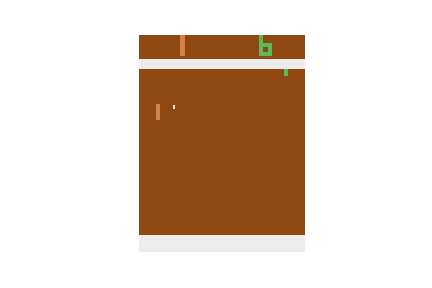
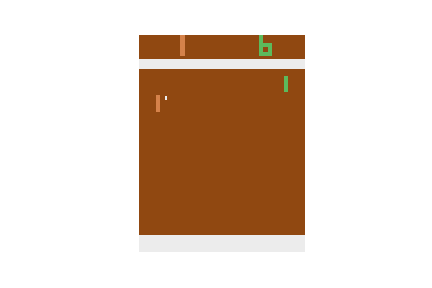
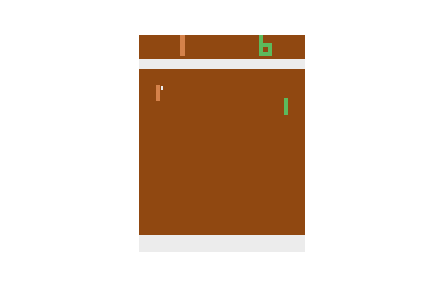
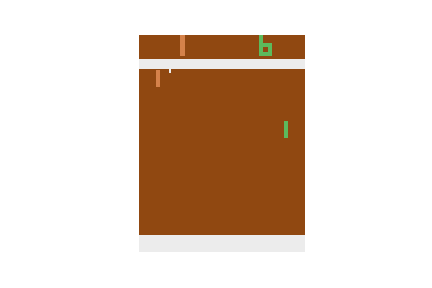
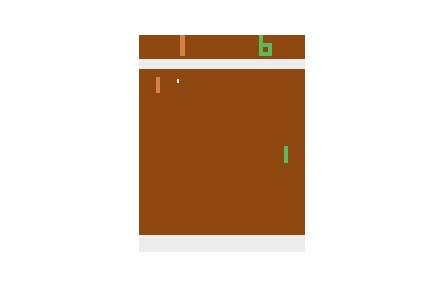
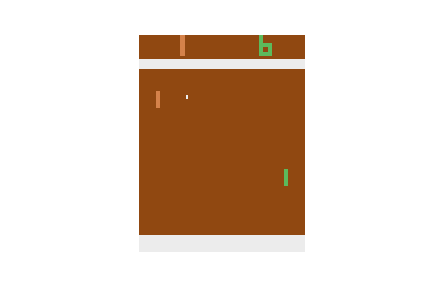
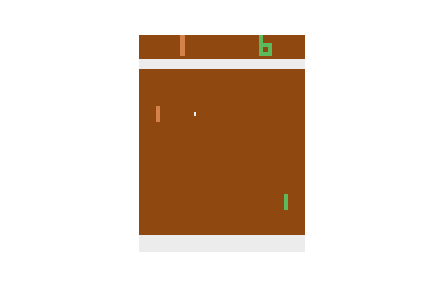
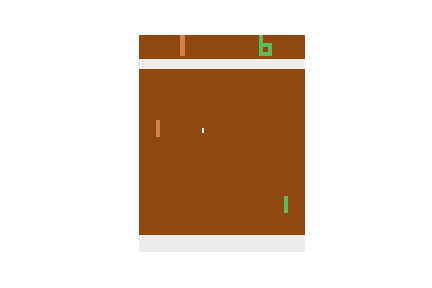
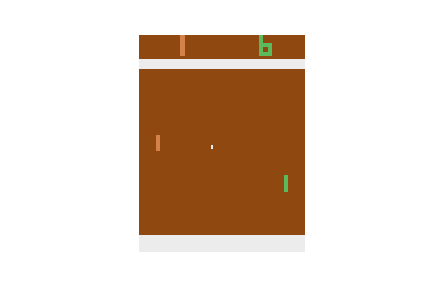
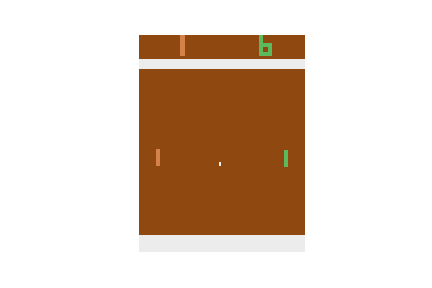
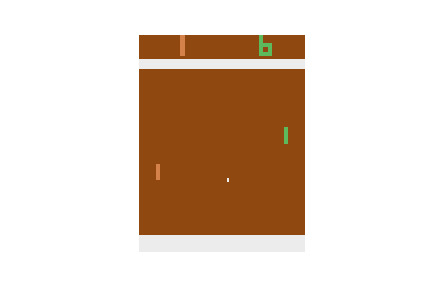
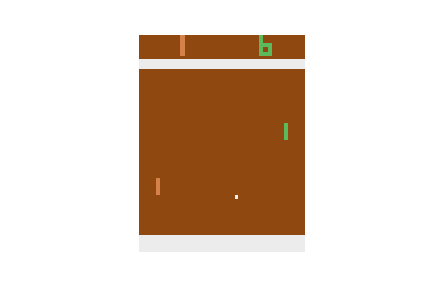
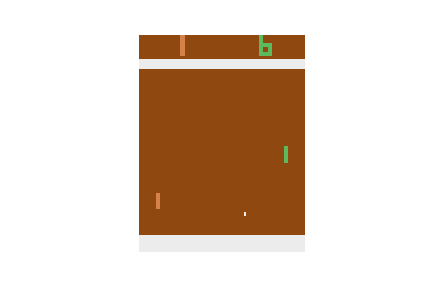
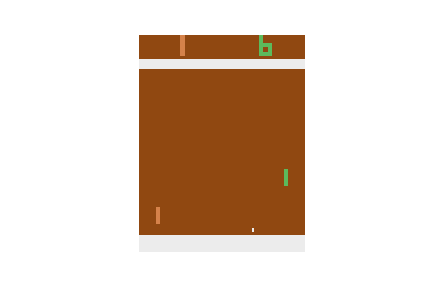
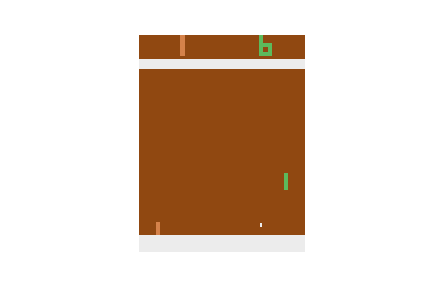
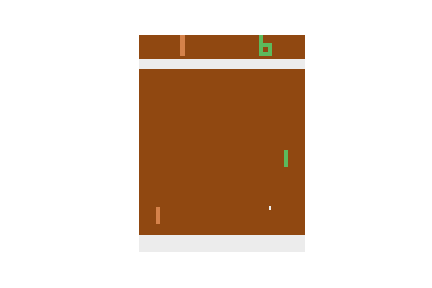
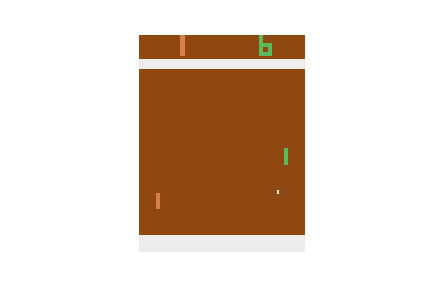
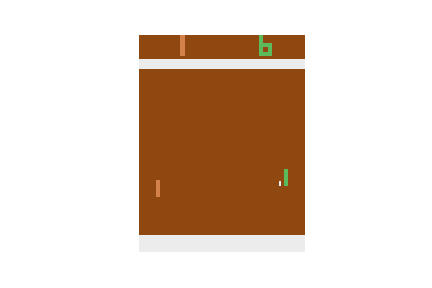
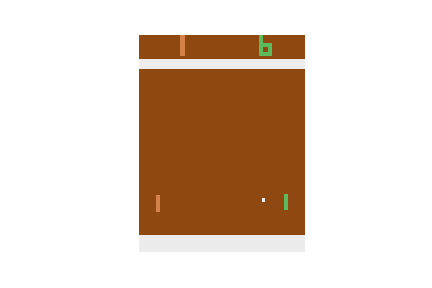
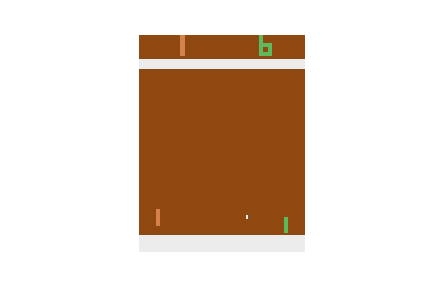
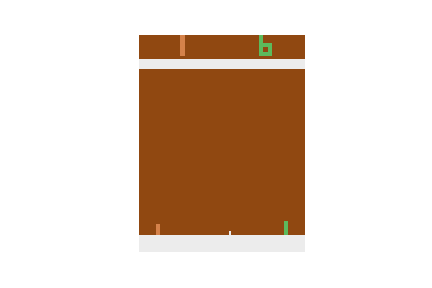
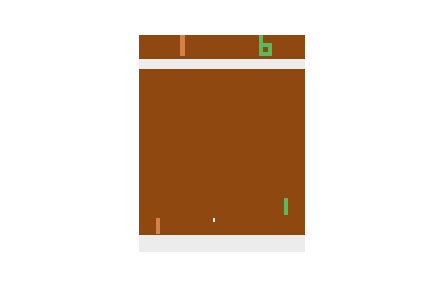
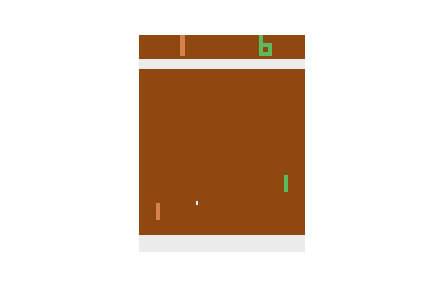
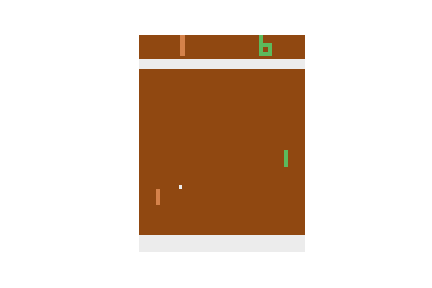
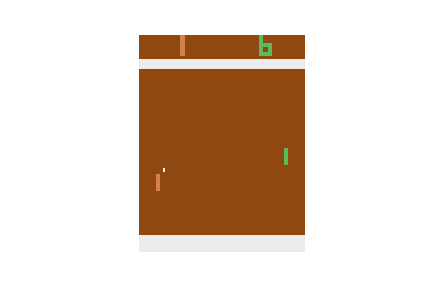
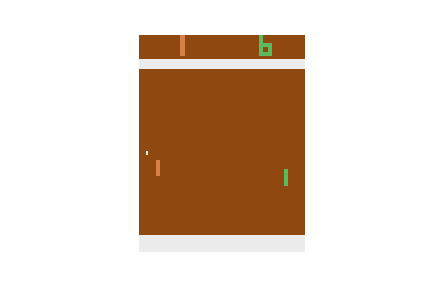
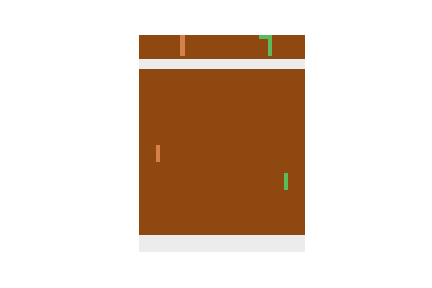
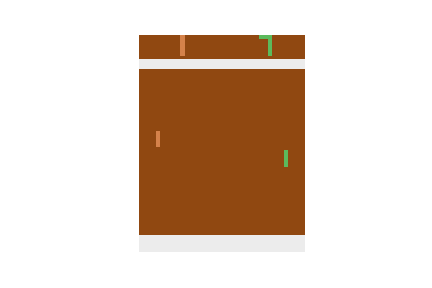
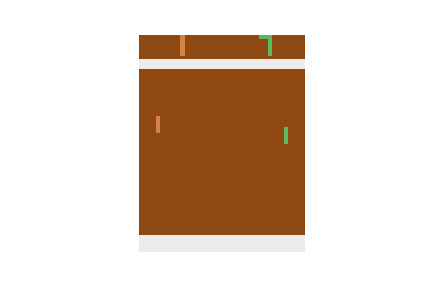
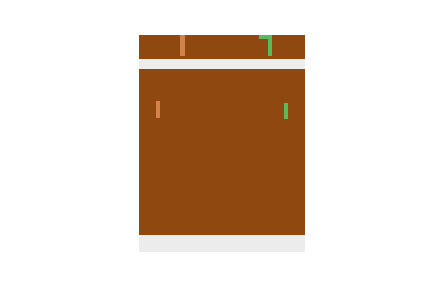
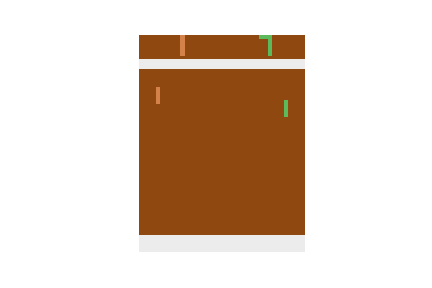
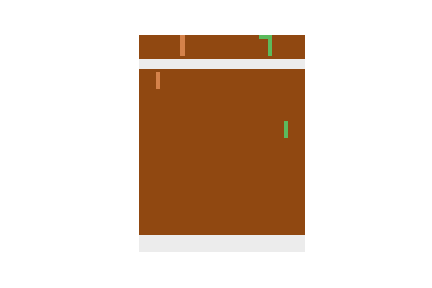
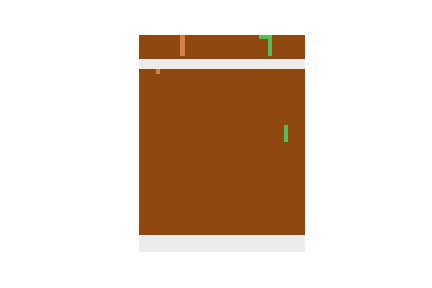
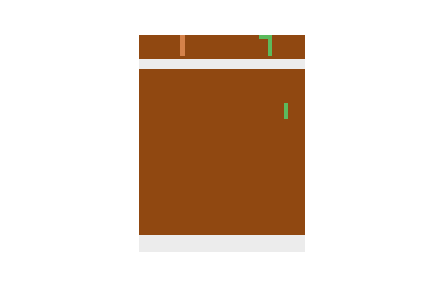
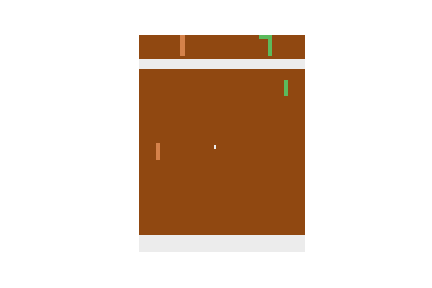
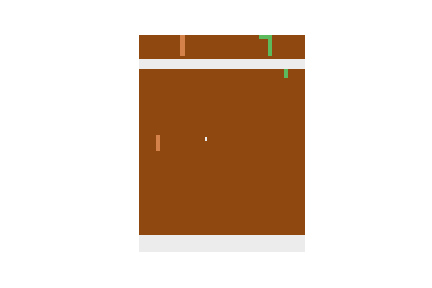
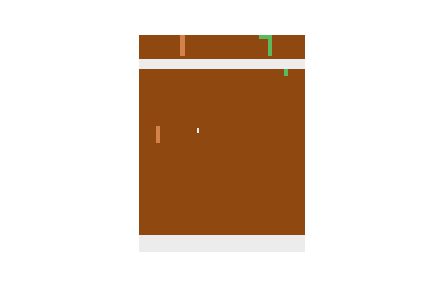
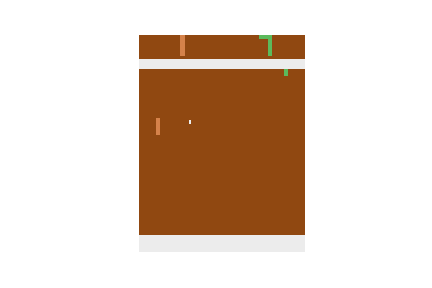
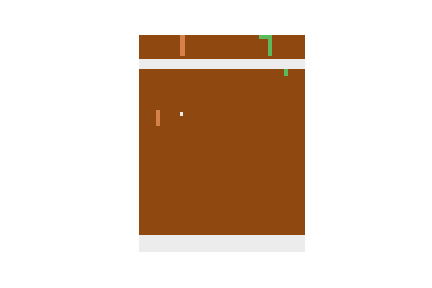
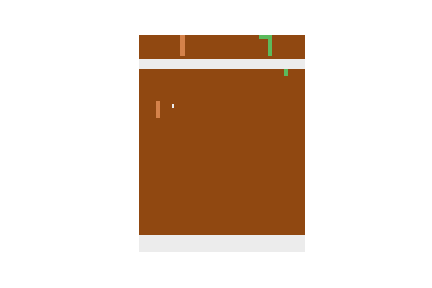
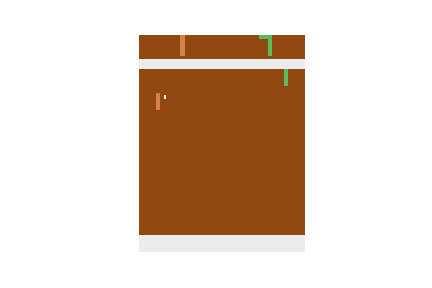
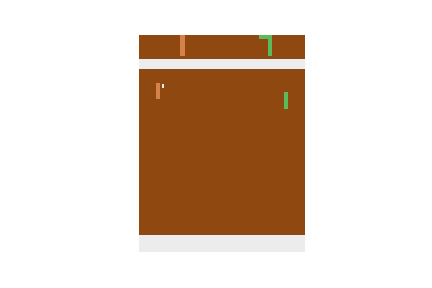
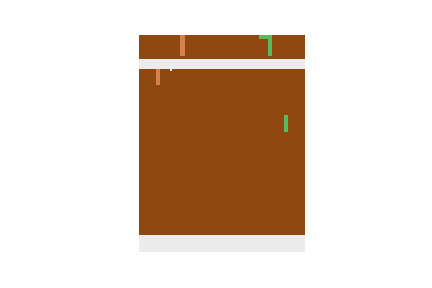
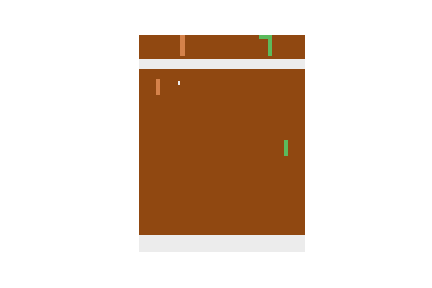
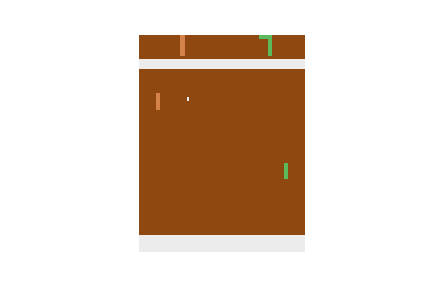
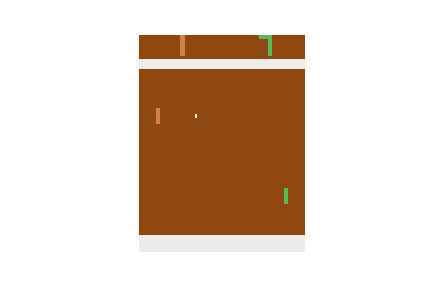
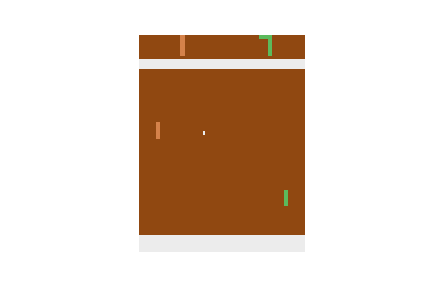
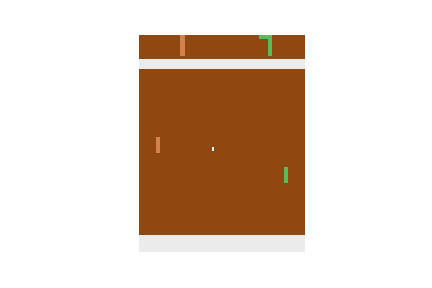
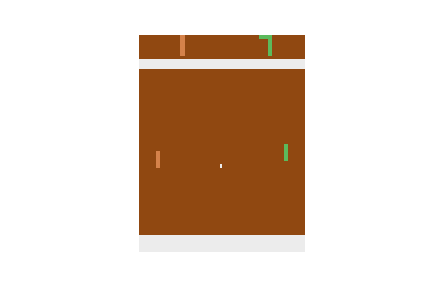
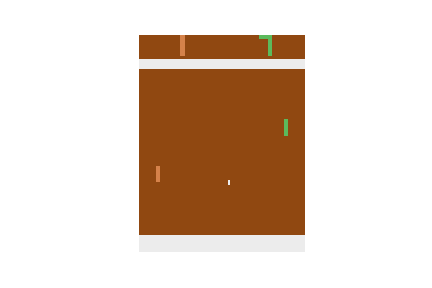
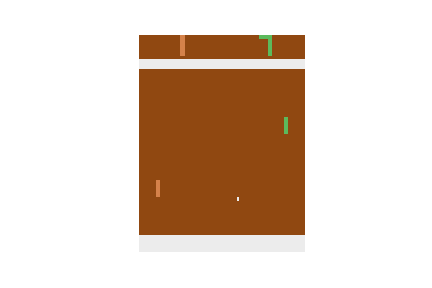
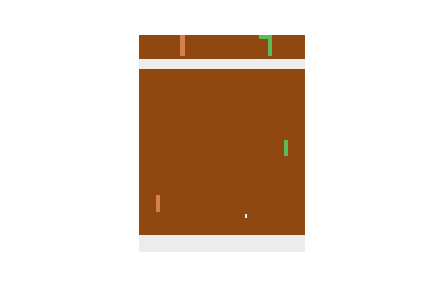
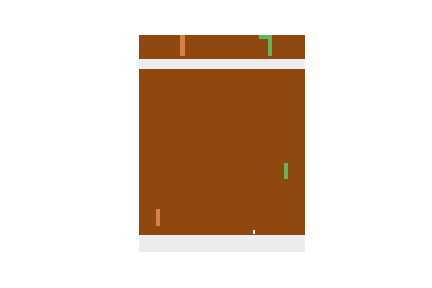
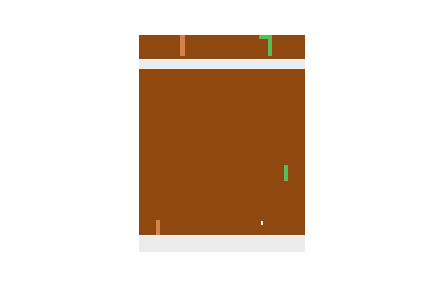
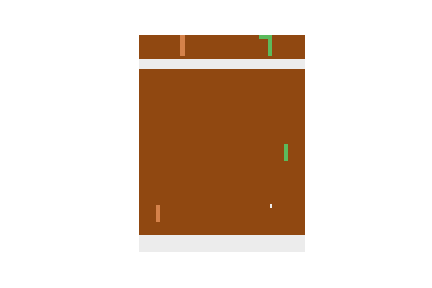
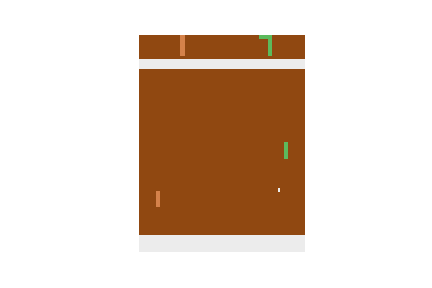
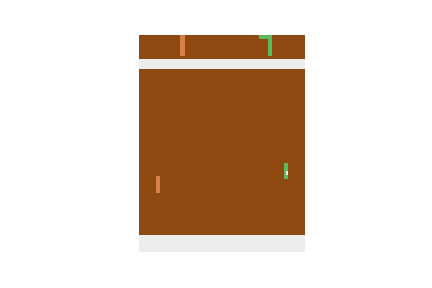
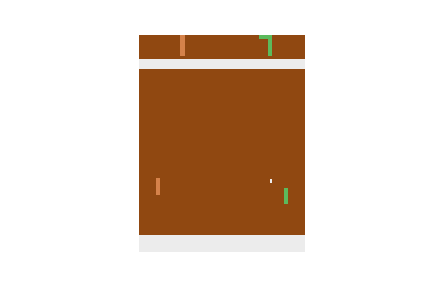
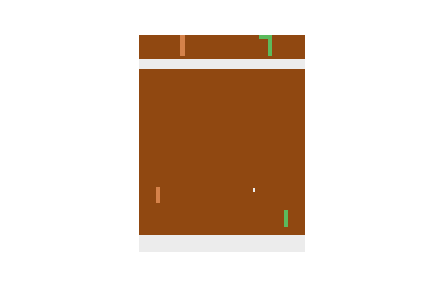
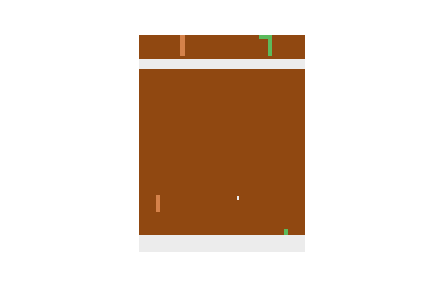
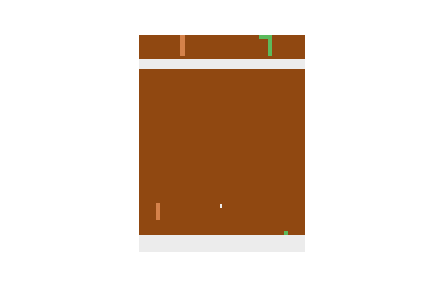
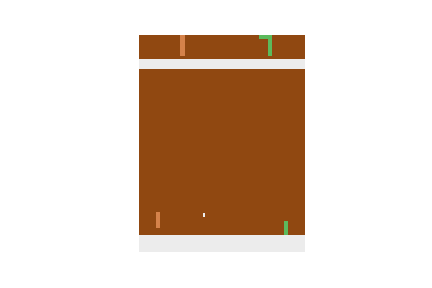
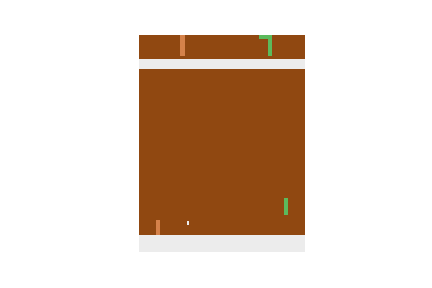
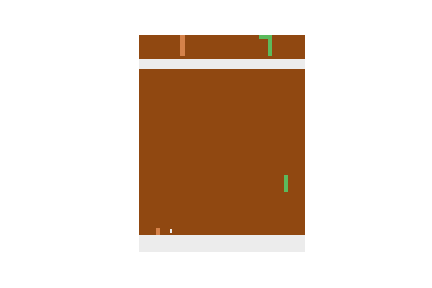
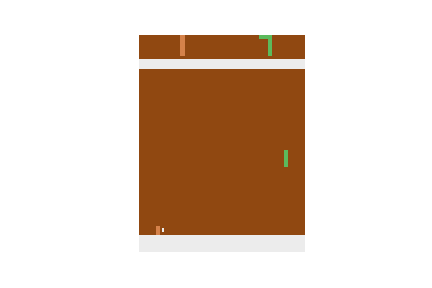
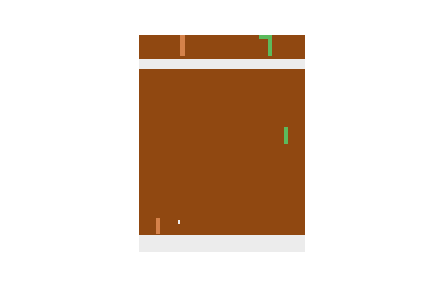
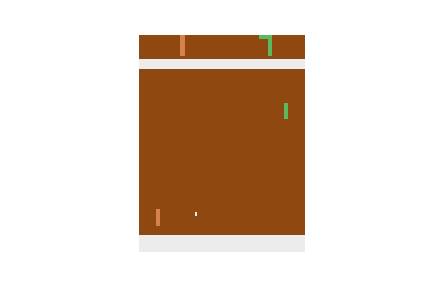
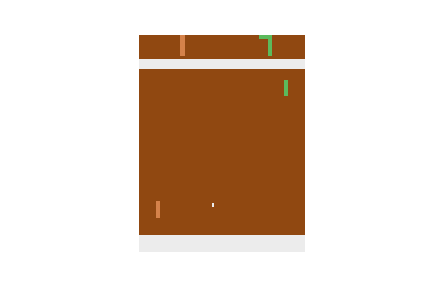
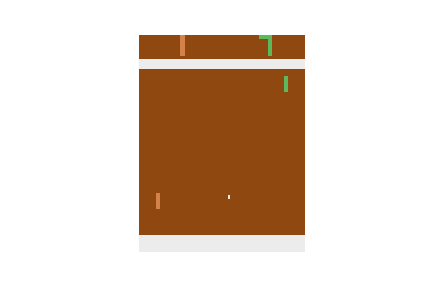
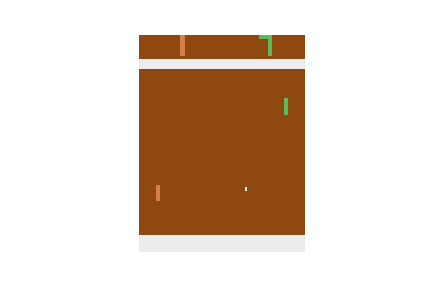
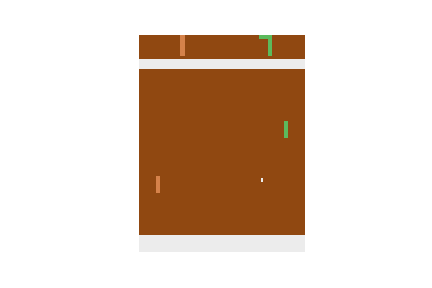
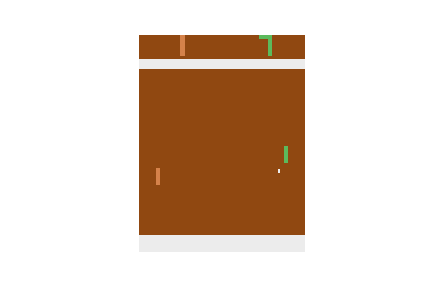
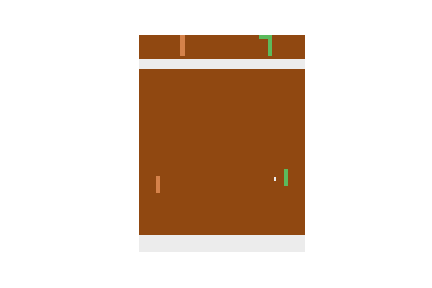
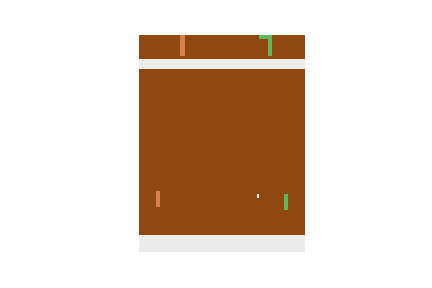
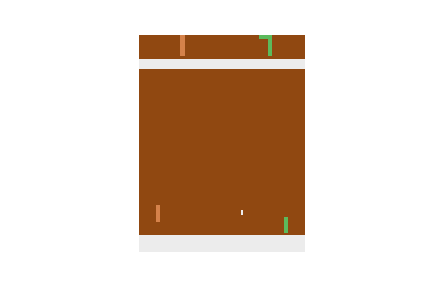
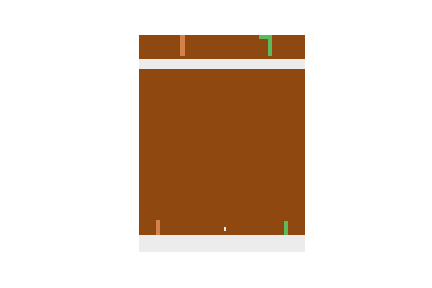
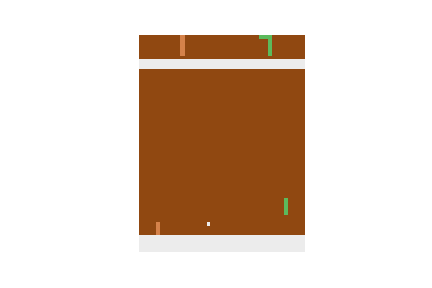
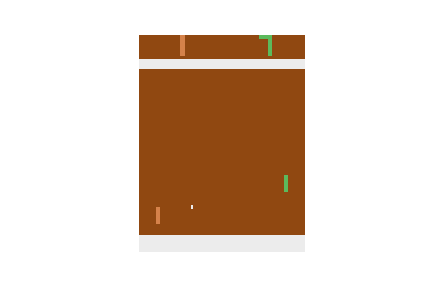
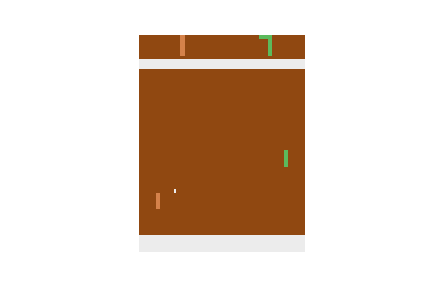
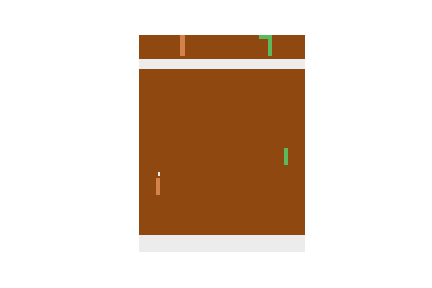
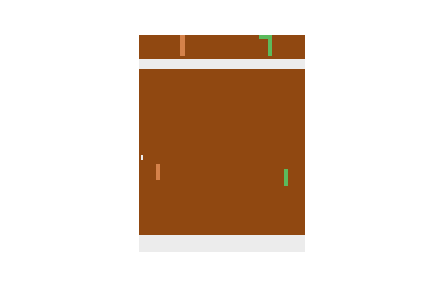
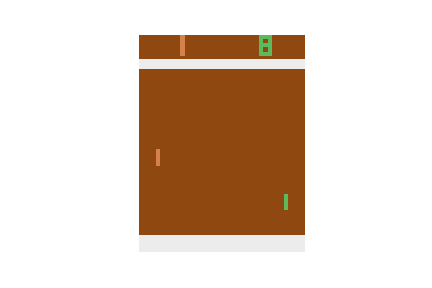
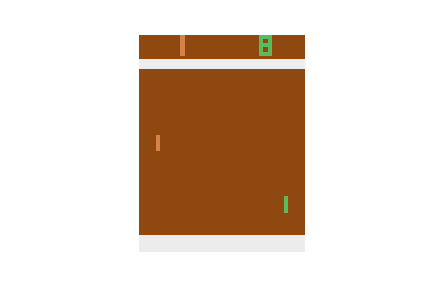
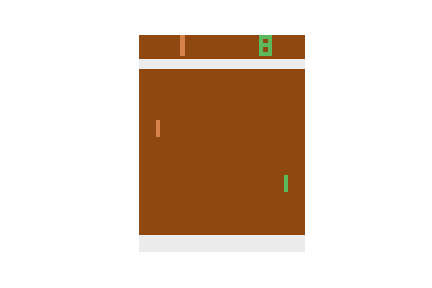
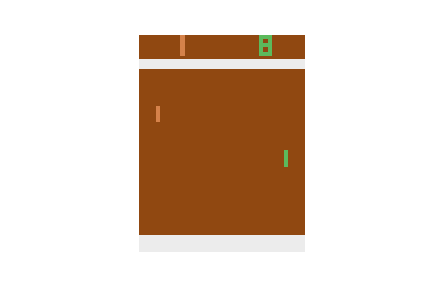
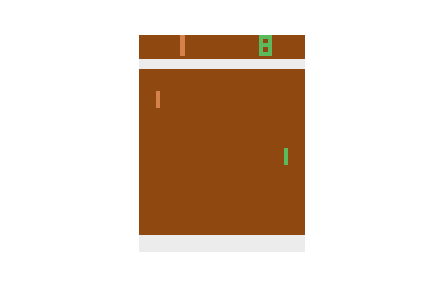
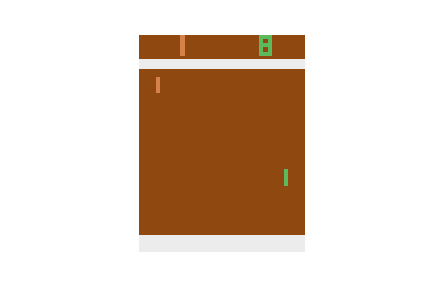
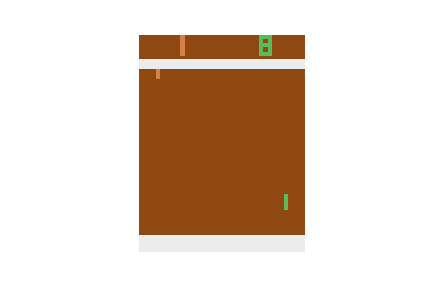
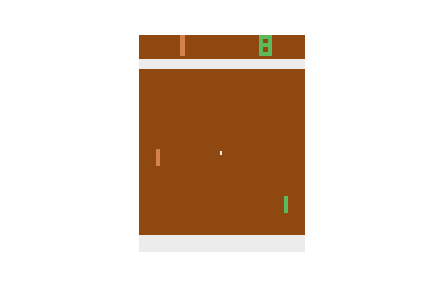
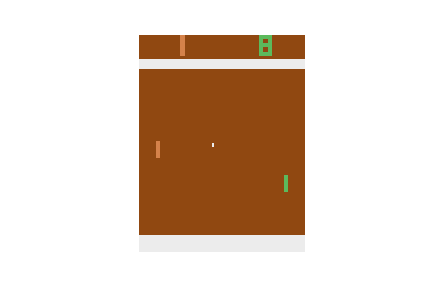
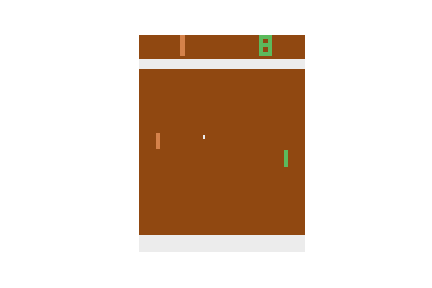
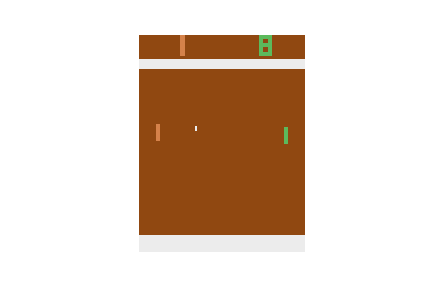
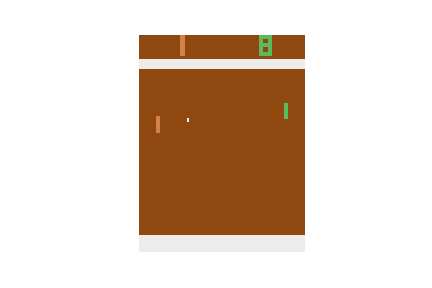
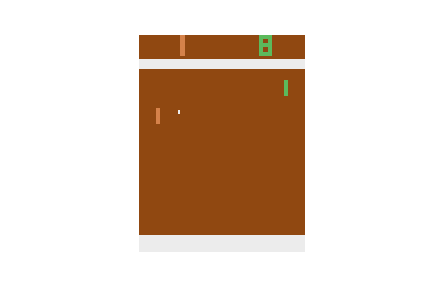
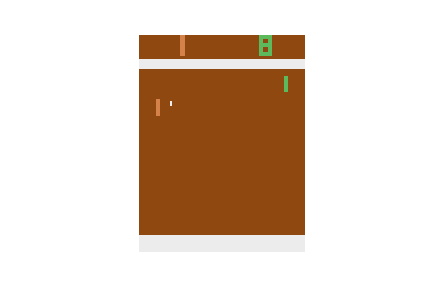
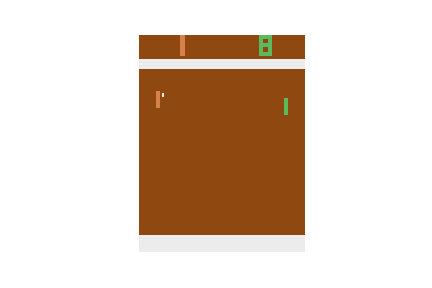
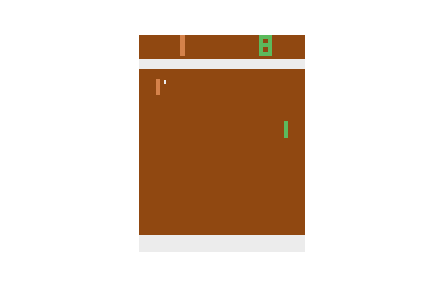
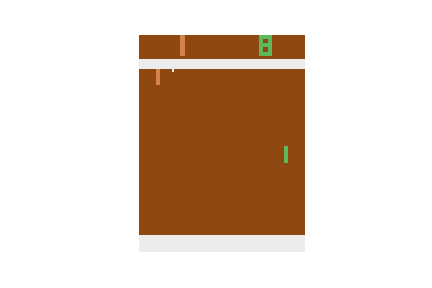
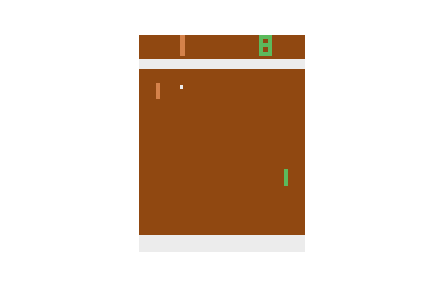
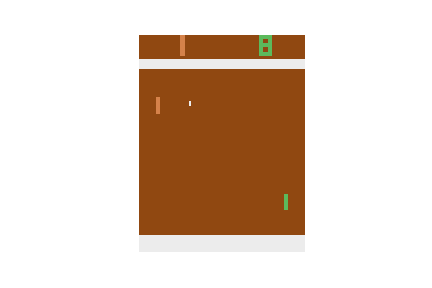
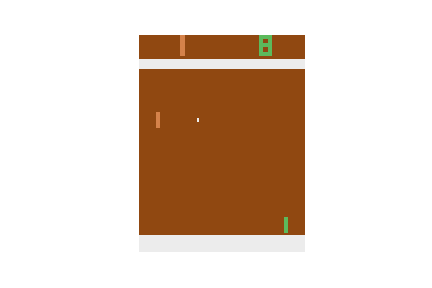
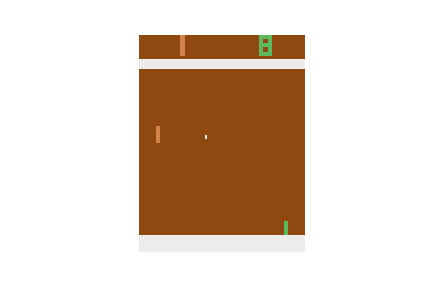
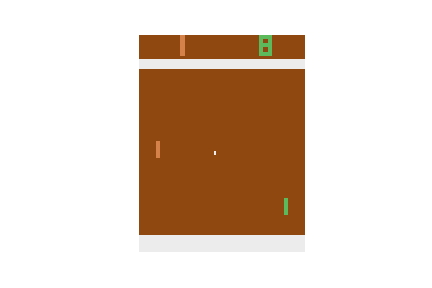
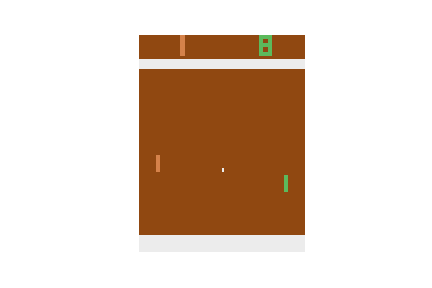
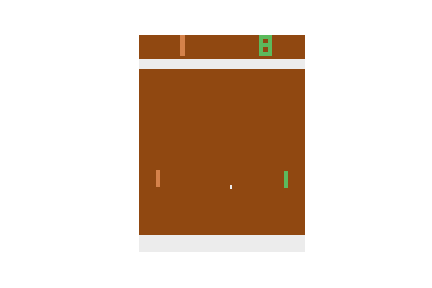
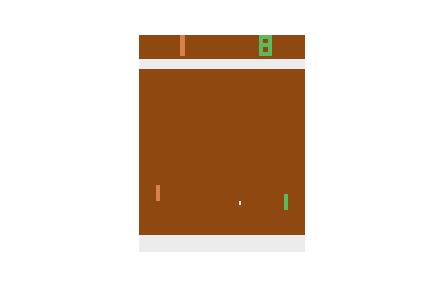
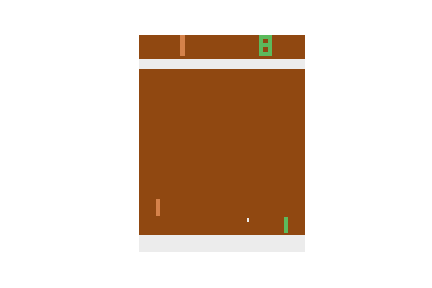
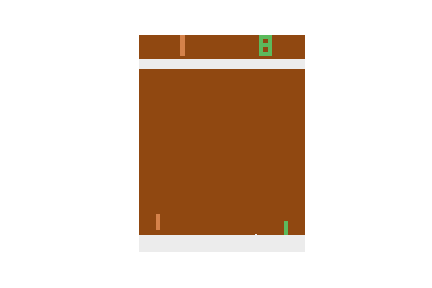
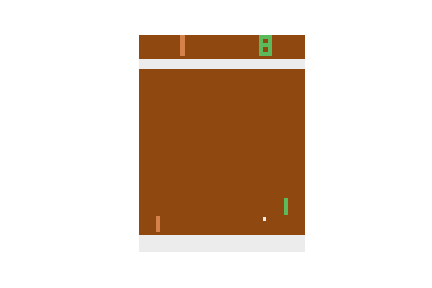
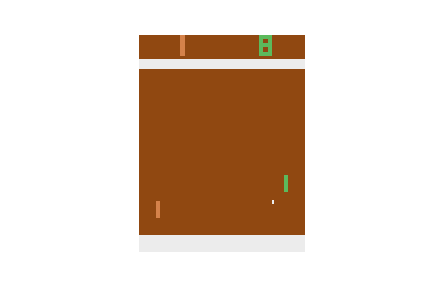
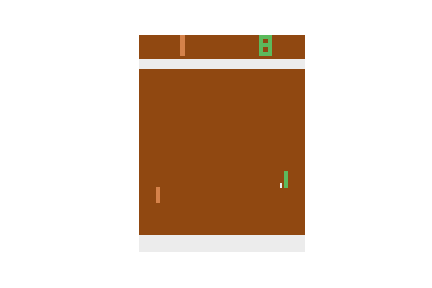
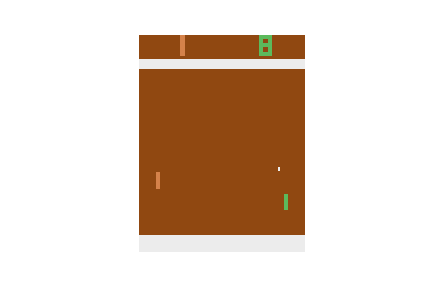
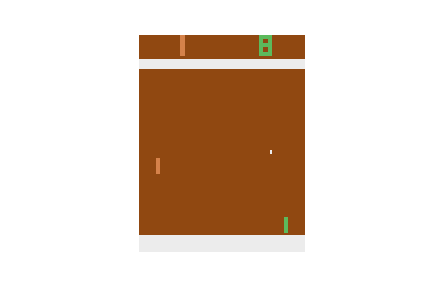
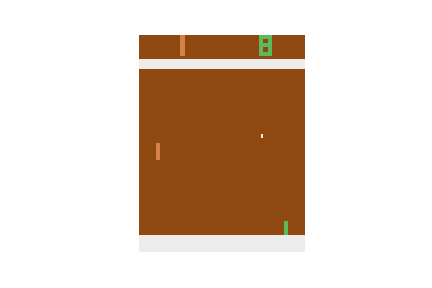
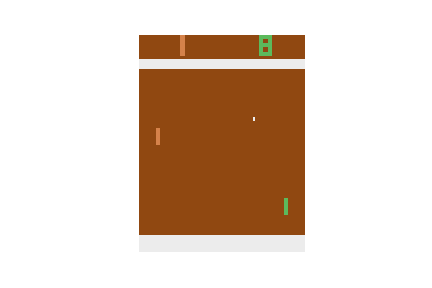
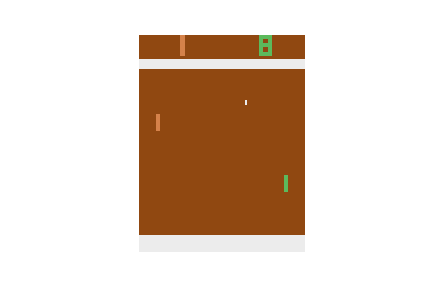
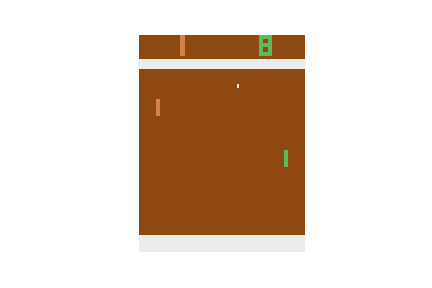
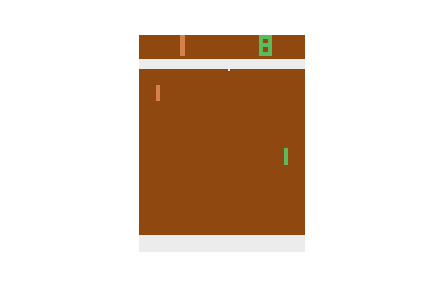
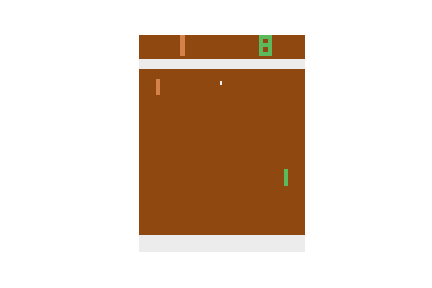
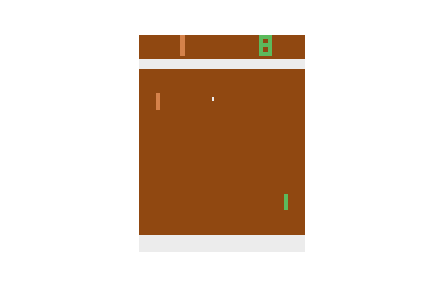
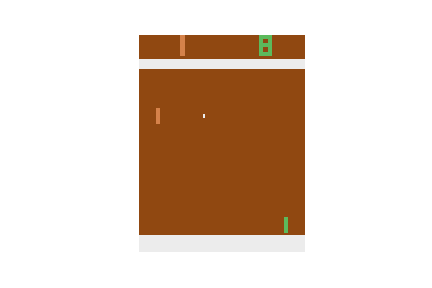
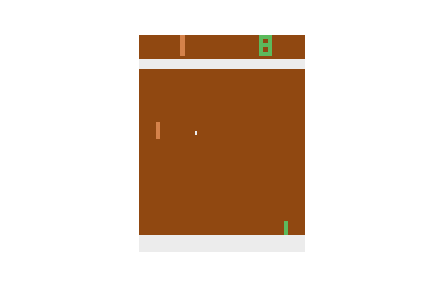
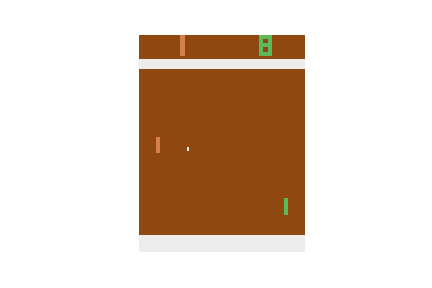
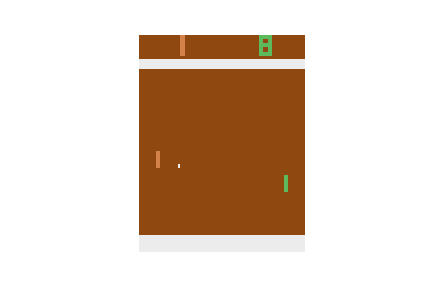
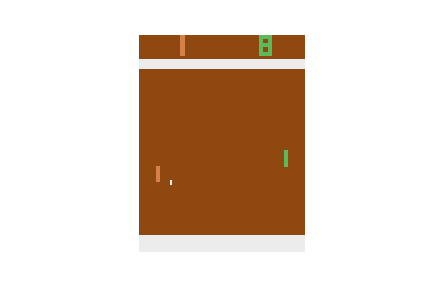
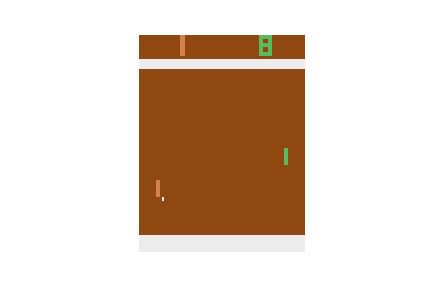
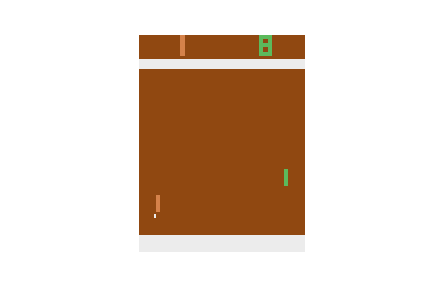
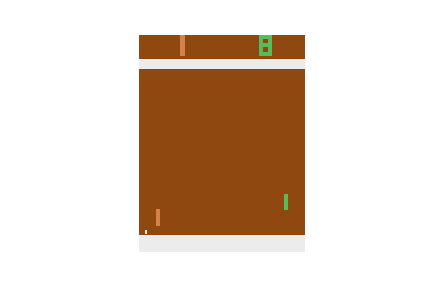
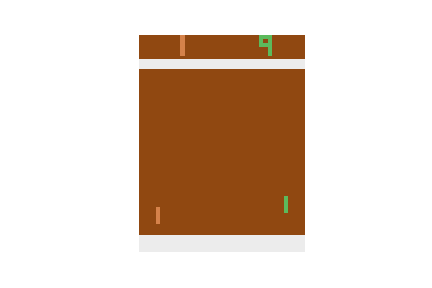
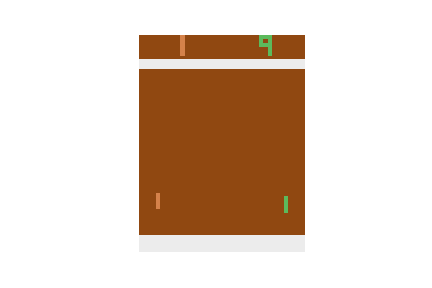
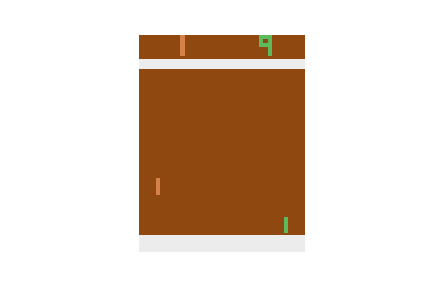
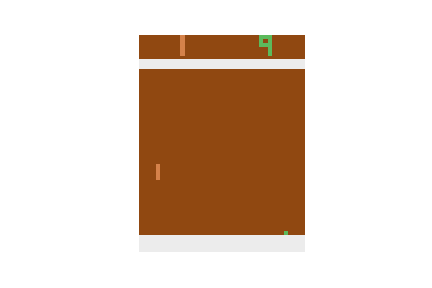
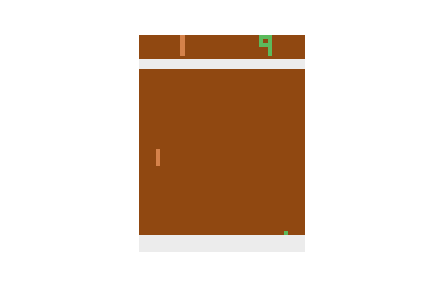
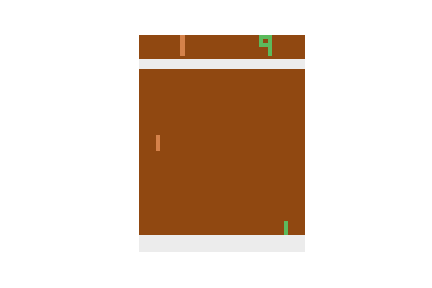
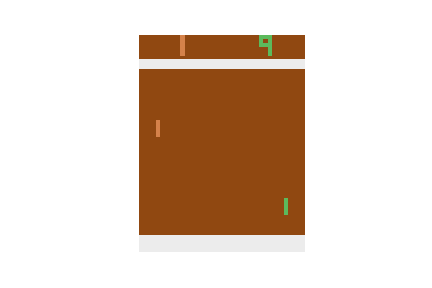
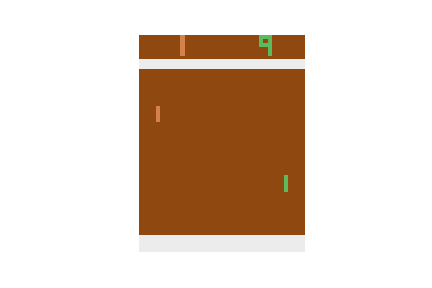
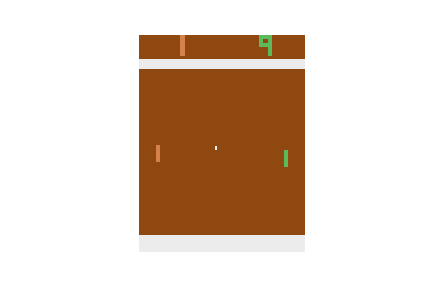
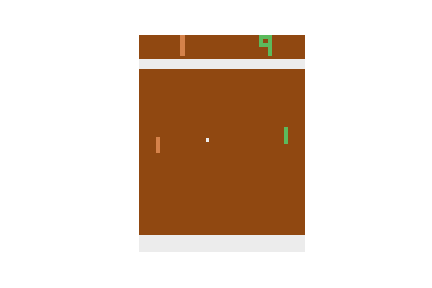
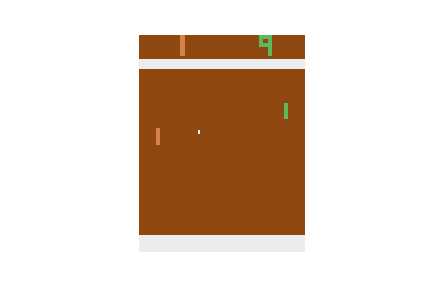
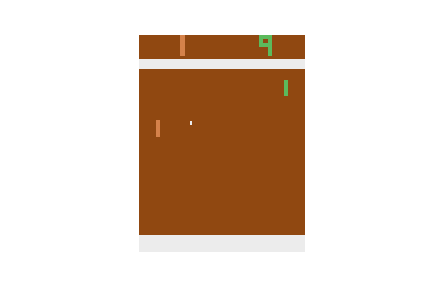
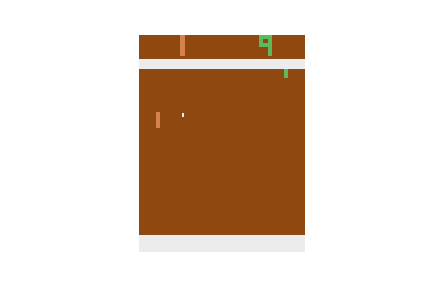
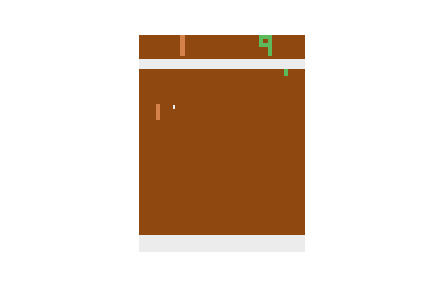
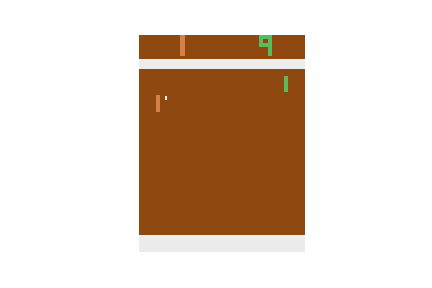
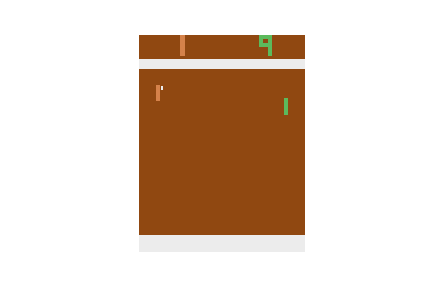
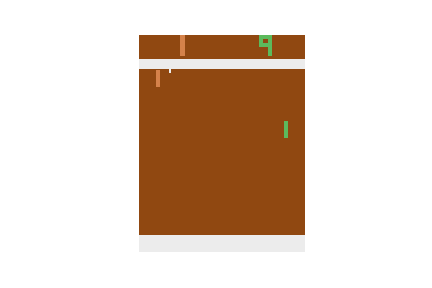
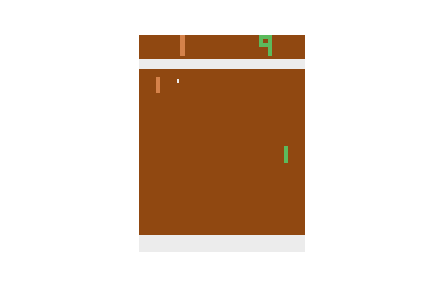
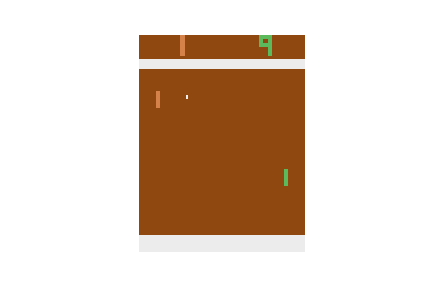
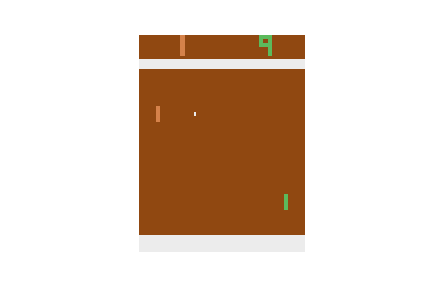
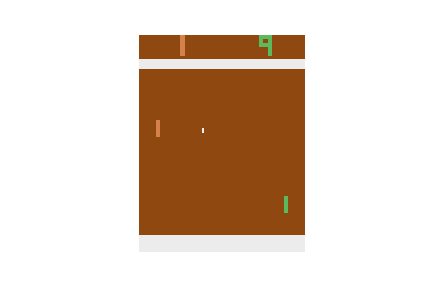
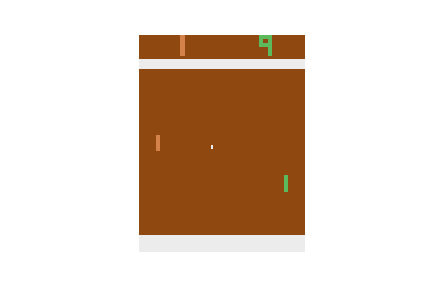
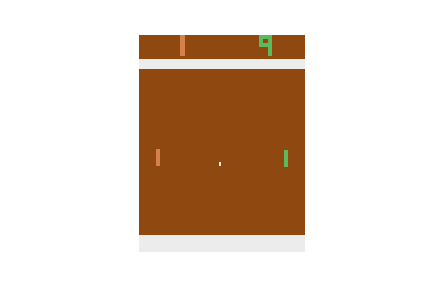
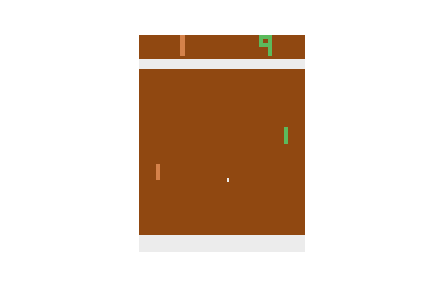
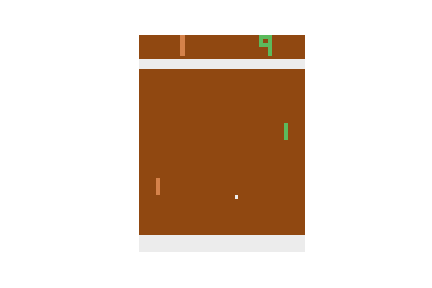
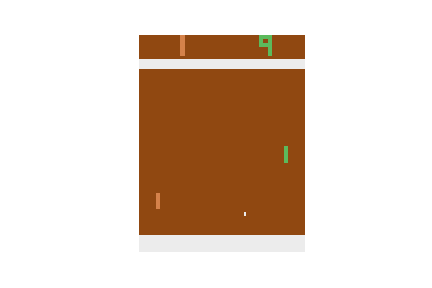
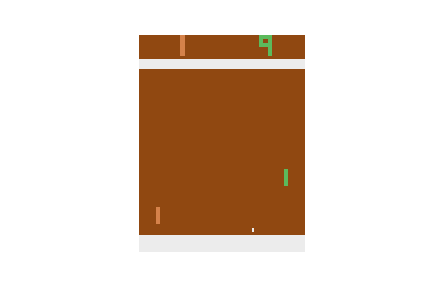
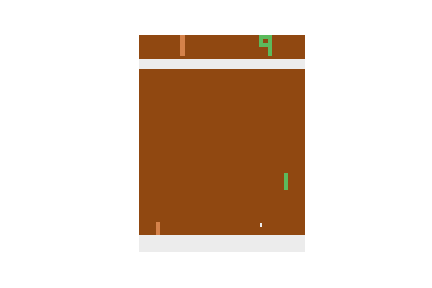
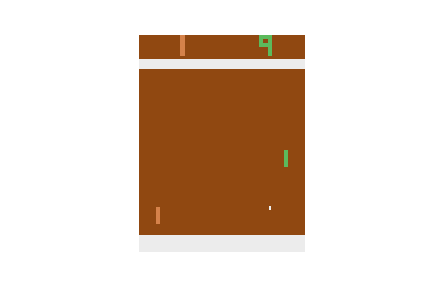
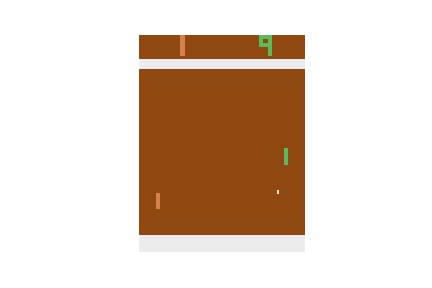
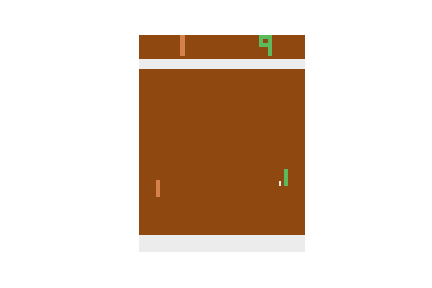
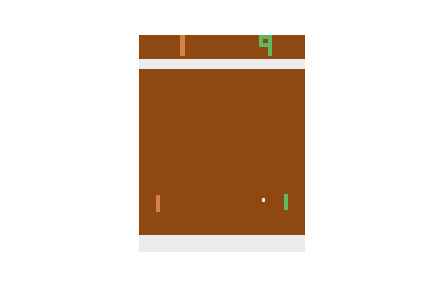
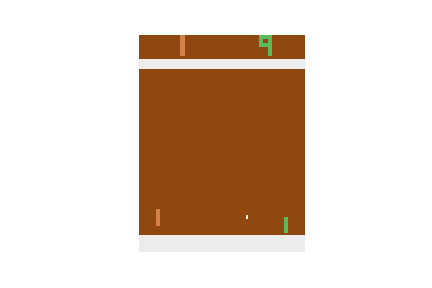
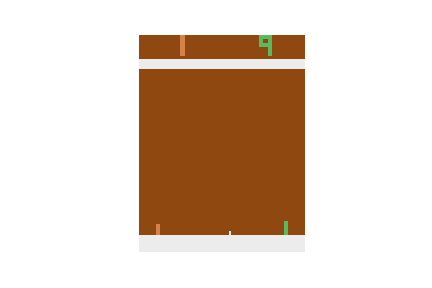
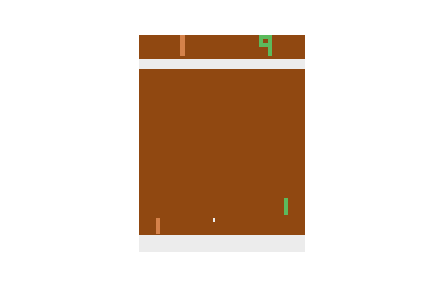
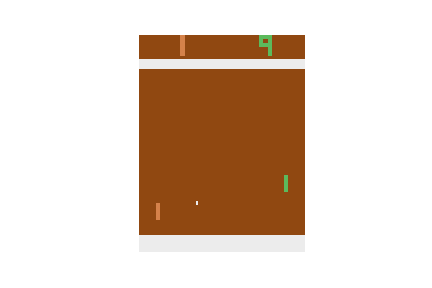
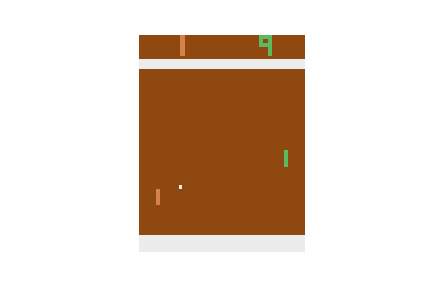
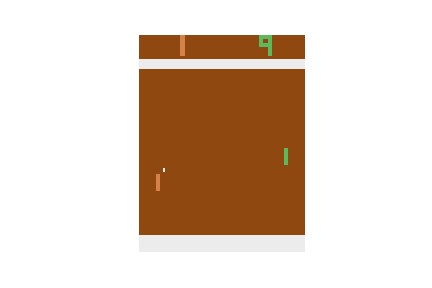
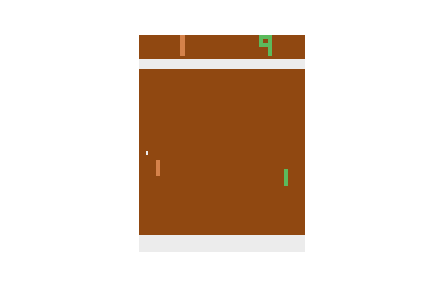
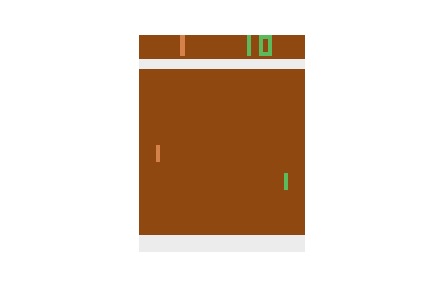
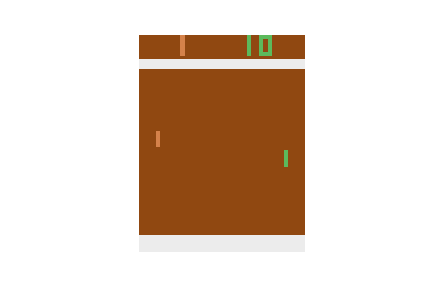
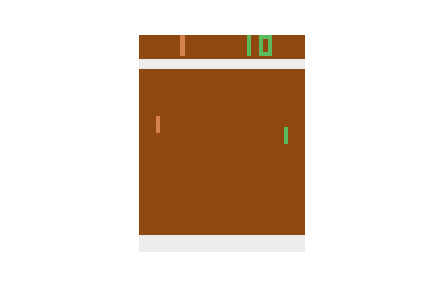
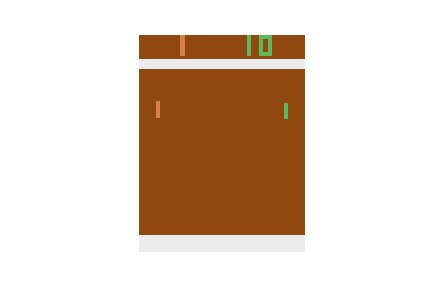

In [11]:
pong_utils.play(env, policy, time=500) 

In [12]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 